In [1]:
import os
import re
import cv2
import glob
import random
import shutil
import subprocess

import numpy as np
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.utils as vutils
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as TF

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc, roc_curve, confusion_matrix, classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cpu')

#### MNIST Dataset

In [5]:
print("Current working directory:", os.getcwd())

Current working directory: /content


In [6]:
base_dir = '/content'

In [7]:
train_dir = os.path.join(base_dir,  'mnist_train_data')
test_dir  = os.path.join(base_dir,  'mnist_test_data')

In [8]:
mnist_train = torchvision.datasets.MNIST( root = train_dir, train = True,  download = True)
mnist_test  = torchvision.datasets.MNIST( root = test_dir , train = False, download = True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 128MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 35.0MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 95.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.63MB/s]
100%|██████████| 9.91M/9.91M [00:00<00:00, 138MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 34.6MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 103MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.45MB/s]


In [9]:
mnist = '/content/mnist'
os.makedirs(mnist, exist_ok = True)

In [10]:
train_pth = '/content/mnist/train'
os.makedirs(train_pth, exist_ok = True)

In [11]:
for idx,(img, label) in enumerate(mnist_train):
  label_dir = os.path.join(train_pth, str(label))
  os.makedirs(label_dir, exist_ok = True)

  img_pth = os.path.join(label_dir, f"{idx}.png")
  img.save(img_pth)

In [12]:
test_pth = '/content/mnist/test'
os.makedirs(test_pth, exist_ok = True)

In [13]:
for idx, (img,label) in enumerate(mnist_test):
  label_dir = os.path.join(test_pth, str(label))
  os.makedirs(label_dir, exist_ok = True)

  img_pth = os.path.join(label_dir, f"{idx}.png")
  img.save(img_pth)

In [14]:
garbage_dir = os.path.join(train_pth, "garbage")
os.makedirs(garbage_dir, exist_ok = True)

In [15]:
!ls '/content/mnist/train'

0  1  2  3  4  5  6  7	8  9  garbage


In [16]:
!ls '/content/mnist/test'

0  1  2  3  4  5  6  7	8  9


In [17]:
for i in range(10):
  dir_pth = os.path.join(train_pth, f"{i}")
  dir_size = len([f for f in os.listdir(dir_pth) if os.path.isfile(os.path.join(dir_pth,f))])
  print(f"size of class{i}:{dir_size}")

size of class0:5923
size of class1:6742
size of class2:5958
size of class3:6131
size of class4:5842
size of class5:5421
size of class6:5918
size of class7:6265
size of class8:5851
size of class9:5949


In [18]:
for i in range(10):
  dir_pth = os.path.join(test_pth, f"{i}")
  dir_size = len([f for f in os.listdir(dir_pth) if os.path.isfile(os.path.join(dir_pth,f))])
  print(f"size of class{i}:{dir_size}")

size of class0:980
size of class1:1135
size of class2:1032
size of class3:1010
size of class4:982
size of class5:892
size of class6:958
size of class7:1028
size of class8:974
size of class9:1009


#### Guassian noise samples in garbage class

In [19]:
# folder_path = garbage_dir
# # Check if folder exists before deleting
# if os.path.exists(folder_path) and os.path.isdir(folder_path):
#     shutil.rmtree(folder_path)
#     print(f"Deleted folder: {folder_path}")
# else:
#     print("Folder does not exist!")

In [20]:
# garbage_dir = os.path.join(train_pth, "garbage")
# os.makedirs(garbage_dir, exist_ok = True)

In [21]:
noise_samples = 6000
print("Generating Gaussian noise samples for garbage class...")

for i in range(noise_samples):
    # Generate Gaussian noise (mean=0.5, std=0.15 to keep most values in reasonable range)
    random_noise = torch.randn(28, 28) * 0.15 + 0.5
    random_noise = torch.clamp(random_noise, 0, 1)  # values in [0, 1]

    # Convert to PIL Image (simulating the raw input format)
    random_noise_pil = transforms.ToPILImage()(random_noise.unsqueeze(0))

    ood_image_pth = os.path.join(garbage_dir, f"noise_{i+1}.png")
    random_noise_pil.save(ood_image_pth)

print(f"Generated {noise_samples} Gaussian noise samples")

Generating Gaussian noise samples for garbage class...
Generated 6000 Gaussian noise samples


#### Transformations

In [ ]:
# import torch
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader

# def calculate_mean_std(dataset_loader):
#     """
#     Calculate mean and standard deviation of a dataset.
#     """
#     channel_sum = 0.0
#     channel_squared_sum = 0.0
#     num_batches = 0

#     for data, _ in dataset_loader:
#         data = data.float()
#         channel_sum += torch.mean(data, dim=[0, 2, 3])
#         channel_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
#         num_batches += 1

#     mean = channel_sum / num_batches
#     std = (channel_squared_sum / num_batches - mean ** 2) ** 0.5

#     return mean, std


# transform = transforms.Compose([
#     transforms.ToTensor()
# ])

# print("Calculating for MNIST...")
# mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# mnist_loader = DataLoader(mnist_train, batch_size=64, shuffle=False)

# mnist_mean, mnist_std = calculate_mean_std(mnist_loader)
# print(f"MNIST - Mean: {mnist_mean.tolist()}, Std: {mnist_std.tolist()}")

Calculating for MNIST...


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 343kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.8MB/s]


MNIST - Mean: [0.13065215945243835], Std: [0.30809691548347473]


In [22]:
mnist_mean  = 0.1307
mnist_std   = 0.3081

mnist_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((mnist_mean,), (mnist_std,))
])

In [23]:
train_dataset = ImageFolder(root=train_pth, transform  = mnist_transform)
test_dataset  = ImageFolder(root=test_pth,  transform  = mnist_transform)

In [24]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=batch_size, shuffle=False)

#### Checking Datasets and DataLoaders

In [ ]:
img, label = train_dataset[0]
print(type(img), img.shape)
print(type(label), label)

<class 'torch.Tensor'> torch.Size([1, 28, 28])
<class 'int'> 0


In [ ]:
img, label = train_dataset[61000]
print(type(img), img.shape)
print(type(label), label)

<class 'torch.Tensor'> torch.Size([1, 28, 28])
<class 'int'> 10


In [ ]:
len(train_dataset)

66000

In [ ]:
len(test_dataset)

10000

In [ ]:
train_dataset.samples[:5]

[('/content/mnist/train/0/1.png', 0),
 ('/content/mnist/train/0/1000.png', 0),
 ('/content/mnist/train/0/10005.png', 0),
 ('/content/mnist/train/0/10010.png', 0),
 ('/content/mnist/train/0/10022.png', 0)]

In [ ]:
train_dataset.samples[-5:-1]

[('/content/mnist/train/garbage/noise_995.png', 10),
 ('/content/mnist/train/garbage/noise_996.png', 10),
 ('/content/mnist/train/garbage/noise_997.png', 10),
 ('/content/mnist/train/garbage/noise_998.png', 10)]

In [ ]:
len(train_loader)

2063

In [ ]:
len(test_loader)

313

In [ ]:
for imgs, labels in train_loader:
    print(type(imgs), imgs.shape)      # torch.Tensor [batch, 1, 28, 28]
    print(type(labels), labels.shape)  # torch.Tensor [batch]
    break

<class 'torch.Tensor'> torch.Size([32, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([32])


In [ ]:
for imgs, labels in test_loader:
    print(type(imgs), imgs.shape)      # torch.Tensor [batch, 1, 28, 28]
    print(type(labels), labels.shape)  # torch.Tensor [batch]
    break

<class 'torch.Tensor'> torch.Size([32, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([32])


In [ ]:
mean_sum = torch.zeros(1)
std_sum = torch.zeros(1)
total_samples = 0
# Calculate mean and std per batch
with torch.no_grad():
    for images, _ in train_loader:
        # Reshape from [B, C, H, W] to [B, C, H*W]
        b, c, h, w = images.shape
        images_flat = images.view(b, c, h * w)

        # Calculate mean and std for each channel in this batch
        batch_mean = images_flat.mean(dim=2)   # Shape: [B, C]
        batch_std = images_flat.std(dim=2)     # Shape: [B, C]

        mean_sum += batch_mean.sum(dim=0)
        std_sum += batch_std.sum(dim=0)
        total_samples += b

# Compute the final average mean and std
final_mean = mean_sum / total_samples
final_std = std_sum / total_samples

print(f'MNIST Normalized Mean : {final_mean.tolist()}')
print(f'MNIST Normalized Std  : {final_std.tolist()}')

MNIST Normalized Mean : [0.108283132314682]
MNIST Normalized Std  : [0.9338301420211792]


In [ ]:
loader = train_loader

all_means, all_stds = [], []
for imgs, labels in loader:
    mask = (labels == 10)       # Only garbage class
    if mask.any():
        garbage_imgs = imgs[mask]
        all_means.append(garbage_imgs.mean().item())
        all_stds.append(garbage_imgs.std().item())

print("Garbage (after transform): mean =", sum(all_means)/len(all_means),
      "std =", sum(all_stds)/len(all_stds))

Garbage (after transform): mean = 1.1924122551287109 std = 0.4864908448903689


In [ ]:
print("Training Dataset:")
print(f"Size:{len(train_dataset)}")
print(f"Shape:{next(iter(train_loader))[0].shape}")
print(f"Batch size: {train_loader.batch_size}")

print("\nTesting Dataset:")
print(f"Size:{len(test_dataset)}")
print(f"Shape:{next(iter(test_loader))[0].shape}")
print(f"Batch size: {test_loader.batch_size}")

Training Dataset:
Size:66000
Shape:torch.Size([32, 1, 28, 28])
Batch size: 32

Testing Dataset:
Size:10000
Shape:torch.Size([32, 1, 28, 28])
Batch size: 32


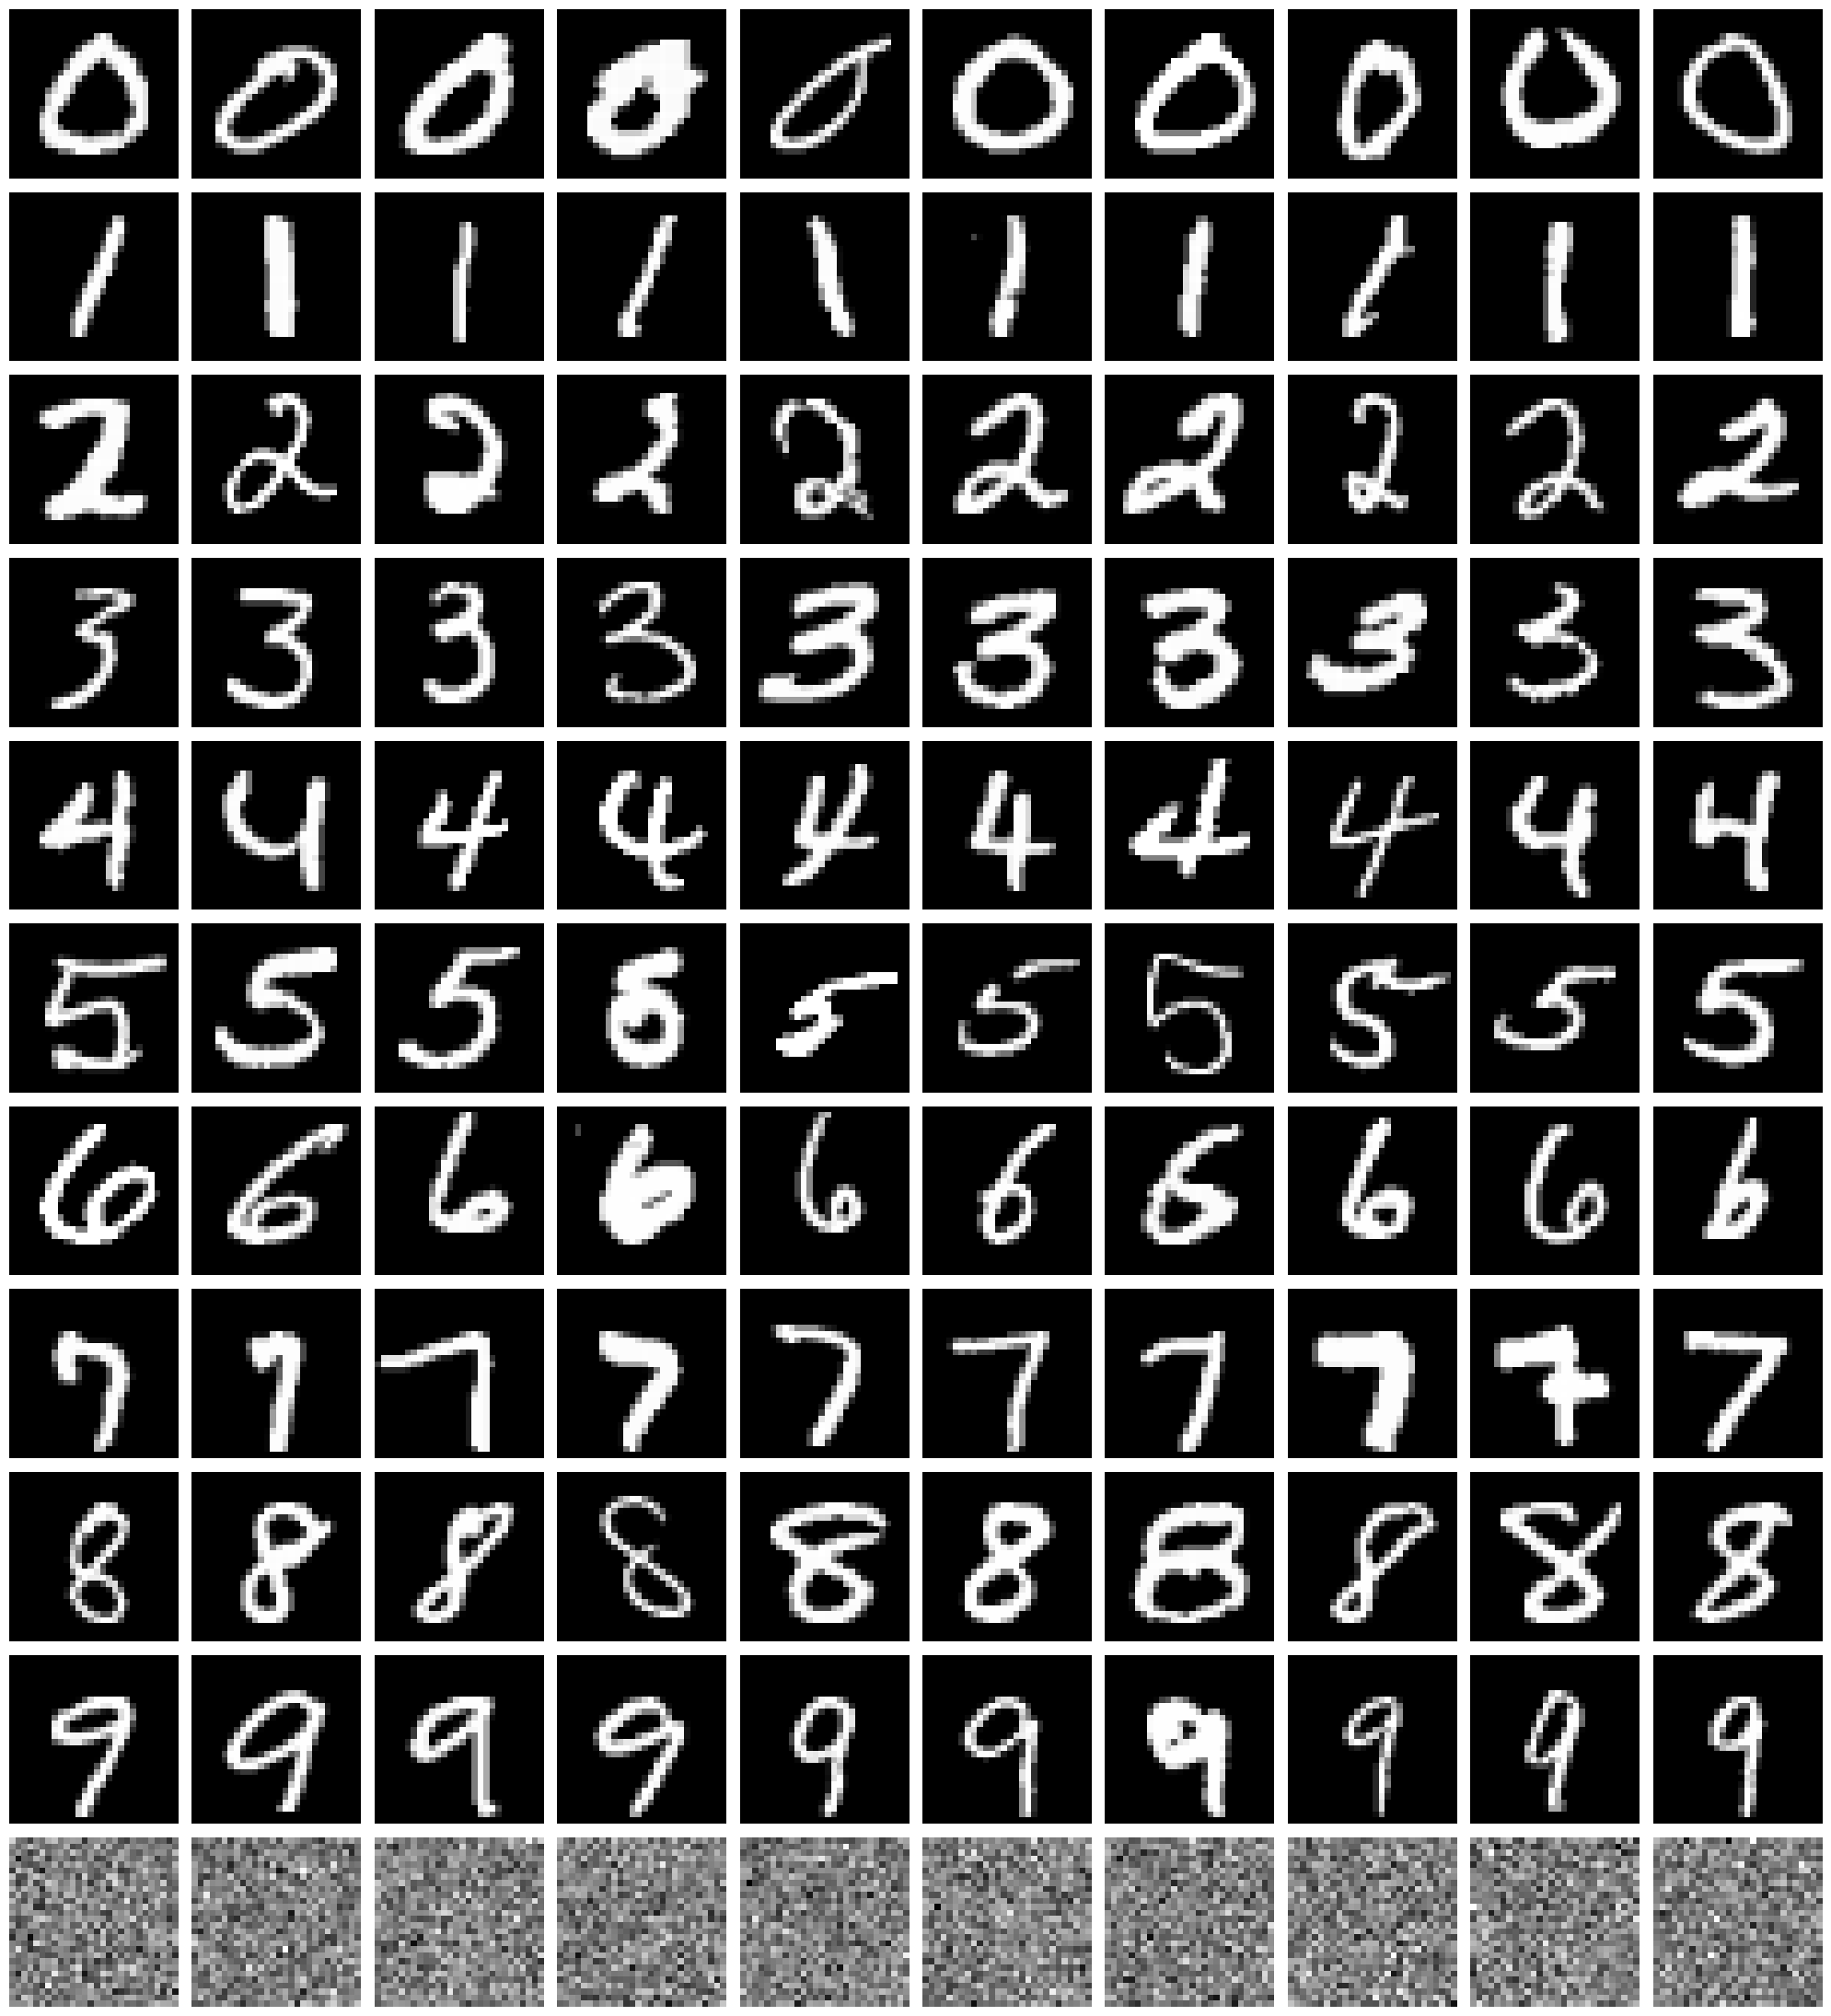

In [ ]:
class_images = {}

for class_name in sorted(os.listdir(train_pth)):
    class_pth = os.path.join(train_pth, class_name)

    if os.path.isdir(class_pth):
        class_images[class_name] = []

        for image_file in os.listdir(class_pth)[:10]:
            image_pth = os.path.join(class_pth, image_file)
            image = cv2.imread(image_pth, cv2.IMREAD_COLOR)     # read in color (BGR)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert to RGB
                class_images[class_name].append(image)

# Create subplot grid
fig, axs = plt.subplots(len(class_images), 10, figsize=(20, 2*len(class_images)))

for i, (class_name, images) in enumerate(class_images.items()):
    for j in range(10):
        axs[i, j].imshow(images[j])  # already RGB
        axs[i, j].axis("off")

plt.tight_layout()
plt.show()

#### Classifier

##### 3 conv2d + 2 Linear

In [25]:
class Classifier(nn.Module):
    def __init__(self, nc, ncf, n_classes=11):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(nc, ncf, 4, 2, 1, bias=False),     # [B,nc,28,28] -> [B,ncf,14,14]
            nn.BatchNorm2d(ncf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ncf, ncf*2, 4, 2, 1, bias=False),   # [B,ncf,14,14] -> [B,ncf*2,7,7]
            nn.BatchNorm2d(ncf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ncf*2, ncf*4, 3, 1, 0, bias=False), # [B,ncf*2,7,7] --> [B,ncf*4,5,5]
            nn.BatchNorm2d(ncf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.AdaptiveAvgPool2d(1),                      # [B,ncf*4,5,5] -> [B,ncf*4,1,1]
            nn.Flatten(),                                 # [B, ncf*4]
        )

        self.penultimate = nn.Sequential(
            nn.Linear(ncf*4, ncf*2),                      # [B, ncf*4] --> [B,ncf*2]
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
        )

        self.classifier = nn.Linear(ncf*2, n_classes)     # [B,ncf*2] --> [B, n_classes]

    def forward(self, x):
        features = self.feature_extractor(x)
        penultimate_features = self.penultimate(features)
        logits = self.classifier(penultimate_features)
        return logits, penultimate_features

#### Generator

In [ ]:
class Generator(nn.Module):
  def __init__(self, n_classes, nz, ngf, nc):
    super().__init__()

    self.embed = nn.Linear(n_classes, nz)   # [B,n_classes] --> [B,nz]

    self.main = nn.Sequential(
        nn.ConvTranspose2d(nz*2, ngf*4, 4,1,0,bias=False),    # [B,nz*2,1,1] --> [B,ngf*4,4,4]
        nn.BatchNorm2d(ngf*4),
        nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(ngf*4, ngf*2, 4,2,1,bias=False),   # [B,ngf*4,4,4] --> [B,ngf*2,8,8]
        nn.BatchNorm2d(ngf*2),
        nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(ngf*2, ngf, 4,2,2,bias=False),     # [B,ngf*2,8,8] --> [B,ngf,14,14]
        nn.BatchNorm2d(ngf),
        nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(ngf, nc, 4,2,1, bias=False),       # [B,ngf,14,14] --> [B,nc,28,28]
        nn.Tanh()
    )

  def forward(self, latent_vec, cond_vec):
      embed_vec = self.embed(cond_vec).unsqueeze(-1).unsqueeze(-1)    #  [B,n_classes] --> [B,nz] --> [B,nz,1,1]
      input = torch.cat([latent_vec, embed_vec],1)   # [B,nz,1,1]+[B,nz,1,1]  dim=1 -->  [B,nz*2,1,1]
      return self.main(input)

#### Checking Classifier and Generator

In [ ]:
nz = 100
nc = 1
ncf = 64
ngf = 64
n_classes = 11
batch_size = 5

gen = Generator(n_classes, nz, ngf, nc).to(device)
csf = Classifier(nc, ncf).to(device)

latent_vec = torch.randn((batch_size, nz, 1, 1), device=device)
print("Latent_vector:", latent_vec.shape)

random_vec = torch.randn((batch_size, n_classes), device=device)
print("Random_vector:", random_vec.shape)

cond_vec = F.softmax(random_vec, dim=1)
print("cond_vector:", cond_vec.shape)

gen_image = gen(latent_vec, cond_vec)
print("Generated image shape:", gen_image.shape)

classifier_op, features = csf(gen_image)
print("Penultimate_Layer_features:", features.shape)
print("Classifier output:", classifier_op.shape)

Latent_vector: torch.Size([5, 100, 1, 1])
Random_vector: torch.Size([5, 11])
cond_vector: torch.Size([5, 11])
Generated image shape: torch.Size([5, 1, 28, 28])
Penultimate_Layer_features: torch.Size([5, 128])
Classifier output: torch.Size([5, 11])


#### Weights_initialization

In [ ]:
def weights_initialization_gen_xavier(m):
  if isinstance(m,nn.ConvTranspose2d) or isinstance(m,nn.Conv2d):
    nn.init.xavier_normal_(m.weight)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)
  elif isinstance(m, nn.BatchNorm2d):
    nn.init.constant_(m.weight,1)
    nn.init.constant_(m.bias,0)
  elif isinstance(m,nn.Linear):
    nn.init.xavier_normal_(m.weight)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)

def weights_initialization_gen_ortho(m):
  if isinstance(m,nn.ConvTranspose2d) or isinstance(m,nn.Conv2d):
    nn.init.orthogonal_(m.weight)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)
  elif isinstance(m, nn.BatchNorm2d):
    nn.init.constant_(m.weight,1)
    nn.init.constant_(m.bias,0)
  elif isinstance(m,nn.Linear):
    nn.init.orthogonal_(m.weight)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)

def weights_initialization_gen_normal(m):
  if isinstance(m,nn.ConvTranspose2d) or isinstance(m,nn.Conv2d):
    nn.init.normal_(m.weight,mean=0.0,std=0.02)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)
  elif isinstance(m, nn.BatchNorm2d):
    nn.init.constant_(m.weight,1)
    nn.init.constant_(m.bias,0)
  elif isinstance(m,nn.Linear):
    nn.init.normal_(m.weight,mean=0.0,std=0.02)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)

def weights_initialization_gen_uniform(m):
  if isinstance(m,nn.ConvTranspose2d) or isinstance(m,nn.Conv2d):
    nn.init.uniform_(m.weight, -0.08, 0.08)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)
  elif isinstance(m, nn.BatchNorm2d):
    nn.init.constant_(m.weight,1)
    nn.init.constant_(m.bias,0)
  elif isinstance(m,nn.Linear):
    nn.init.uniform_(m.weight,-0.08, 0.08)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)

def weights_initialization_gen_zero(m):
  if isinstance(m,nn.ConvTranspose2d) or isinstance(m,nn.Conv2d):
    nn.init.constant_(m.weight,0)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)
  elif isinstance(m, nn.BatchNorm2d):
    nn.init.constant_(m.weight,0)
    nn.init.constant_(m.bias,0)
  elif isinstance(m,nn.Linear):
    nn.init.constant_(m.weight,0)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)

def weights_initialization_gen_small(m,scale=1):
  if isinstance(m,nn.ConvTranspose2d) or isinstance(m,nn.Conv2d):
    nn.init.constant_(m.weight,scale)
    if m.bias is not None:
      nn.init.constant_(m.bias,scale)
  elif isinstance(m, nn.BatchNorm2d):
    nn.init.constant_(m.weight,scale)
    nn.init.constant_(m.bias,scale)
  elif isinstance(m,nn.Linear):
    nn.init.constant_(m.weight,scale)
    if m.bias is not None:
      nn.init.constant_(m.bias,scale)

def weights_initialization_gen_custom(m):
  if isinstance(m,nn.ConvTranspose2d):
    nn.init.normal_(m.weight, mean=0.0,std=0.02)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)
  elif isinstance(m,nn.BatchNorm2d):
    nn.init.constant_(m.weight,1)
    nn.init.constant_(m.bias,0)
  elif isinstance(m,nn.Linear):
    nn.init.orthogonal_(m.weight)
    if m.bias is not None:
      nn.init.constant_(m.bias,0)

In [ ]:
def gen_ordered_batch(n_classes, samples_per_class, nz, device=None):
    batch_size = n_classes * samples_per_class
    noise = torch.randn(batch_size, nz, 1, 1, device=device)
    labels = torch.arange(n_classes, device=device).repeat_interleave(samples_per_class)
    one_hot_labels = F.one_hot(labels, num_classes=n_classes).float().to(device)
    return noise, one_hot_labels

In [ ]:
noise, one_hot_labels = gen_ordered_batch(11,10,100)
noise.shape, one_hot_labels

(torch.Size([110, 100, 1, 1]),
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]]))

#### Train

In [ ]:
def train(model, train_loader, optimizer, criterion, n_csf_epochs, device):

    for epoch in tqdm(range(n_csf_epochs), desc="Training", unit="epoch"):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            logits, features = model(images)
            loss  = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        accuracy = correct / total

    return avg_loss, accuracy

#### Test

In [ ]:
def test(model, test_loader, criterion, device):

  model.eval()
  correct = 0
  total = 0
  running_loss = 0

  with torch.no_grad():

    pbar = tqdm(enumerate(test_loader), total=len(test_loader), desc="Testing")

    for i, (images, labels) in pbar:
      images, labels = images.to(device), labels.to(device)
      logits, features = model(images)
      loss = criterion(logits, labels)
      running_loss += loss.item()

      _,predicted = torch.max(logits.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      pbar.set_postfix({"Batch Loss": loss.item()})

  avg_loss = running_loss / len(test_loader)
  accuracy = correct / total

  return avg_loss, accuracy

#### Class weights

In [ ]:
def cal_class_weights(dataset):

  targets = [target for _,target in dataset.samples]
  targets_tensor = torch.tensor(targets)

  class_counts = torch.bincount(targets_tensor)
  total_samples = len(dataset)

  class_weights = total_samples/(class_counts*len(class_counts))

  return class_weights

In [ ]:
train_label_tensor = torch.tensor([label for _,label in train_dataset.samples])
train_label_tensor

tensor([ 0,  0,  0,  ..., 10, 10, 10])

In [ ]:
torch.bincount(train_label_tensor)

tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949, 6000])

In [ ]:
cal_class_weights(train_dataset)

tensor([1.0130, 0.8899, 1.0070, 0.9786, 1.0270, 1.1068, 1.0139, 0.9577, 1.0255,
        1.0086, 1.0000])

#### Inversion Loss functions

In [ ]:
def kl_divergence(p, q, eps=1e-8):
    p = p.clamp(min=eps, max=1.0)
    q = q.clamp(min=eps, max=1.0)
    kl_div = F.kl_div(p.log(), q, reduction='batchmean')
    return kl_div

def cross_entropy(logits, set_labels):
  ce_loss = F.cross_entropy(logits, set_labels)
  return ce_loss

In [ ]:
def cosine_similarity(features, eps=1e-8):
    normalized_features = F.normalize(features, p=2, dim=1, eps=eps)
    similarity_matrix = torch.mm(normalized_features, normalized_features.t())
    mask = torch.eye(similarity_matrix.size(0), device=similarity_matrix.device).bool()
    similarity_matrix = similarity_matrix.masked_fill(mask, 0)
    cos_loss = similarity_matrix.sum() / (features.size(0) * (features.size(0) - 1))
    return cos_loss

# def feature_orthogonality(features):
#     features = F.normalize(features, p=2, dim=1, eps=1e-8)
#     gram_matrix = torch.mm(features, features.t())
#     identity_matrix = torch.eye(gram_matrix.size(0), device=gram_matrix.device)
#     ortho_loss = torch.mean((gram_matrix - identity_matrix) ** 2)
#     return ortho_loss

In [ ]:
def compute_inversion_loss(gen_imgs, set_labels, input_pdf, logits, features, alpha, beta, gamma, delta):

    # logits, features = csf(gen_imgs)
    # logits = logits[:,:10]
    kl_loss    = kl_divergence(logits, input_pdf)
    ce_loss    = cross_entropy(logits, set_labels)
    cos_loss   = cosine_similarity(features)
    # ortho_loss = feature_orthogonality(features)

    inversion_loss = (alpha * kl_loss) + (beta * ce_loss) + (gamma * cos_loss)
    # + (delta * ortho_loss)
    return inversion_loss, alpha * kl_loss, beta * ce_loss, gamma * cos_loss
    # , delta * ortho_loss

#### Metrics


In [29]:
def compute_metrics(logits):

  # Confidence
    p = F.softmax(logits, dim=1)
    confidence, _ = torch.max(p, dim=1)

  # Margin
    top2_conf, _ = torch.topk(p, 2, dim=1)
    margin = top2_conf[:, 0] - top2_conf[:, 1]

  # Uncertainty_estimate
    k = logits.size(1)
    u = torch.full_like(p, 1.0 / k)    # [B,k]
    a = ((p - u)**2).sum(dim=1)        # shape: [B]
    delta = F.one_hot(p.argmax(dim=1), num_classes= k).float()
    b = ((delta - u) ** 2).sum(dim=1)  # shape: [B]
    ue = 1 - (a/b)

  # Entropy
    log_softmax = torch.log(p + 1e-10)
    entropy = -torch.sum(p * log_softmax, dim=1)

    return confidence, margin, ue, entropy

#### Inversion

In [ ]:
def freeze(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze(model):
    for param in model.parameters():
        param.requires_grad = True

In [ ]:
def inversion(epoch, nz, n_gen_classes, samples_per_class,
              gen, csf, num_steps, gen_imgs_per_step,
              gen_optimizer,alpha, beta, gamma, delta,
              visualization_dir, ood_save_dir, metrics_storage,
              device):

  gen.train()
  csf.eval()
  freeze(csf)

  ibar = tqdm(range(num_steps), desc = f"Inversion")

  for step in ibar:

    gen_optimizer.zero_grad()

    noise = torch.randn(gen_imgs_per_step, nz, 1, 1, device=device)
    input_pdf = F.softmax(torch.randn(gen_imgs_per_step, n_gen_classes, device=device), dim = 1)
    set_labels = torch.argmax(input_pdf, dim=1)

    gen_imgs = gen(noise, input_pdf)

    logits, features = csf(gen_imgs)
    # logits = logits[:, :10]

    inversion_loss, kl_loss, ce_loss, cos_loss= compute_inversion_loss(
                                                              gen_imgs, set_labels, input_pdf, logits, features,
                                                              alpha, beta, gamma, delta)
    inversion_loss.backward()
    gen_optimizer.step()


    ibar.set_postfix({"Inversion Loss": inversion_loss.item()})

  with torch.no_grad():

    _ , predicted = torch.max(logits, 1)
    inversion_accuracy = (predicted == set_labels).float().mean().item()

    fixed_noise , fixed_pdf = gen_ordered_batch(
        n_gen_classes, samples_per_class, nz, device)

    class_imgs = gen(fixed_noise, fixed_pdf)

    conf_mean = []
    ue_mean   = []
    entropy_mean  = []
    margin_mean =  []

    for class_idx in range(n_gen_classes):

      start_idx = class_idx * samples_per_class
      end_idx   = start_idx + samples_per_class
      class_samples = class_imgs[start_idx:end_idx]
      logits, features = csf(class_samples)
      # logits = logits[:, :10]

      conf,  margin, ue, entropy = compute_metrics(logits)

      conf_val     = round(conf.mean().item(), 4)
      margin_val   = round(margin.mean().item(), 4)
      ue_val       = round(ue.mean().item(), 4)
      entropy_val  = round(entropy.mean().item(), 4)

      conf_mean.append(conf_val)
      margin_mean.append(margin_val)
      ue_mean.append(ue_val)
      entropy_mean.append(entropy_val)


      vutils.save_image(
          class_samples[0].detach().cpu(),
          os.path.join(
              visualization_dir,
              f"class_{class_idx}_epoch_{epoch+1:03d}_ue_{ue_val:.4f}.png"
          ),
          normalize=True,
      )


    metrics_storage[epoch] = {
        "conf_mean"   : conf_mean,
        "margin_mean" : margin_mean,
        "ue_mean"     : ue_mean,
        "entropy_mean": entropy_mean}

    print(f"\n Confidence : {conf_mean}")
    print(f"   Margin   : {margin_mean}")
    print(f"     UE     : {ue_mean}")
    print(f"   Entropy  : {entropy_mean}\n")

    avg_conf = sum(conf_mean) / len(conf_mean)
    avg_margin = sum(margin_mean) / len(margin_mean)
    avg_ue = sum(ue_mean) / len(ue_mean)
    avg_entropy = sum(entropy_mean) / len(entropy_mean)

    print(f"Avg_Confidence : {avg_conf:.4f}")
    print(f"Avg_Margin     : {avg_margin:.4f}")
    print(f"Avg_UE         : {avg_ue:.4f}")
    print(f"Avg_Entropy    : {avg_entropy:.4f}\n")


    for i, image in enumerate(gen_imgs):
      vutils.save_image(
          image.detach().cpu(),
          os.path.join(ood_save_dir, f"epoch_{epoch+1:03d}_sample_{i:04d}.png"),
          normalize=True
      )

  unfreeze(csf)
  return inversion_loss.item(), kl_loss.item(), ce_loss.item(), cos_loss.item(), inversion_accuracy

#### Main_pipeline

In [ ]:
def main_pipeline(train_pth, train_loader, test_loader, csf, csf_optimizer, n_csf_epochs,
                  gen, gen_optimizer, nz, n_gen_classes, visualization_dir, ood_save_dir,
                  gen_imgs_per_step, alpha, beta, gamma, delta,
                  samples_per_class, num_steps, num_epochs,
                  batch_size, saved_model_dir, device, resume_epoch=None):

    os.makedirs(saved_model_dir, exist_ok=True)
    os.makedirs(visualization_dir, exist_ok=True)

    metrics_storage = {}
    best_test_accuracy = 0
    best_epoch = 0
    start_epoch = 1

    if resume_epoch is not None:
        checkpoint_path = os.path.join(saved_model_dir, f"checkpoint_epoch_{resume_epoch-1}.pt")
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)

        csf.load_state_dict(checkpoint['csf_state_dict'])
        gen.load_state_dict(checkpoint['gen_state_dict'])
        csf_optimizer.load_state_dict(checkpoint['csf_optimizer_state_dict'])
        gen_optimizer.load_state_dict(checkpoint['gen_optimizer_state_dict'])
        best_test_accuracy = checkpoint['best_test_accuracy']
        best_epoch = checkpoint['best_epoch']
        metrics_storage = checkpoint['metrics_storage']
        start_epoch = resume_epoch

        print(f"Resumed from epoch {resume_epoch}. Best test acc: {best_test_accuracy:.4f} at epoch {best_epoch}")


    # Reload the dataset at start
    train_dataset = ImageFolder(root=train_pth, transform=mnist_transform)
    train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


    for epoch in range(start_epoch-1, num_epochs):
        print(f"\n------------------Epoch {epoch+1}----------------------")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train dataset size at epoch start: {len(train_dataset)}")

        inversion_loss, kl_loss, ce_loss, cos_loss, inversion_accuracy = inversion(epoch, nz, n_gen_classes,
                samples_per_class, gen, csf, num_steps, gen_imgs_per_step,
                gen_optimizer,  alpha, beta, gamma, delta,
                visualization_dir, ood_save_dir, metrics_storage,device)

        # inversion_loss, kl_loss, ce_loss, cos_loss, ortho_loss, inversion_accuracy = inversion(epoch, nz, n_gen_classes,
        #         samples_per_class, gen, csf, num_steps, gen_imgs_per_step,
        #         gen_optimizer,  alpha, beta, gamma, delta,
        #         visualization_dir, ood_save_dir, metrics_storage,device)

        print(f"Inversion Loss: {inversion_loss:.4f}, Inversion Accuracy: {inversion_accuracy:.4f}")
        print(f"Inversion Losses : kl_loss: {kl_loss:.4f}, ce_loss: {ce_loss:.4f}, cos_loss: {cos_loss:.4f}")
        # print(f"Inversion Losses : kl_loss: {kl_loss:.4f}, ce_loss: {ce_loss:.4f}, cos_loss: {cos_loss:.4f}, ortho_loss: {ortho_loss:.4f}")

        train_dataset = ImageFolder(root = train_pth, transform=mnist_transform)

        # Count OOD files after inversion
        ood_files = glob.glob(os.path.join(ood_save_dir, "**", "*.*"), recursive=True)
        print(f"Garbage directory size after inversion: {len(ood_files)} files")
        print(f"Train dataset size after inversion: {len(train_dataset)}\n")


        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        class_weights = cal_class_weights(train_dataset).to(device)
        csf_criterion = nn.CrossEntropyLoss(weight=class_weights)

        train_loss, train_accuracy = train(csf, train_loader, csf_optimizer, csf_criterion, n_csf_epochs, device)
        test_loss, test_accuracy = test(csf, test_loader, csf_criterion, device)

        print(f"\nTrain Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Loss   : {test_loss:.4f},  Test Accuracy : {test_accuracy:.4f}")


        np.save(os.path.join(saved_model_dir, "metrics_storage.npy"), metrics_storage)


        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_epoch = epoch + 1
            torch.save(csf.state_dict(), f'{saved_model_dir}/csf_model.pth')
            print(f"\nNew best test accuracy: {best_test_accuracy:.4f} at epoch {best_epoch}. Model with best test accuracy is saved.")


        checkpoint = {
            'epoch': epoch+1,
            'csf_state_dict': csf.state_dict(),
            'gen_state_dict': gen.state_dict(),
            'csf_optimizer_state_dict': csf_optimizer.state_dict(),
            'gen_optimizer_state_dict': gen_optimizer.state_dict(),
            'best_test_accuracy': best_test_accuracy,
            'best_epoch': best_epoch,
            'metrics_storage': metrics_storage,
        }
        checkpoint_path = os.path.join(saved_model_dir, f"checkpoint_epoch_{epoch+1}.pt")
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")

    print(f"\nBest Test Accuracy: {best_test_accuracy:.4f} at Epoch {best_epoch}")

#### Training

In [ ]:
# folder_path = "./drive/MyDrive/mnist/EXP_1/model"
# # Check if folder exists before deleting
# if os.path.exists(folder_path) and os.path.isdir(folder_path):
#     shutil.rmtree(folder_path)
#     print(f"Deleted folder: {folder_path}")
# else:
#     print("Folder does not exist!")

Deleted folder: ./drive/MyDrive/mnist/EXP_1/model


In [ ]:
# folder_path = "./drive/MyDrive/mnist/EXP_1/visualization"

# # Check if folder exists before deleting
# if os.path.exists(folder_path) and os.path.isdir(folder_path):
#     shutil.rmtree(folder_path)
#     print(f"Deleted folder: {folder_path}")
# else:
#     print("Folder does not exist!")

Deleted folder: ./drive/MyDrive/mnist/EXP_1/visualization


In [26]:
garbage_dir    = os.path.join(train_pth, "garbage")
mydrive_mnist  = "./drive/MyDrive/mnist"
os.makedirs(mydrive_mnist, exist_ok=True)

In [27]:
experiment_no = 1

In [28]:
saved_model_dir   = os.path.join(mydrive_mnist,f"EXP_{experiment_no}/model")
visualization_dir = os.path.join(mydrive_mnist,f"EXP_{experiment_no}/visualization")
ood_save_dir      = garbage_dir

os.makedirs(saved_model_dir, exist_ok=True)
os.makedirs(visualization_dir, exist_ok=True)

In [ ]:
saved_model_dir

'./drive/MyDrive/mnist/EXP_1/model'

In [ ]:
visualization_dir

'./drive/MyDrive/mnist/EXP_1/visualization'

In [ ]:
nc = 1
n_gen_classes = 11
samples_per_class = 10
batch_size = 32

#-------------
## Hyperparameters to tweak
nz = 100
ncf = 64
ngf = 64
#------------

csf = Classifier(nc, ncf).to(device)

gen = Generator(n_gen_classes, nz, ngf, nc).to(device)
gen.apply(weights_initialization_gen_normal)

gen_optimizer = optim.Adam(gen.parameters(), lr=0.001)
csf_optimizer = optim.Adam(csf.parameters(), lr=0.0001)

# gen_optimizer = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
# csf_optimizer = optim.Adam(csf.parameters(), lr=0.00005, betas=(0.5, 0.999))

---

##### EXP_1

In [ ]:
n_csf_epochs = 1

In [ ]:
initial_class_weights = cal_class_weights(train_dataset).to(device)
csf_criterion = nn.CrossEntropyLoss(weight=initial_class_weights)
train_loss, train_accuracy = train(csf, train_loader, csf_optimizer, csf_criterion, n_csf_epochs, device)
print(f"\nTrain Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

Training: 100%|██████████| 1/1 [00:46<00:00, 46.59s/epoch]


Train Loss: 0.5203, Train Accuracy: 0.8609


In [ ]:
csf_criterion_test = nn.CrossEntropyLoss()
test_loss, test_accuracy   = test(csf,  test_loader, csf_criterion_test, device)
print(f"Test Loss:{test_loss:.4f},  Test Accuracy: {test_accuracy:.4f}")

Testing: 100%|██████████| 313/313 [00:06<00:00, 51.84it/s, Batch Loss=0.0715]

Test Loss:0.1151,  Test Accuracy: 0.9687


In [ ]:
# Directory to save the model
model_dir = saved_model_dir

# Saving model state_dict + other important info
checkpoint = {
    'model_state_dict': csf.state_dict(),
    'optimizer_state_dict': csf_optimizer.state_dict(),
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_loss': train_loss,
    'test_loss': test_loss,
}

# Save the intial model(before inversion) at "checkpoint_csf_initial.pt"
checkpoint_path = os.path.join(saved_model_dir, f"checkpoint_csf_initial.pt")
torch.save(checkpoint, checkpoint_path)
print(f"Checkpoint saved at {checkpoint_path}")

Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_csf_initial.pt


In [ ]:
# Hyperparameters for the inversion loss components
alpha = 0       # Weight for KL divergence loss
beta  = 1       # Weight for cross-entropy loss
gamma = 0       # Weight for cosine similarity loss
delta = 0       # Weight for feature orthogonality loss

num_steps         = 100
gen_imgs_per_step = 11000

In [ ]:
n_csf_epochs = 1
num_epochs   = 20

In [ ]:
main_pipeline(train_pth, train_loader, test_loader, csf, csf_optimizer, n_csf_epochs,
                  gen, gen_optimizer, nz, n_gen_classes, visualization_dir, ood_save_dir,
                  gen_imgs_per_step, alpha, beta, gamma, delta,
                  samples_per_class, num_steps, num_epochs,
                  batch_size, saved_model_dir, device, resume_epoch=None)


------------------Epoch 1----------------------
Epoch 1/20
Train dataset size at epoch start: 66000


Inversion: 100%|██████████| 100/100 [01:55<00:00,  1.16s/it, Inversion Loss=1.39]



 Confidence : [0.7997, 0.9037, 0.3358, 0.8905, 0.7673, 0.573, 0.868, 0.8418, 0.847, 0.3709, 0.8798]
   Margin   : [0.6819, 0.8617, 0.1322, 0.8465, 0.6732, 0.2993, 0.8004, 0.7809, 0.7455, 0.0781, 0.8312]
     UE     : [0.3794, 0.1987, 0.8919, 0.2239, 0.4335, 0.6516, 0.2637, 0.3139, 0.2984, 0.8145, 0.2436]
   Entropy  : [0.7657, 0.4681, 1.9575, 0.5076, 0.9141, 1.2666, 0.5483, 0.7079, 0.6028, 1.6117, 0.535]

Avg_Confidence : 0.7343
Avg_Margin     : 0.6119
Avg_UE         : 0.4285
Avg_Entropy    : 0.8987

Inversion Loss: 1.3903, Inversion Accuracy: 0.5057
Inversion Losses : kl_loss: 0.0000, ce_loss: 1.3903, cos_loss: 0.0000
Garbage directory size after inversion: 17000 files
Train dataset size after inversion: 77000



Testing: 100%|██████████| 313/313 [00:05<00:00, 55.82it/s, Batch Loss=0.0262]



Train Loss: 0.1492, Train Accuracy: 0.9635
Test Loss   : 0.1219,  Test Accuracy : 0.9625

New best test accuracy: 0.9625 at epoch 1. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_epoch_1.pt

------------------Epoch 2----------------------
Epoch 2/20
Train dataset size at epoch start: 77000


Inversion: 100%|██████████| 100/100 [01:58<00:00,  1.18s/it, Inversion Loss=0.81]



 Confidence : [0.8451, 0.9912, 0.9585, 0.9583, 0.9536, 0.9431, 0.9303, 0.9963, 0.9872, 0.9552, 0.9545]
   Margin   : [0.7881, 0.9863, 0.9413, 0.941, 0.9355, 0.9179, 0.9063, 0.9947, 0.9824, 0.9316, 0.9416]
     UE     : [0.3069, 0.0193, 0.089, 0.0892, 0.099, 0.1206, 0.1467, 0.008, 0.028, 0.0956, 0.0973]
   Entropy  : [0.6571, 0.0614, 0.2516, 0.2286, 0.2585, 0.3048, 0.3572, 0.0296, 0.0893, 0.2441, 0.261]

Avg_Confidence : 0.9521
Avg_Margin     : 0.9333
Avg_UE         : 0.1000
Avg_Entropy    : 0.2494

Inversion Loss: 0.8104, Inversion Accuracy: 0.7265
Inversion Losses : kl_loss: 0.0000, ce_loss: 0.8104, cos_loss: 0.0000
Garbage directory size after inversion: 28000 files
Train dataset size after inversion: 88000



Testing: 100%|██████████| 313/313 [00:06<00:00, 51.73it/s, Batch Loss=0.0131]



Train Loss: 0.1091, Train Accuracy: 0.9759
Test Loss   : 0.0832,  Test Accuracy : 0.9731

New best test accuracy: 0.9731 at epoch 2. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_epoch_2.pt

------------------Epoch 3----------------------
Epoch 3/20
Train dataset size at epoch start: 88000


Inversion: 100%|██████████| 100/100 [01:59<00:00,  1.19s/it, Inversion Loss=0.471]



 Confidence : [0.9908, 0.9997, 0.998, 0.9962, 0.9971, 0.9979, 0.9962, 0.9981, 0.999, 0.9772, 0.9961]
   Margin   : [0.9882, 0.9995, 0.9973, 0.9937, 0.996, 0.9973, 0.9948, 0.9973, 0.9986, 0.9684, 0.9939]
     UE     : [0.0202, 0.0007, 0.0044, 0.0084, 0.0063, 0.0045, 0.0082, 0.0041, 0.0023, 0.0494, 0.0085]
   Entropy  : [0.0696, 0.0032, 0.0178, 0.0297, 0.0243, 0.0188, 0.0306, 0.0164, 0.01, 0.1466, 0.0302]

Avg_Confidence : 0.9951
Avg_Margin     : 0.9932
Avg_UE         : 0.0106
Avg_Entropy    : 0.0361

Inversion Loss: 0.4709, Inversion Accuracy: 0.8295
Inversion Losses : kl_loss: 0.0000, ce_loss: 0.4709, cos_loss: 0.0000
Garbage directory size after inversion: 39000 files
Train dataset size after inversion: 99000



Testing: 100%|██████████| 313/313 [00:05<00:00, 52.23it/s, Batch Loss=0.0446]



Train Loss: 0.0888, Train Accuracy: 0.9823
Test Loss   : 0.0742,  Test Accuracy : 0.9759

New best test accuracy: 0.9759 at epoch 3. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_epoch_3.pt

------------------Epoch 4----------------------
Epoch 4/20
Train dataset size at epoch start: 99000


Inversion: 100%|██████████| 100/100 [01:58<00:00,  1.19s/it, Inversion Loss=0.366]



 Confidence : [0.9942, 0.9987, 0.9995, 0.9994, 0.9991, 0.9991, 0.9953, 0.9965, 0.9999, 0.9965, 0.9998]
   Margin   : [0.9908, 0.9979, 0.9993, 0.9991, 0.9987, 0.9988, 0.9925, 0.9955, 0.9999, 0.9938, 0.9997]
     UE     : [0.0127, 0.0029, 0.0011, 0.0013, 0.0019, 0.002, 0.0104, 0.0076, 0.0001, 0.0078, 0.0005]
   Entropy  : [0.0435, 0.0118, 0.0054, 0.0059, 0.0081, 0.0089, 0.0362, 0.029, 0.0007, 0.0268, 0.0027]

Avg_Confidence : 0.9980
Avg_Margin     : 0.9969
Avg_UE         : 0.0044
Avg_Entropy    : 0.0163

Inversion Loss: 0.3664, Inversion Accuracy: 0.8657
Inversion Losses : kl_loss: 0.0000, ce_loss: 0.3664, cos_loss: 0.0000
Garbage directory size after inversion: 50000 files
Train dataset size after inversion: 110000



Testing: 100%|██████████| 313/313 [00:04<00:00, 65.08it/s, Batch Loss=0.0734]



Train Loss: 0.0727, Train Accuracy: 0.9866
Test Loss   : 0.0908,  Test Accuracy : 0.9724
Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_epoch_4.pt

------------------Epoch 5----------------------
Epoch 5/20
Train dataset size at epoch start: 110000


Inversion: 100%|██████████| 100/100 [01:58<00:00,  1.19s/it, Inversion Loss=0.216]



 Confidence : [0.9988, 0.9989, 0.9999, 0.9996, 0.9999, 0.9998, 0.9978, 0.9994, 0.9999, 0.9989, 1.0]
   Margin   : [0.9983, 0.9986, 0.9999, 0.9995, 0.9998, 0.9997, 0.9965, 0.9992, 0.9999, 0.9985, 1.0]
     UE     : [0.0026, 0.0023, 0.0001, 0.0008, 0.0003, 0.0004, 0.0049, 0.0013, 0.0001, 0.0023, 0.0]
   Entropy  : [0.0112, 0.0097, 0.0006, 0.0037, 0.0014, 0.0019, 0.0186, 0.0061, 0.0007, 0.0099, 0.0001]

Avg_Confidence : 0.9994
Avg_Margin     : 0.9991
Avg_UE         : 0.0014
Avg_Entropy    : 0.0058

Inversion Loss: 0.2157, Inversion Accuracy: 0.9223
Inversion Losses : kl_loss: 0.0000, ce_loss: 0.2157, cos_loss: 0.0000
Garbage directory size after inversion: 61000 files
Train dataset size after inversion: 121000



Testing: 100%|██████████| 313/313 [00:05<00:00, 58.71it/s, Batch Loss=0.00592]



Train Loss: 0.0648, Train Accuracy: 0.9890
Test Loss   : 0.0371,  Test Accuracy : 0.9889

New best test accuracy: 0.9889 at epoch 5. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_epoch_5.pt

------------------Epoch 6----------------------
Epoch 6/20
Train dataset size at epoch start: 121000


Inversion: 100%|██████████| 100/100 [01:58<00:00,  1.18s/it, Inversion Loss=0.161]



 Confidence : [0.9995, 0.9998, 1.0, 0.9999, 1.0, 0.9998, 0.9995, 0.9994, 0.9998, 0.9991, 1.0]
   Margin   : [0.9992, 0.9998, 1.0, 0.9998, 1.0, 0.9997, 0.9991, 0.9991, 0.9996, 0.9988, 1.0]
     UE     : [0.0011, 0.0003, 0.0, 0.0003, 0.0, 0.0004, 0.0012, 0.0014, 0.0005, 0.002, 0.0]
   Entropy  : [0.0048, 0.0017, 0.0002, 0.0015, 0.0002, 0.002, 0.0053, 0.0061, 0.0026, 0.0088, 0.0002]

Avg_Confidence : 0.9997
Avg_Margin     : 0.9996
Avg_UE         : 0.0007
Avg_Entropy    : 0.0030

Inversion Loss: 0.1608, Inversion Accuracy: 0.9449
Inversion Losses : kl_loss: 0.0000, ce_loss: 0.1608, cos_loss: 0.0000
Garbage directory size after inversion: 72000 files
Train dataset size after inversion: 132000



Testing: 100%|██████████| 313/313 [00:05<00:00, 61.68it/s, Batch Loss=0.0102]



Train Loss: 0.0572, Train Accuracy: 0.9909
Test Loss   : 0.0420,  Test Accuracy : 0.9867
Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_epoch_6.pt

------------------Epoch 7----------------------
Epoch 7/20
Train dataset size at epoch start: 132000


Inversion: 100%|██████████| 100/100 [01:57<00:00,  1.18s/it, Inversion Loss=0.134]



 Confidence : [0.999, 0.9997, 1.0, 0.9999, 1.0, 0.9999, 0.9998, 0.9996, 0.9998, 0.9992, 1.0]
   Margin   : [0.9984, 0.9996, 1.0, 0.9999, 1.0, 0.9998, 0.9997, 0.9995, 0.9998, 0.9985, 1.0]
     UE     : [0.0023, 0.0006, 0.0, 0.0001, 0.0, 0.0003, 0.0005, 0.0008, 0.0003, 0.0018, 0.0]
   Entropy  : [0.0097, 0.0028, 0.0002, 0.0007, 0.0001, 0.0014, 0.0023, 0.0039, 0.0017, 0.0075, 0.0001]

Avg_Confidence : 0.9997
Avg_Margin     : 0.9996
Avg_UE         : 0.0006
Avg_Entropy    : 0.0028

Inversion Loss: 0.1341, Inversion Accuracy: 0.9534
Inversion Losses : kl_loss: 0.0000, ce_loss: 0.1341, cos_loss: 0.0000
Garbage directory size after inversion: 83000 files
Train dataset size after inversion: 143000



Testing: 100%|██████████| 313/313 [00:04<00:00, 65.23it/s, Batch Loss=0.00286]



Train Loss: 0.0504, Train Accuracy: 0.9925
Test Loss   : 0.0360,  Test Accuracy : 0.9874
Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_epoch_7.pt

------------------Epoch 8----------------------
Epoch 8/20
Train dataset size at epoch start: 143000


Inversion: 100%|██████████| 100/100 [01:58<00:00,  1.18s/it, Inversion Loss=0.121]



 Confidence : [0.9988, 0.9995, 1.0, 0.9999, 1.0, 1.0, 0.9999, 0.9997, 1.0, 0.9995, 1.0]
   Margin   : [0.9982, 0.9991, 1.0, 0.9999, 0.9999, 0.9999, 0.9999, 0.9996, 1.0, 0.9991, 1.0]
     UE     : [0.0027, 0.0012, 0.0, 0.0002, 0.0001, 0.0001, 0.0002, 0.0007, 0.0, 0.0012, 0.0]
   Entropy  : [0.0114, 0.005, 0.0002, 0.0009, 0.0005, 0.0006, 0.0011, 0.0033, 0.0003, 0.0052, 0.0]

Avg_Confidence : 0.9998
Avg_Margin     : 0.9996
Avg_UE         : 0.0006
Avg_Entropy    : 0.0026

Inversion Loss: 0.1214, Inversion Accuracy: 0.9573
Inversion Losses : kl_loss: 0.0000, ce_loss: 0.1214, cos_loss: 0.0000
Garbage directory size after inversion: 94000 files
Train dataset size after inversion: 154000



Testing: 100%|██████████| 313/313 [00:05<00:00, 54.51it/s, Batch Loss=0.00101]



Train Loss: 0.0440, Train Accuracy: 0.9935
Test Loss   : 0.0317,  Test Accuracy : 0.9896

New best test accuracy: 0.9896 at epoch 8. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_epoch_8.pt

------------------Epoch 9----------------------
Epoch 9/20
Train dataset size at epoch start: 154000


Inversion: 100%|██████████| 100/100 [01:57<00:00,  1.18s/it, Inversion Loss=0.104]



 Confidence : [0.9998, 0.9976, 1.0, 0.9999, 1.0, 1.0, 0.9999, 0.9999, 1.0, 0.9999, 1.0]
   Margin   : [0.9998, 0.996, 1.0, 0.9999, 1.0, 1.0, 0.9998, 0.9998, 1.0, 0.9998, 1.0]
     UE     : [0.0004, 0.0053, 0.0001, 0.0002, 0.0, 0.0, 0.0002, 0.0003, 0.0001, 0.0002, 0.0]
   Entropy  : [0.0019, 0.0189, 0.0004, 0.0009, 0.0, 0.0003, 0.0013, 0.0013, 0.0004, 0.0012, 0.0]

Avg_Confidence : 0.9997
Avg_Margin     : 0.9996
Avg_UE         : 0.0006
Avg_Entropy    : 0.0024

Inversion Loss: 0.1042, Inversion Accuracy: 0.9652
Inversion Losses : kl_loss: 0.0000, ce_loss: 0.1042, cos_loss: 0.0000
Garbage directory size after inversion: 105000 files
Train dataset size after inversion: 165000



Testing: 100%|██████████| 313/313 [00:05<00:00, 56.54it/s, Batch Loss=0.00127]



Train Loss: 0.0416, Train Accuracy: 0.9941
Test Loss   : 0.0661,  Test Accuracy : 0.9778
Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_epoch_9.pt

------------------Epoch 10----------------------
Epoch 10/20
Train dataset size at epoch start: 165000


Inversion: 100%|██████████| 100/100 [01:58<00:00,  1.18s/it, Inversion Loss=0.122]



 Confidence : [0.9998, 0.9964, 0.9994, 0.9994, 1.0, 1.0, 0.9999, 0.9993, 0.9999, 0.9993, 1.0]
   Margin   : [0.9997, 0.9943, 0.999, 0.9992, 1.0, 0.9999, 0.9998, 0.9989, 0.9999, 0.9987, 1.0]
     UE     : [0.0004, 0.0079, 0.0013, 0.0013, 0.0001, 0.0001, 0.0003, 0.0016, 0.0001, 0.0015, 0.0]
   Entropy  : [0.0022, 0.0279, 0.0057, 0.0059, 0.0003, 0.0005, 0.0014, 0.0069, 0.0007, 0.0057, 0.0]

Avg_Confidence : 0.9994
Avg_Margin     : 0.9990
Avg_UE         : 0.0013
Avg_Entropy    : 0.0052

Inversion Loss: 0.1215, Inversion Accuracy: 0.9602
Inversion Losses : kl_loss: 0.0000, ce_loss: 0.1215, cos_loss: 0.0000
Garbage directory size after inversion: 116000 files
Train dataset size after inversion: 176000



Testing: 100%|██████████| 313/313 [00:05<00:00, 60.09it/s, Batch Loss=0.0114]



Train Loss: 0.0378, Train Accuracy: 0.9949
Test Loss   : 0.0386,  Test Accuracy : 0.9876
Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_epoch_10.pt

------------------Epoch 11----------------------
Epoch 11/20
Train dataset size at epoch start: 176000


Inversion: 100%|██████████| 100/100 [01:57<00:00,  1.18s/it, Inversion Loss=0.123]



 Confidence : [0.9996, 0.999, 0.9999, 0.9994, 1.0, 0.9998, 0.9999, 0.9993, 0.9995, 0.9998, 1.0]
   Margin   : [0.9994, 0.9986, 0.9998, 0.9992, 1.0, 0.9996, 0.9998, 0.9989, 0.9992, 0.9998, 1.0]
     UE     : [0.001, 0.0021, 0.0002, 0.0014, 0.0, 0.0004, 0.0002, 0.0016, 0.0011, 0.0004, 0.0]
   Entropy  : [0.0047, 0.009, 0.001, 0.0062, 0.0001, 0.0019, 0.0013, 0.0068, 0.0051, 0.0018, 0.0]

Avg_Confidence : 0.9997
Avg_Margin     : 0.9995
Avg_UE         : 0.0008
Avg_Entropy    : 0.0034

Inversion Loss: 0.1225, Inversion Accuracy: 0.9587
Inversion Losses : kl_loss: 0.0000, ce_loss: 0.1225, cos_loss: 0.0000
Garbage directory size after inversion: 127000 files
Train dataset size after inversion: 187000



Testing: 100%|██████████| 313/313 [00:05<00:00, 61.15it/s, Batch Loss=0.00355]



Train Loss: 0.0343, Train Accuracy: 0.9955
Test Loss   : 0.0309,  Test Accuracy : 0.9899

New best test accuracy: 0.9899 at epoch 11. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_epoch_11.pt

------------------Epoch 12----------------------
Epoch 12/20
Train dataset size at epoch start: 187000


Inversion: 100%|██████████| 100/100 [01:57<00:00,  1.18s/it, Inversion Loss=0.132]



 Confidence : [0.9991, 0.9989, 0.9998, 0.9996, 1.0, 0.9999, 0.9998, 0.9988, 0.9996, 0.9997, 1.0]
   Margin   : [0.9986, 0.9984, 0.9998, 0.9996, 1.0, 0.9999, 0.9997, 0.9983, 0.9994, 0.9996, 1.0]
     UE     : [0.0019, 0.0025, 0.0004, 0.0008, 0.0, 0.0001, 0.0004, 0.0027, 0.001, 0.0006, 0.0]
   Entropy  : [0.0082, 0.0103, 0.002, 0.0039, 0.0002, 0.0008, 0.0019, 0.0113, 0.0045, 0.003, 0.0]

Avg_Confidence : 0.9996
Avg_Margin     : 0.9994
Avg_UE         : 0.0009
Avg_Entropy    : 0.0042

Inversion Loss: 0.1317, Inversion Accuracy: 0.9579
Inversion Losses : kl_loss: 0.0000, ce_loss: 0.1317, cos_loss: 0.0000
Garbage directory size after inversion: 138000 files
Train dataset size after inversion: 198000



Testing: 100%|██████████| 313/313 [00:04<00:00, 64.52it/s, Batch Loss=0.00503]



Train Loss: 0.0308, Train Accuracy: 0.9956
Test Loss   : 0.0409,  Test Accuracy : 0.9871
Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_epoch_12.pt

------------------Epoch 13----------------------
Epoch 13/20
Train dataset size at epoch start: 198000


Inversion: 100%|██████████| 100/100 [01:57<00:00,  1.18s/it, Inversion Loss=0.117]



 Confidence : [0.9997, 0.999, 0.9956, 0.9998, 1.0, 0.9998, 0.9997, 0.9998, 1.0, 0.9998, 1.0]
   Margin   : [0.9996, 0.9981, 0.9918, 0.9996, 1.0, 0.9997, 0.9994, 0.9998, 0.9999, 0.9997, 1.0]
     UE     : [0.0008, 0.0021, 0.0096, 0.0005, 0.0, 0.0004, 0.0007, 0.0003, 0.0001, 0.0004, 0.0]
   Entropy  : [0.0037, 0.0081, 0.0304, 0.0026, 0.0001, 0.0016, 0.0031, 0.0017, 0.0005, 0.0019, 0.0001]

Avg_Confidence : 0.9994
Avg_Margin     : 0.9989
Avg_UE         : 0.0014
Avg_Entropy    : 0.0049

Inversion Loss: 0.1173, Inversion Accuracy: 0.9579
Inversion Losses : kl_loss: 0.0000, ce_loss: 0.1173, cos_loss: 0.0000
Garbage directory size after inversion: 149000 files
Train dataset size after inversion: 209000



Testing: 100%|██████████| 313/313 [00:05<00:00, 59.63it/s, Batch Loss=0.0119]



Train Loss: 0.0285, Train Accuracy: 0.9961
Test Loss   : 0.0347,  Test Accuracy : 0.9881
Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_epoch_13.pt

------------------Epoch 14----------------------
Epoch 14/20
Train dataset size at epoch start: 209000


Inversion: 100%|██████████| 100/100 [01:57<00:00,  1.17s/it, Inversion Loss=0.112]



 Confidence : [0.9996, 0.9994, 0.9934, 0.9975, 0.9993, 0.9985, 0.9999, 0.9999, 0.9996, 1.0, 1.0]
   Margin   : [0.9995, 0.9991, 0.9869, 0.9967, 0.9986, 0.9975, 0.9998, 0.9998, 0.9995, 1.0, 1.0]
     UE     : [0.0008, 0.0013, 0.0145, 0.0055, 0.0016, 0.0032, 0.0002, 0.0003, 0.0008, 0.0001, 0.0]
   Entropy  : [0.0037, 0.0054, 0.0407, 0.0214, 0.006, 0.0122, 0.0011, 0.0013, 0.0041, 0.0004, 0.0]

Avg_Confidence : 0.9988
Avg_Margin     : 0.9979
Avg_UE         : 0.0026
Avg_Entropy    : 0.0088

Inversion Loss: 0.1121, Inversion Accuracy: 0.9618
Inversion Losses : kl_loss: 0.0000, ce_loss: 0.1121, cos_loss: 0.0000
Garbage directory size after inversion: 160000 files
Train dataset size after inversion: 220000



Testing: 100%|██████████| 313/313 [00:05<00:00, 54.32it/s, Batch Loss=0.000809]



Train Loss: 0.0294, Train Accuracy: 0.9959
Test Loss   : 0.0342,  Test Accuracy : 0.9886
Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_epoch_14.pt

------------------Epoch 15----------------------
Epoch 15/20
Train dataset size at epoch start: 220000


Inversion: 100%|██████████| 100/100 [01:57<00:00,  1.17s/it, Inversion Loss=0.104]



 Confidence : [0.9994, 0.9999, 0.9986, 0.9996, 0.9998, 0.9999, 0.9998, 0.9999, 0.9998, 1.0, 1.0]
   Margin   : [0.9991, 0.9998, 0.9974, 0.9993, 0.9998, 0.9999, 0.9997, 0.9999, 0.9996, 1.0, 1.0]
     UE     : [0.0014, 0.0003, 0.003, 0.001, 0.0004, 0.0001, 0.0004, 0.0002, 0.0005, 0.0, 0.0]
   Entropy  : [0.0064, 0.0012, 0.0113, 0.0043, 0.0017, 0.0007, 0.0019, 0.0009, 0.0027, 0.0001, 0.0]

Avg_Confidence : 0.9997
Avg_Margin     : 0.9995
Avg_UE         : 0.0007
Avg_Entropy    : 0.0028

Inversion Loss: 0.1036, Inversion Accuracy: 0.9642
Inversion Losses : kl_loss: 0.0000, ce_loss: 0.1036, cos_loss: 0.0000
Garbage directory size after inversion: 171000 files
Train dataset size after inversion: 231000



Testing: 100%|██████████| 313/313 [00:04<00:00, 63.49it/s, Batch Loss=0.00164]



Train Loss: 0.0267, Train Accuracy: 0.9962
Test Loss   : 0.0374,  Test Accuracy : 0.9886
Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_epoch_15.pt

------------------Epoch 16----------------------
Epoch 16/20
Train dataset size at epoch start: 231000


Inversion: 100%|██████████| 100/100 [01:57<00:00,  1.17s/it, Inversion Loss=0.0818]



 Confidence : [0.9998, 1.0, 0.9987, 0.9996, 0.9999, 0.999, 0.9996, 1.0, 0.9991, 0.9999, 1.0]
   Margin   : [0.9997, 1.0, 0.9976, 0.9993, 0.9998, 0.9987, 0.9994, 1.0, 0.9984, 0.9999, 1.0]
     UE     : [0.0005, 0.0, 0.0027, 0.0008, 0.0002, 0.0022, 0.0008, 0.0, 0.0019, 0.0001, 0.0]
   Entropy  : [0.0025, 0.0002, 0.0099, 0.0035, 0.0012, 0.0097, 0.0038, 0.0001, 0.0075, 0.0007, 0.0]

Avg_Confidence : 0.9996
Avg_Margin     : 0.9993
Avg_UE         : 0.0008
Avg_Entropy    : 0.0036

Inversion Loss: 0.0818, Inversion Accuracy: 0.9714
Inversion Losses : kl_loss: 0.0000, ce_loss: 0.0818, cos_loss: 0.0000
Garbage directory size after inversion: 182000 files
Train dataset size after inversion: 242000



Testing: 100%|██████████| 313/313 [00:05<00:00, 56.45it/s, Batch Loss=0.000257]



Train Loss: 0.0245, Train Accuracy: 0.9966
Test Loss   : 0.0257,  Test Accuracy : 0.9907

New best test accuracy: 0.9907 at epoch 16. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_epoch_16.pt

------------------Epoch 17----------------------
Epoch 17/20
Train dataset size at epoch start: 242000


Inversion: 100%|██████████| 100/100 [01:57<00:00,  1.17s/it, Inversion Loss=0.088]



 Confidence : [0.9999, 0.9999, 0.9995, 0.9996, 1.0, 0.9994, 0.9996, 0.9996, 0.9999, 0.9999, 1.0]
   Margin   : [0.9999, 0.9999, 0.9992, 0.9993, 1.0, 0.9988, 0.9994, 0.9993, 0.9999, 0.9999, 1.0]
     UE     : [0.0001, 0.0001, 0.001, 0.0009, 0.0, 0.0014, 0.0008, 0.0009, 0.0002, 0.0002, 0.0]
   Entropy  : [0.0008, 0.0006, 0.0043, 0.0039, 0.0, 0.0055, 0.0036, 0.0036, 0.001, 0.0009, 0.0]

Avg_Confidence : 0.9998
Avg_Margin     : 0.9996
Avg_UE         : 0.0005
Avg_Entropy    : 0.0022

Inversion Loss: 0.0880, Inversion Accuracy: 0.9693
Inversion Losses : kl_loss: 0.0000, ce_loss: 0.0880, cos_loss: 0.0000
Garbage directory size after inversion: 193000 files
Train dataset size after inversion: 253000



Testing: 100%|██████████| 313/313 [00:05<00:00, 52.54it/s, Batch Loss=6.17e-5]



Train Loss: 0.0250, Train Accuracy: 0.9958
Test Loss   : 0.0287,  Test Accuracy : 0.9899
Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_epoch_17.pt

------------------Epoch 18----------------------
Epoch 18/20
Train dataset size at epoch start: 253000


Inversion: 100%|██████████| 100/100 [01:57<00:00,  1.17s/it, Inversion Loss=0.0874]



 Confidence : [0.9999, 1.0, 0.9992, 0.9995, 0.9999, 0.9995, 0.9995, 0.9997, 1.0, 0.9999, 1.0]
   Margin   : [0.9999, 0.9999, 0.9985, 0.999, 0.9998, 0.999, 0.9993, 0.9995, 1.0, 0.9998, 1.0]
     UE     : [0.0002, 0.0001, 0.0018, 0.0012, 0.0002, 0.0011, 0.001, 0.0006, 0.0, 0.0003, 0.0]
   Entropy  : [0.0013, 0.0004, 0.0074, 0.005, 0.0011, 0.0043, 0.0045, 0.0025, 0.0003, 0.0015, 0.0]

Avg_Confidence : 0.9997
Avg_Margin     : 0.9995
Avg_UE         : 0.0006
Avg_Entropy    : 0.0026

Inversion Loss: 0.0874, Inversion Accuracy: 0.9691
Inversion Losses : kl_loss: 0.0000, ce_loss: 0.0874, cos_loss: 0.0000
Garbage directory size after inversion: 204000 files
Train dataset size after inversion: 264000



Testing: 100%|██████████| 313/313 [00:05<00:00, 59.34it/s, Batch Loss=0.000569]



Train Loss: 0.0224, Train Accuracy: 0.9958
Test Loss   : 0.0272,  Test Accuracy : 0.9914

New best test accuracy: 0.9914 at epoch 18. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_epoch_18.pt

------------------Epoch 19----------------------
Epoch 19/20
Train dataset size at epoch start: 264000


Inversion: 100%|██████████| 100/100 [01:56<00:00,  1.17s/it, Inversion Loss=0.0892]



 Confidence : [0.9997, 0.9999, 0.9992, 0.9996, 1.0, 0.9993, 0.9992, 1.0, 1.0, 0.9999, 1.0]
   Margin   : [0.9995, 0.9999, 0.9986, 0.9995, 1.0, 0.9987, 0.9988, 1.0, 1.0, 0.9999, 1.0]
     UE     : [0.0006, 0.0002, 0.0017, 0.0008, 0.0, 0.0015, 0.0017, 0.0, 0.0, 0.0002, 0.0]
   Entropy  : [0.003, 0.0009, 0.007, 0.0036, 0.0003, 0.0058, 0.0073, 0.0002, 0.0001, 0.0009, 0.0]

Avg_Confidence : 0.9997
Avg_Margin     : 0.9995
Avg_UE         : 0.0006
Avg_Entropy    : 0.0026

Inversion Loss: 0.0892, Inversion Accuracy: 0.9658
Inversion Losses : kl_loss: 0.0000, ce_loss: 0.0892, cos_loss: 0.0000
Garbage directory size after inversion: 215000 files
Train dataset size after inversion: 275000



Testing: 100%|██████████| 313/313 [00:05<00:00, 58.32it/s, Batch Loss=0.000675]



Train Loss: 0.0215, Train Accuracy: 0.9957
Test Loss   : 0.0268,  Test Accuracy : 0.9911
Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_epoch_19.pt

------------------Epoch 20----------------------
Epoch 20/20
Train dataset size at epoch start: 275000


Inversion: 100%|██████████| 100/100 [01:56<00:00,  1.17s/it, Inversion Loss=0.09]



 Confidence : [0.9963, 0.9998, 0.9999, 0.9985, 0.9996, 0.9968, 0.9984, 0.999, 0.9988, 0.9999, 1.0]
   Margin   : [0.9933, 0.9996, 0.9999, 0.9975, 0.9993, 0.994, 0.9974, 0.998, 0.9983, 0.9998, 1.0]
     UE     : [0.008, 0.0005, 0.0002, 0.0033, 0.0008, 0.007, 0.0035, 0.0022, 0.0027, 0.0003, 0.0]
   Entropy  : [0.0269, 0.0025, 0.0009, 0.0128, 0.0032, 0.0229, 0.0136, 0.0079, 0.0111, 0.0015, 0.0]

Avg_Confidence : 0.9988
Avg_Margin     : 0.9979
Avg_UE         : 0.0026
Avg_Entropy    : 0.0094

Inversion Loss: 0.0900, Inversion Accuracy: 0.9679
Inversion Losses : kl_loss: 0.0000, ce_loss: 0.0900, cos_loss: 0.0000
Garbage directory size after inversion: 226000 files
Train dataset size after inversion: 286000



Testing: 100%|██████████| 313/313 [00:05<00:00, 58.22it/s, Batch Loss=0.000429]



Train Loss: 0.0211, Train Accuracy: 0.9954
Test Loss   : 0.0267,  Test Accuracy : 0.9915

New best test accuracy: 0.9915 at epoch 20. Model with best test accuracy is saved.
Checkpoint saved at ./drive/MyDrive/mnist/EXP_1/model/checkpoint_epoch_20.pt

Best Test Accuracy: 0.9915 at Epoch 20


#### Inference

##### Visualization

In [ ]:
def plot_epoch_class_grid(viz_dir, n_classes, start_epoch, end_epoch):
    """
    Show a grid of saved images with rows=classes, cols=epochs
    Each subplot has (epoch, UE) as title (top of image)
    """
    num_epochs = end_epoch - start_epoch + 1
    fig, axes = plt.subplots(n_classes, num_epochs, figsize=(num_epochs*2, n_classes*2))

    # Normalize axes to 2D
    if n_classes == 1:
        axes = [axes]
    if num_epochs == 1:
        axes = [[ax] for ax in axes]

    for class_idx in range(n_classes):
        for col, epoch in enumerate(range(start_epoch, end_epoch+1)):
            ax = axes[class_idx][col] if n_classes > 1 else axes[col]

            # Find file
            pattern = f"class_{class_idx}_epoch_{epoch:03d}_ue_"
            match_file = [f for f in os.listdir(viz_dir) if f.startswith(pattern)]
            if not match_file:
                ax.axis("off")
                continue

            img_path = os.path.join(viz_dir, match_file[0])
            img = Image.open(img_path).convert("RGB")

            # Extract UE value
            ue_val = re.findall(r"ue_([0-9.]+)", img_path)
            if ue_val:
                ue_str = ue_val[0].rstrip(".")
                ue_val = float(ue_str)
            else:
                ue_val = None

            # Plot image
            ax.imshow(img)
            ax.axis("off")

            # Set title above image
            title_text = f"(Epoch {epoch}, UE={ue_val:.2f})" if ue_val else f"(Epoch {epoch}, -)"
            ax.set_title(title_text, fontsize=8, color="black")

    plt.tight_layout()
    plt.show()

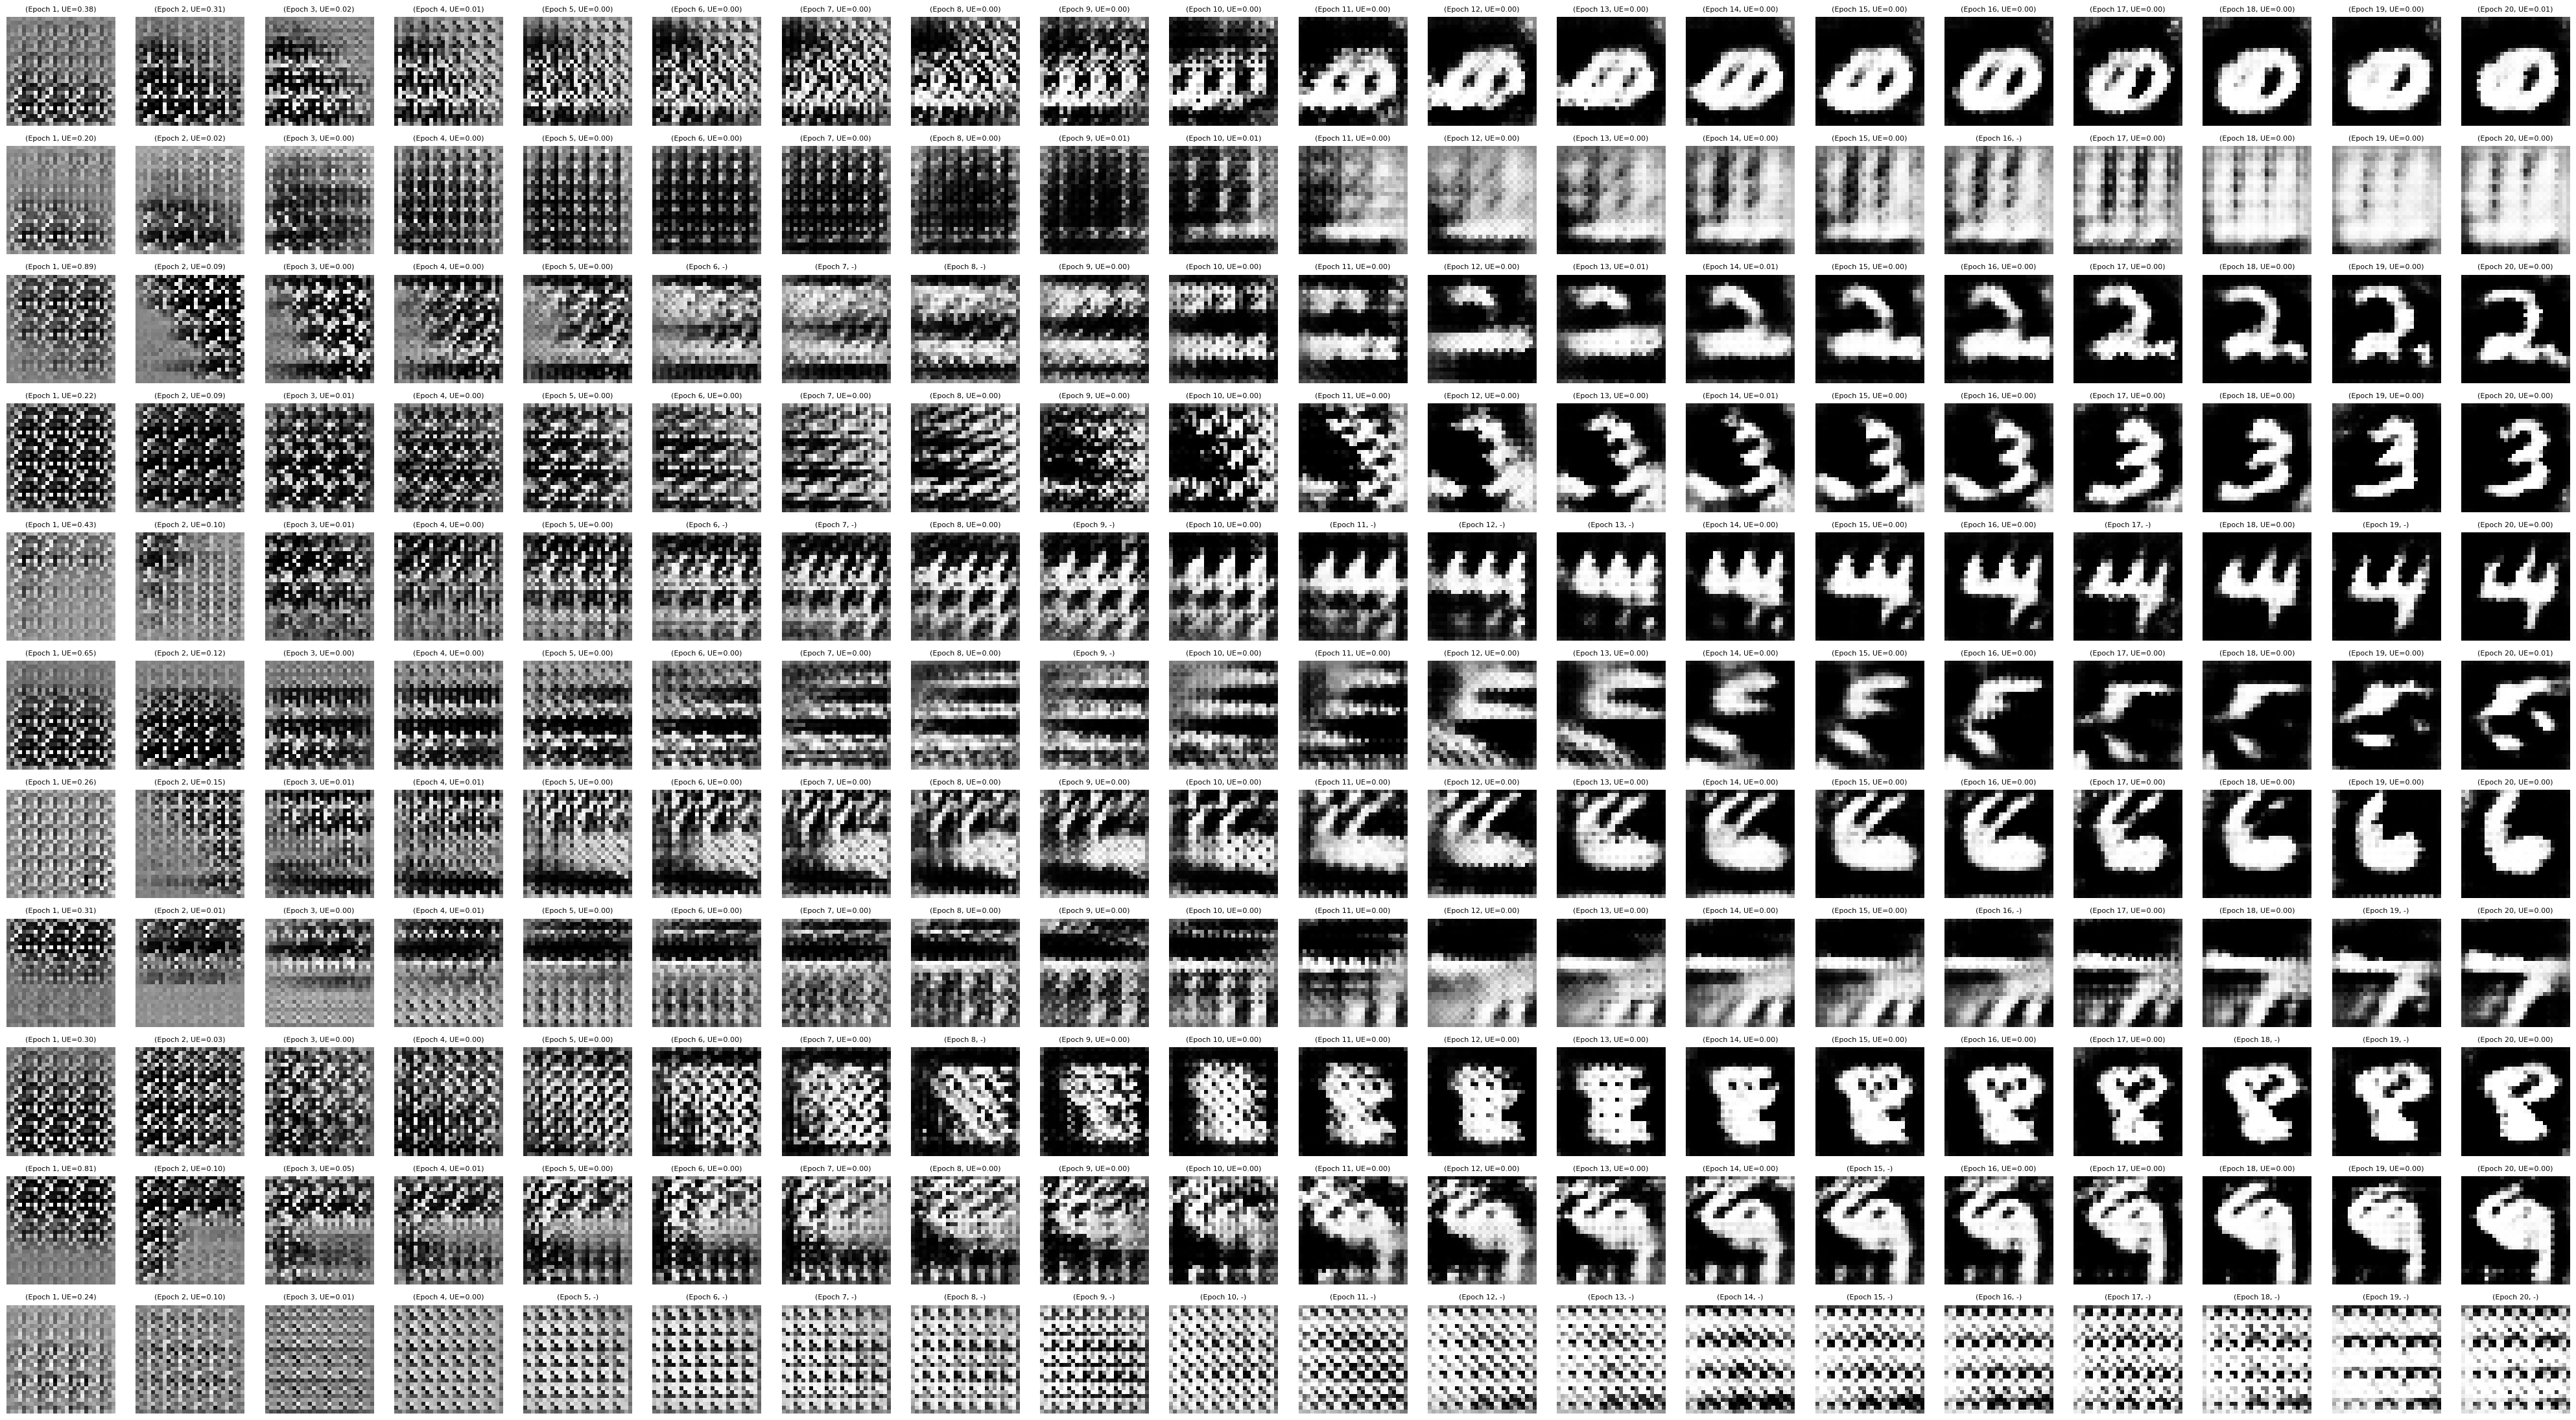

In [ ]:
visualization_dir = os.path.join(mydrive_mnist,f"EXP_{experiment_no}/visualization")
start_epoch=1
end_epoch=20

plot_epoch_class_grid(
    viz_dir= visualization_dir,
    n_classes=11,
    start_epoch=start_epoch,
    end_epoch=end_epoch,
)

##### Metrics

In [ ]:
def build_metric_df(metrics_storage, metric_name, n_classes):
    """
    Convert metrics_storage into a DataFrame for one metric
    Rows = epochs, Columns = classes
    """
    data = {}
    for epoch, metrics in metrics_storage.items():
        values = metrics[metric_name]
        data[epoch+1] = values
    df = pd.DataFrame.from_dict(data, orient="index", columns=[f"Class_{i}" for i in range(n_classes)])
    df.index.name = "Epoch"
    return df

In [ ]:
# Load saved metrics
metrics_storage = np.load(os.path.join(saved_model_dir, 'metrics_storage.npy'), allow_pickle=True).item()

# Build one dataframe per metric
n_classes = len(next(iter(metrics_storage.values()))["conf_mean"])  # infer class count

conf_df    = build_metric_df(metrics_storage, "conf_mean", n_classes)
ue_df      = build_metric_df(metrics_storage, "ue_mean", n_classes)
entropy_df = build_metric_df(metrics_storage, "entropy_mean", n_classes)
margin_df  = build_metric_df(metrics_storage, "margin_mean", n_classes)

# Save to CSV
conf_df.to_csv(os.path.join(saved_model_dir,'conf_mean.csv'))
ue_df.to_csv(os.path.join(saved_model_dir, 'ue_mean.csv'))
entropy_df.to_csv(os.path.join(saved_model_dir, 'entropy_mean.csv'))
margin_df.to_csv(os.path.join(saved_model_dir, 'margin_mean.csv'))

In [ ]:
def plot_metric_across_epochs(metric,metric_df):
  # Plot conf per class across epochs
  plt.figure(figsize=(8,4))
  for c in metric_df.columns:
      plt.plot(metric_df.index, metric_df[c], label=c)
  plt.xlabel("Epoch")
  plt.ylabel("Conf Mean")
  plt.title(f"{metric} per Class across Epochs")
  plt.legend()
  plt.xticks(metric_df.index.astype(int))
  plt.show()

In [ ]:
conf_df

Class_0  Class_1  Class_2  Class_3  Class_4  Class_5  Class_6  Class_7  \
Epoch                                                                           
1       0.7997   0.9037   0.3358   0.8905   0.7673   0.5730   0.8680   0.8418   
2       0.8451   0.9912   0.9585   0.9583   0.9536   0.9431   0.9303   0.9963   
3       0.9908   0.9997   0.9980   0.9962   0.9971   0.9979   0.9962   0.9981   
4       0.9942   0.9987   0.9995   0.9994   0.9991   0.9991   0.9953   0.9965   
5       0.9988   0.9989   0.9999   0.9996   0.9999   0.9998   0.9978   0.9994   
6       0.9995   0.9998   1.0000   0.9999   1.0000   0.9998   0.9995   0.9994   
7       0.9990   0.9997   1.0000   0.9999   1.0000   0.9999   0.9998   0.9996   
8       0.9988   0.9995   1.0000   0.9999   1.0000   1.0000   0.9999   0.9997   
9       0.9998   0.9976   1.0000   0.9999   1.0000   1.0000   0.9999   0.9999   
10      0.9998   0.9964   0.9994   0.9994   1.0000   1.0000   0.9999   0.9993   
11      0.9996   0.9990   0.9999   0.9994   1.0000   0.9998   0.9999   0.9993   
12      0.9991   0.9989   0.9998   0.9996   1.0000   0.9999   0.9998   0.9988   
13      0.9997   0.9990   0.9956   0.9998   1.0000   0.9998   0.9997   0.9998   
14      0.9996   0.9994   0.9934   0.9975   0.9993   0.9985   0.9999   0.9999   
15      0.9994   0.9999   0.9986   0.9996   0.9998   0.9999   0.9998   0.9999   
16      0.9998   1.0000   0.9987   0.9996   0.9999   0.9990   0.9996   1.0000   
17      0.9999   0.9999   0.9995   0.9996   1.0000   0.9994   0.9996   0.9996   
18      0.9999   1.0000   0.9992   0.9995   0.9999   0.9995   0.9995   0.9997   
19      0.9997   0.9999   0.9992   0.9996   1.0000   0.9993   0.9992   1.0000   
20      0.9963   0.9998   0.9999   0.9985   0.9996   0.9968   0.9984   0.9990   

       Class_8  Class_9  Class_10  
Epoch                              
1       0.8470   0.3709    0.8798  
2       0.9872   0.9552    0.9545  
3       0.9990   0.9772    0.9961  
4       0.9999   0.9965    0.9998  
5       0.9999   0.9989    1.0000  
6       0.9998   0.9991    1.0000  
7       0.9998   0.9992    1.0000  
8       1.0000   0.9995    1.0000  
9       1.0000   0.9999    1.0000  
10      0.9999   0.9993    1.0000  
11      0.9995   0.9998    1.0000  
12      0.9996   0.9997    1.0000  
13      1.0000   0.9998    1.0000  
14      0.9996   1.0000    1.0000  
15      0.9998   1.0000    1.0000  
16      0.9991   0.9999    1.0000  
17      0.9999   0.9999    1.0000  
18      1.0000   0.9999    1.0000  
19      1.0000   0.9999    1.0000  
20      0.9988   0.9999    1.0000

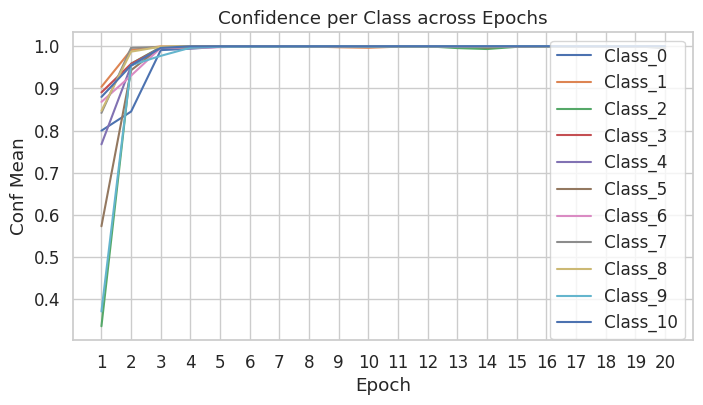

In [ ]:
plot_metric_across_epochs('Confidence',conf_df)

In [ ]:
margin_df

Class_0  Class_1  Class_2  Class_3  Class_4  Class_5  Class_6  Class_7  \
Epoch                                                                           
1       0.6819   0.8617   0.1322   0.8465   0.6732   0.2993   0.8004   0.7809   
2       0.7881   0.9863   0.9413   0.9410   0.9355   0.9179   0.9063   0.9947   
3       0.9882   0.9995   0.9973   0.9937   0.9960   0.9973   0.9948   0.9973   
4       0.9908   0.9979   0.9993   0.9991   0.9987   0.9988   0.9925   0.9955   
5       0.9983   0.9986   0.9999   0.9995   0.9998   0.9997   0.9965   0.9992   
6       0.9992   0.9998   1.0000   0.9998   1.0000   0.9997   0.9991   0.9991   
7       0.9984   0.9996   1.0000   0.9999   1.0000   0.9998   0.9997   0.9995   
8       0.9982   0.9991   1.0000   0.9999   0.9999   0.9999   0.9999   0.9996   
9       0.9998   0.9960   1.0000   0.9999   1.0000   1.0000   0.9998   0.9998   
10      0.9997   0.9943   0.9990   0.9992   1.0000   0.9999   0.9998   0.9989   
11      0.9994   0.9986   0.9998   0.9992   1.0000   0.9996   0.9998   0.9989   
12      0.9986   0.9984   0.9998   0.9996   1.0000   0.9999   0.9997   0.9983   
13      0.9996   0.9981   0.9918   0.9996   1.0000   0.9997   0.9994   0.9998   
14      0.9995   0.9991   0.9869   0.9967   0.9986   0.9975   0.9998   0.9998   
15      0.9991   0.9998   0.9974   0.9993   0.9998   0.9999   0.9997   0.9999   
16      0.9997   1.0000   0.9976   0.9993   0.9998   0.9987   0.9994   1.0000   
17      0.9999   0.9999   0.9992   0.9993   1.0000   0.9988   0.9994   0.9993   
18      0.9999   0.9999   0.9985   0.9990   0.9998   0.9990   0.9993   0.9995   
19      0.9995   0.9999   0.9986   0.9995   1.0000   0.9987   0.9988   1.0000   
20      0.9933   0.9996   0.9999   0.9975   0.9993   0.9940   0.9974   0.9980   

       Class_8  Class_9  Class_10  
Epoch                              
1       0.7455   0.0781    0.8312  
2       0.9824   0.9316    0.9416  
3       0.9986   0.9684    0.9939  
4       0.9999   0.9938    0.9997  
5       0.9999   0.9985    1.0000  
6       0.9996   0.9988    1.0000  
7       0.9998   0.9985    1.0000  
8       1.0000   0.9991    1.0000  
9       1.0000   0.9998    1.0000  
10      0.9999   0.9987    1.0000  
11      0.9992   0.9998    1.0000  
12      0.9994   0.9996    1.0000  
13      0.9999   0.9997    1.0000  
14      0.9995   1.0000    1.0000  
15      0.9996   1.0000    1.0000  
16      0.9984   0.9999    1.0000  
17      0.9999   0.9999    1.0000  
18      1.0000   0.9998    1.0000  
19      1.0000   0.9999    1.0000  
20      0.9983   0.9998    1.0000

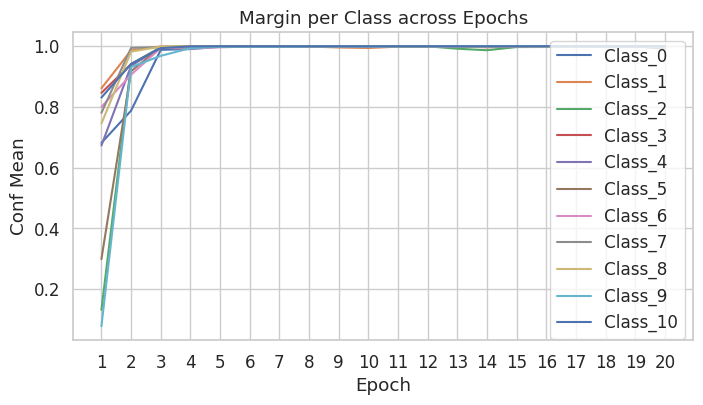

In [ ]:
plot_metric_across_epochs('Margin',margin_df)

In [ ]:
ue_df

Class_0  Class_1  Class_2  Class_3  Class_4  Class_5  Class_6  Class_7  \
Epoch                                                                           
1       0.3794   0.1987   0.8919   0.2239   0.4335   0.6516   0.2637   0.3139   
2       0.3069   0.0193   0.0890   0.0892   0.0990   0.1206   0.1467   0.0080   
3       0.0202   0.0007   0.0044   0.0084   0.0063   0.0045   0.0082   0.0041   
4       0.0127   0.0029   0.0011   0.0013   0.0019   0.0020   0.0104   0.0076   
5       0.0026   0.0023   0.0001   0.0008   0.0003   0.0004   0.0049   0.0013   
6       0.0011   0.0003   0.0000   0.0003   0.0000   0.0004   0.0012   0.0014   
7       0.0023   0.0006   0.0000   0.0001   0.0000   0.0003   0.0005   0.0008   
8       0.0027   0.0012   0.0000   0.0002   0.0001   0.0001   0.0002   0.0007   
9       0.0004   0.0053   0.0001   0.0002   0.0000   0.0000   0.0002   0.0003   
10      0.0004   0.0079   0.0013   0.0013   0.0001   0.0001   0.0003   0.0016   
11      0.0010   0.0021   0.0002   0.0014   0.0000   0.0004   0.0002   0.0016   
12      0.0019   0.0025   0.0004   0.0008   0.0000   0.0001   0.0004   0.0027   
13      0.0008   0.0021   0.0096   0.0005   0.0000   0.0004   0.0007   0.0003   
14      0.0008   0.0013   0.0145   0.0055   0.0016   0.0032   0.0002   0.0003   
15      0.0014   0.0003   0.0030   0.0010   0.0004   0.0001   0.0004   0.0002   
16      0.0005   0.0000   0.0027   0.0008   0.0002   0.0022   0.0008   0.0000   
17      0.0001   0.0001   0.0010   0.0009   0.0000   0.0014   0.0008   0.0009   
18      0.0002   0.0001   0.0018   0.0012   0.0002   0.0011   0.0010   0.0006   
19      0.0006   0.0002   0.0017   0.0008   0.0000   0.0015   0.0017   0.0000   
20      0.0080   0.0005   0.0002   0.0033   0.0008   0.0070   0.0035   0.0022   

       Class_8  Class_9  Class_10  
Epoch                              
1       0.2984   0.8145    0.2436  
2       0.0280   0.0956    0.0973  
3       0.0023   0.0494    0.0085  
4       0.0001   0.0078    0.0005  
5       0.0001   0.0023    0.0000  
6       0.0005   0.0020    0.0000  
7       0.0003   0.0018    0.0000  
8       0.0000   0.0012    0.0000  
9       0.0001   0.0002    0.0000  
10      0.0001   0.0015    0.0000  
11      0.0011   0.0004    0.0000  
12      0.0010   0.0006    0.0000  
13      0.0001   0.0004    0.0000  
14      0.0008   0.0001    0.0000  
15      0.0005   0.0000    0.0000  
16      0.0019   0.0001    0.0000  
17      0.0002   0.0002    0.0000  
18      0.0000   0.0003    0.0000  
19      0.0000   0.0002    0.0000  
20      0.0027   0.0003    0.0000

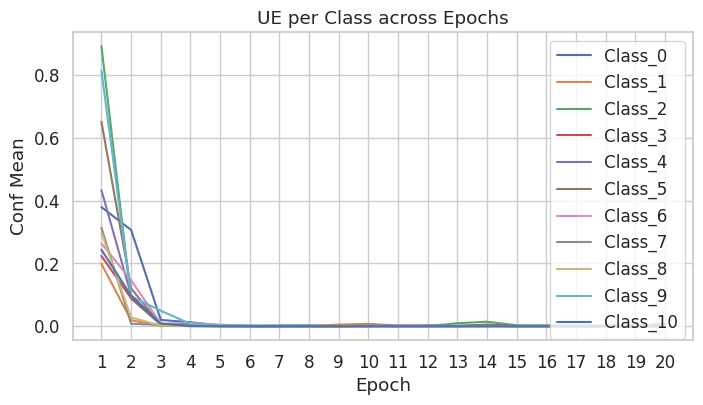

In [ ]:
plot_metric_across_epochs('UE',ue_df)

In [ ]:
entropy_df

Class_0  Class_1  Class_2  Class_3  Class_4  Class_5  Class_6  Class_7  \
Epoch                                                                           
1       0.7657   0.4681   1.9575   0.5076   0.9141   1.2666   0.5483   0.7079   
2       0.6571   0.0614   0.2516   0.2286   0.2585   0.3048   0.3572   0.0296   
3       0.0696   0.0032   0.0178   0.0297   0.0243   0.0188   0.0306   0.0164   
4       0.0435   0.0118   0.0054   0.0059   0.0081   0.0089   0.0362   0.0290   
5       0.0112   0.0097   0.0006   0.0037   0.0014   0.0019   0.0186   0.0061   
6       0.0048   0.0017   0.0002   0.0015   0.0002   0.0020   0.0053   0.0061   
7       0.0097   0.0028   0.0002   0.0007   0.0001   0.0014   0.0023   0.0039   
8       0.0114   0.0050   0.0002   0.0009   0.0005   0.0006   0.0011   0.0033   
9       0.0019   0.0189   0.0004   0.0009   0.0000   0.0003   0.0013   0.0013   
10      0.0022   0.0279   0.0057   0.0059   0.0003   0.0005   0.0014   0.0069   
11      0.0047   0.0090   0.0010   0.0062   0.0001   0.0019   0.0013   0.0068   
12      0.0082   0.0103   0.0020   0.0039   0.0002   0.0008   0.0019   0.0113   
13      0.0037   0.0081   0.0304   0.0026   0.0001   0.0016   0.0031   0.0017   
14      0.0037   0.0054   0.0407   0.0214   0.0060   0.0122   0.0011   0.0013   
15      0.0064   0.0012   0.0113   0.0043   0.0017   0.0007   0.0019   0.0009   
16      0.0025   0.0002   0.0099   0.0035   0.0012   0.0097   0.0038   0.0001   
17      0.0008   0.0006   0.0043   0.0039   0.0000   0.0055   0.0036   0.0036   
18      0.0013   0.0004   0.0074   0.0050   0.0011   0.0043   0.0045   0.0025   
19      0.0030   0.0009   0.0070   0.0036   0.0003   0.0058   0.0073   0.0002   
20      0.0269   0.0025   0.0009   0.0128   0.0032   0.0229   0.0136   0.0079   

       Class_8  Class_9  Class_10  
Epoch                              
1       0.6028   1.6117    0.5350  
2       0.0893   0.2441    0.2610  
3       0.0100   0.1466    0.0302  
4       0.0007   0.0268    0.0027  
5       0.0007   0.0099    0.0001  
6       0.0026   0.0088    0.0002  
7       0.0017   0.0075    0.0001  
8       0.0003   0.0052    0.0000  
9       0.0004   0.0012    0.0000  
10      0.0007   0.0057    0.0000  
11      0.0051   0.0018    0.0000  
12      0.0045   0.0030    0.0000  
13      0.0005   0.0019    0.0001  
14      0.0041   0.0004    0.0000  
15      0.0027   0.0001    0.0000  
16      0.0075   0.0007    0.0000  
17      0.0010   0.0009    0.0000  
18      0.0003   0.0015    0.0000  
19      0.0001   0.0009    0.0000  
20      0.0111   0.0015    0.0000

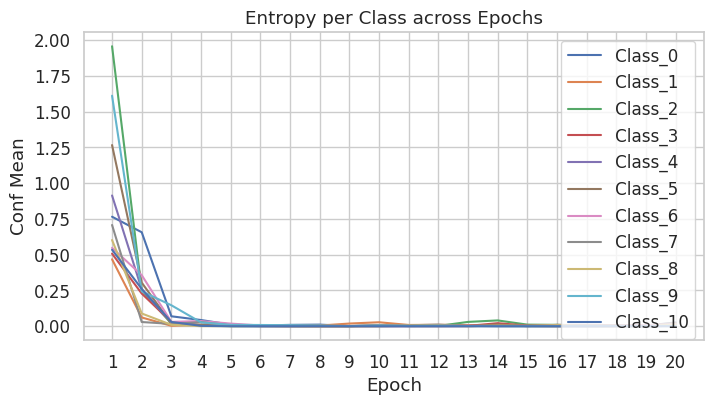

In [ ]:
plot_metric_across_epochs('Entropy',entropy_df)

---

##### Evaluation

In [ ]:
def eval_ood_classification(model, data_loader, device, garbage_class_idx=10):
    model.eval()
    total = 0
    garbage_preds = 0

    id_confidences, id_ue, id_entropy, id_margin = [], [], [], []
    ood_confidences, ood_ue, ood_entropy, ood_margin = [], [], [], []
    all_preds = []

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            logits, features = model(images)
            probs = F.softmax(logits, dim=1)
            confidence, preds = torch.max(probs, dim=1)
            conf, margin, ue, entropy  = compute_metrics(logits)

            for p, c,  m, u, e in zip(preds.cpu().numpy(),
                                     confidence.cpu().numpy(),
                                     margin.cpu().numpy(),
                                     ue.cpu().numpy(),
                                     entropy.cpu().numpy()):

                if p == garbage_class_idx:
                    ood_confidences.append(c)
                    ood_margin.append(m)
                    ood_ue.append(u)
                    ood_entropy.append(e)

                else:
                    id_confidences.append(c)
                    id_margin.append(m)
                    id_ue.append(u)
                    id_entropy.append(e)

                all_preds.append(p)

            garbage_preds += (preds == garbage_class_idx).sum().item()
            total += images.size(0)

    garbage_rate = garbage_preds / total

    return {
        "garbage_rate": garbage_rate,
        "all_preds": all_preds,
        "id": {
            "confidence": id_confidences,
            "ue": id_ue,
            "entropy": id_entropy,
            "margin": id_margin,},
        "ood": {
            "confidence": ood_confidences,
            "ue": ood_ue,
            "entropy": ood_entropy,
            "margin": ood_margin,}
           }

In [ ]:
def garbage_rate_table(datasets_eval):
  garbage_table = pd.DataFrame({
    "Dataset": list(datasets_eval.keys()),
    "Garbage Rate (%)": [round(eval_dict['garbage_rate']*100, 3) for eval_dict in datasets_eval.values()]})

  print("Garbage Rate Table")
  display(garbage_table)

In [ ]:
def metric_table(metric):
  table = {
        "Dataset": [],
        "ID Min": [], "ID Max": [], "ID Mean": [], "ID Std": [],
        "OOD Min": [], "OOD Max": [], "OOD Mean": [], "OOD Std": []
    }

  for name, eval_dict in datasets_eval.items():
      id_vals  = np.array(eval_dict['id'][metric])
      ood_vals = np.array(eval_dict['ood'][metric])

      table["Dataset"].append(name)
      table["ID Min"].append(np.min(id_vals) if len(id_vals) > 0 else np.nan)
      table["ID Max"].append(np.max(id_vals) if len(id_vals) > 0 else np.nan)
      table["ID Mean"].append(np.mean(id_vals) if len(id_vals) > 0 else np.nan)
      table["ID Std"].append(np.std(id_vals) if len(id_vals) > 0 else np.nan)

      table["OOD Min"].append(np.min(ood_vals) if len(ood_vals) > 0 else np.nan)
      table["OOD Max"].append(np.max(ood_vals) if len(ood_vals) > 0 else np.nan)
      table["OOD Mean"].append(np.mean(ood_vals) if len(ood_vals) > 0 else np.nan)
      table["OOD Std"].append(np.std(ood_vals) if len(ood_vals) > 0 else np.nan)

  df = pd.DataFrame(table)
  print(f"\n Metric: {metric.upper()}")
  display(df)
  # return df

In [ ]:
def garbage_rate_after_metric_threshold(model, data_loader, device, metric_name, threshold, garbage_class_idx=10):
    """Compute garbage rate given a metric and threshold"""
    model.eval()
    total = 0
    garbage_preds = 0

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            logits, _ = model(images)
            probs = F.softmax(logits, dim=1)
            confidence, preds = torch.max(probs, dim=1)

            # Compute metrics
            conf, margin, ue, entropy = compute_metrics(logits)

            metric_values = {
                "confidence": conf,
                "margin": margin,
                "ue": ue,
                "entropy": entropy
            }[metric_name]

            for p, m in zip(preds.cpu().numpy(), metric_values.cpu().numpy()):
                # Threshold rule
                if metric_name in ["confidence", "margin"]:
                    if p != garbage_class_idx:
                      if m < threshold:
                        garbage_preds += 1
                    else:
                        garbage_preds +=1
                else:  # entropy, ue → higher = OOD
                    if p != garbage_class_idx:
                      if m > threshold:
                        garbage_preds += 1
                    else:
                        garbage_preds +=1

            total += images.size(0)

    garbage_rate = garbage_preds / total
    return garbage_rate

In [ ]:
def garbage_rate_metric_threshold_table(model, datasets, device, metric_name, thresholds):
    results = []

    for t in thresholds:
        row = {"Threshold": t}
        for name, loader in datasets.items():
            rate = garbage_rate_after_metric_threshold(model, loader, device, metric_name, t)
            row[name] = rate * 100
        results.append(row)

    df = pd.DataFrame(results)

    # Format all numeric values to 2 decimal places
    df = df.round(2)

    print(f"\n Garbage Rate Table (in %): [{metric_name} Threshold]")
    display(df)

---

##### Tiny_Imagenet_200

In [ ]:
# folder_path = "/content/data/tiny-imagenet-200"
# # Check if folder exists before deleting
# if os.path.exists(folder_path) and os.path.isdir(folder_path):
#     shutil.rmtree(folder_path)
#     print(f"Deleted folder: {folder_path}")
# else:
#     print("Folder does not exist!")

Deleted folder: /content/data/tiny-imagenet-200


In [40]:
! wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
! unzip tiny-imagenet-200.zip -d /content/ood_datasets

Streaming output truncated to the last 5000 lines.
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: /content/ood_datasets/tiny-imagenet-200/val/images/val_9

In [41]:
val_dir = "/content/ood_datasets/tiny-imagenet-200/val"
images_dir = os.path.join(val_dir, "images")
ann_file = os.path.join(val_dir, "val_annotations.txt")

with open(ann_file, "r") as f:
    for line in f.readlines():
        img, cls = line.strip().split("\t")[:2]
        cls_dir  = os.path.join(val_dir, cls)
        os.makedirs(cls_dir, exist_ok=True)
        shutil.move(os.path.join(images_dir, img), os.path.join(cls_dir, img))

shutil.rmtree(images_dir)

#### Using mnist Statistics for all ood datasets

In [42]:
# MNIST normalization stats
mnist_mean  = 0.1307
mnist_std   = 0.3081

# Transform for ood datasets
ood_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std)
])

In [43]:
# ------------------ Grayscale datasets ------------------
fmnist_testset  = datasets.FashionMNIST(root='/content/ood_datasets/FMNIST', train=False, download=True, transform=ood_transform)

# ------------------ RGB datasets ------------------
cifar10_testset     = datasets.CIFAR10(root='/content/ood_datasets/CIFAR10', train= False, download=True, transform=ood_transform)
svhn_testset        = datasets.SVHN(root='/content/ood_datasets/SVHN', split='test', download=True, transform=ood_transform)
cifar100_testset    = datasets.CIFAR100(root='/content/ood_datasets/CIFAR100', train=False, download=True, transform=ood_transform)

# TinyImageNet (resize to 32×32) – validation split
tinyimagenet_val    = datasets.ImageFolder(root='/content/ood_datasets/tiny-imagenet-200/val', transform=ood_transform)

# # LSUN (classroom / resize) – one or more classes
# lsun_val            = datasets.ImageFolder(root=os.path.join(lsun_data_dir, "classroom_val"), transform=ood_transform)

# CelebA – center crop then resize
# celeba_val          = datasets.CelebA(root='/content/ood_datasets', split='test', download=True,
#                                       transform=transforms.Compose([
#                                           transforms.CenterCrop(148),
#                                           transforms.Resize((32, 32)),
#                                           transforms.ToTensor(),
#                                           transforms.Normalize(cifar_mean, cifar_std)
#                                       ]))


100%|██████████| 26.4M/26.4M [00:01<00:00, 21.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 338kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.20MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.7MB/s]
100%|██████████| 170M/170M [00:01<00:00, 88.5MB/s]
100%|██████████| 64.3M/64.3M [00:05<00:00, 10.7MB/s]
100%|██████████| 169M/169M [00:02<00:00, 58.4MB/s]


In [44]:
# ------------------ DataLoaders ------------------
batch_size = 32
fmnist_loader      = DataLoader(fmnist_testset,     batch_size=batch_size, shuffle=False)
cifar10_loader     = DataLoader(cifar10_testset,    batch_size=batch_size, shuffle=False)
svhn_loader        = DataLoader(svhn_testset,       batch_size=batch_size, shuffle=False)
cifar100_loader    = DataLoader(cifar100_testset,   batch_size=batch_size, shuffle=False)
tiny_loader        = DataLoader(tinyimagenet_val,   batch_size=batch_size, shuffle=False)
# lsun_loader      = DataLoader(lsun_val,           batch_size=batch_size, shuffle=False)
# celeba_loader    = DataLoader(celeba_val,       batch_size=batch_size, shuffle=False)

#### Before Inversion

In [ ]:
model_before_inv_pth = os.path.join(saved_model_dir, "checkpoint_csf_initial.pt")
checkpoint = torch.load(model_before_inv_pth,map_location='cpu')
nc = 1
ncf = 64

model_before_inv = Classifier(nc, ncf)
model_before_inv.load_state_dict(checkpoint['model_state_dict'])
model_before_inv.to(device)
model_before_inv.eval()

Classifier(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): AdaptiveAvgPool2d(output_size=1)
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (penultimate): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  

In [ ]:
csf_criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy   = test(model_before_inv,  test_loader, csf_criterion, device)
print(f"\nTest Loss:{test_loss:.4f},  Test Accuracy: {test_accuracy:.4f}")

Testing: 100%|██████████| 313/313 [00:05<00:00, 55.26it/s, Batch Loss=0.0715]


Test Loss:0.1151,  Test Accuracy: 0.9687


In [ ]:
eval_mnist      = eval_ood_classification(model_before_inv, test_loader, device)
eval_fmnist     = eval_ood_classification(model_before_inv, fmnist_loader,  device)
eval_cifar10    = eval_ood_classification(model_before_inv, cifar10_loader,  device)
eval_svhn       = eval_ood_classification(model_before_inv, svhn_loader,   device)
eval_cifar100   = eval_ood_classification(model_before_inv, cifar100_loader,   device)
eval_tiny_imagenet200  = eval_ood_classification(model_before_inv, tiny_loader, device)
# eval_celeba     = eval_ood_classification(model_before_inv, celeba_loader,   device)

In [ ]:
# List of datasets
datasets_eval = {
    "MNIST": eval_mnist,
    "FashionMNIST": eval_fmnist,
    "CIFAR-10": eval_cifar10,
    "SVHN": eval_svhn,
    "CIFAR-100": eval_cifar100,
    "TinyImageNet200": eval_tiny_imagenet200,
    # "CelebA": eval_celeba,
}

In [ ]:
garbage_rate_table(datasets_eval)

Garbage Rate Table


Dataset  Garbage Rate (%)
0            MNIST             0.000
1     FashionMNIST            31.110
2         CIFAR-10            98.560
3             SVHN            95.809
4        CIFAR-100            97.140
5  TinyImageNet200            96.810

In [ ]:
metric_table('confidence')


 Metric: CONFIDENCE


Dataset    ID Min    ID Max   ID Mean    ID Std   OOD Min  \
0            MNIST  0.219684  0.999907  0.941615  0.118614       NaN   
1     FashionMNIST  0.211356  0.999998  0.645648  0.191239  0.176835   
2         CIFAR-10  0.216246  0.968912  0.564332  0.157469  0.272077   
3             SVHN  0.319011  0.962742  0.649921  0.116139  0.340071   
4        CIFAR-100  0.214934  0.960205  0.598817  0.158660  0.267089   
5  TinyImageNet200  0.230242  0.992130  0.589784  0.170557  0.252581   

    OOD Max  OOD Mean   OOD Std  
0       NaN       NaN       NaN  
1  0.998928  0.753343  0.201551  
2  0.999303  0.951040  0.079136  
3  0.998001  0.918589  0.099253  
4  0.999510  0.939791  0.095554  
5  0.999659  0.948822  0.090046

In [ ]:
metric_table('margin')


 Metric: MARGIN


Dataset    ID Min    ID Max   ID Mean    ID Std   OOD Min  \
0            MNIST  0.000971  0.999871  0.906329  0.190513       NaN   
1     FashionMNIST  0.000063  0.999997  0.452794  0.288933  0.001201   
2         CIFAR-10  0.001125  0.951194  0.289813  0.247413  0.000291   
3             SVHN  0.000931  0.944800  0.326024  0.214116  0.000953   
4        CIFAR-100  0.002523  0.936081  0.316077  0.251073  0.004031   
5  TinyImageNet200  0.001527  0.990226  0.331101  0.264815  0.000166   

    OOD Max  OOD Mean   OOD Std  
0       NaN       NaN       NaN  
1  0.998373  0.604370  0.315955  
2  0.999032  0.915190  0.135247  
3  0.997040  0.847749  0.190791  
4  0.999357  0.892397  0.172688  
5  0.999544  0.912034  0.154289

In [ ]:
metric_table('ue')


 Metric: UE


Dataset    ID Min    ID Max   ID Mean    ID Std   OOD Min  \
0            MNIST  0.000205  0.928912  0.100253  0.173317       NaN   
1     FashionMNIST  0.000004  0.945538  0.530332  0.226740  0.002357   
2         CIFAR-10  0.066922  0.907345  0.606462  0.168031  0.001533   
3             SVHN  0.079920  0.851894  0.489411  0.107215  0.004392   
4        CIFAR-100  0.085097  0.912813  0.560186  0.170852  0.001078   
5  TinyImageNet200  0.017234  0.922731  0.579638  0.191451  0.000751   

    OOD Max  OOD Mean   OOD Std  
0       NaN       NaN       NaN  
1  0.941319  0.381060  0.258903  
2  0.883389  0.092518  0.123436  
3  0.841092  0.145559  0.143081  
4  0.919983  0.108546  0.142902  
5  0.899822  0.093800  0.138340

In [ ]:
metric_table('entropy')


 Metric: ENTROPY


Dataset    ID Min    ID Max   ID Mean    ID Std   OOD Min  \
0            MNIST  0.001097  2.015171  0.209842  0.314721       NaN   
1     FashionMNIST  0.000027  2.129829  0.996455  0.429719  0.009933   
2         CIFAR-10  0.179564  1.855930  1.069095  0.338712  0.006919   
3             SVHN  0.208453  1.619903  0.694830  0.176820  0.016415   
4        CIFAR-100  0.219272  1.858533  0.942139  0.366039  0.005172   
5  TinyImageNet200  0.060418  1.943999  1.024798  0.387482  0.003680   

    OOD Max  OOD Mean   OOD Std  
0       NaN       NaN       NaN  
1  2.026413  0.719844  0.467439  
2  1.777249  0.193715  0.213685  
3  1.683956  0.261556  0.199781  
4  1.946264  0.212934  0.231614  
5  1.918315  0.193652  0.239337

### After Inversion

##### Evaluating the model with best test accuracy

In [57]:
model_after_inv_pth = os.path.join(saved_model_dir,'csf_model.pth')
nc = 1
ncf = 64

model_after_inv = Classifier(nc, ncf)
model_after_inv.load_state_dict(torch.load(model_after_inv_pth, map_location=device))
model_after_inv.to(device)
model_after_inv.eval()

Classifier(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): AdaptiveAvgPool2d(output_size=1)
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (penultimate): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  

In [ ]:
test_loss, test_accuracy   = test(model_after_inv,  test_loader, csf_criterion, device)
print(f"\nTest Loss:{test_loss:.4f},  Test Accuracy: {test_accuracy:.4f}")

Testing: 100%|██████████| 313/313 [00:05<00:00, 58.73it/s, Batch Loss=0.000429]


Test Loss:0.0268,  Test Accuracy: 0.9915


In [ ]:
eval_mnist      = eval_ood_classification(model_after_inv, test_loader, device)
eval_fmnist     = eval_ood_classification(model_after_inv, fmnist_loader,  device)
eval_cifar10    = eval_ood_classification(model_after_inv, cifar10_loader,  device)
eval_svhn       = eval_ood_classification(model_after_inv, svhn_loader,   device)
eval_cifar100   = eval_ood_classification(model_after_inv, cifar100_loader,   device)
eval_tiny_imagenet200  = eval_ood_classification(model_after_inv, tiny_loader, device)
# eval_celeba     = eval_ood_classification(model_before_inv, celeba_loader,   device)

In [ ]:
# List of datasets
datasets_eval = {
    "MNIST": eval_mnist,
    "FashionMNIST": eval_fmnist,
    "CIFAR-10": eval_cifar10,
    "SVHN": eval_svhn,
    "CIFAR-100": eval_cifar100,
    "TinyImageNet200": eval_tiny_imagenet200,
    # "CelebA": eval_celeba,
}

In [ ]:
garbage_rate_table(datasets_eval)

Garbage Rate Table


Dataset  Garbage Rate (%)
0            MNIST             0.020
1     FashionMNIST            82.810
2         CIFAR-10            93.650
3             SVHN            60.326
4        CIFAR-100            91.180
5  TinyImageNet200            93.200

In [ ]:
metric_table('confidence')


 Metric: CONFIDENCE


Dataset    ID Min    ID Max   ID Mean    ID Std   OOD Min  \
0            MNIST  0.278312  1.000000  0.993547  0.042863  0.476643   
1     FashionMNIST  0.227430  0.999989  0.753015  0.190733  0.296290   
2         CIFAR-10  0.366306  0.999992  0.886168  0.147977  0.423551   
3             SVHN  0.325680  0.999999  0.953284  0.104048  0.361608   
4        CIFAR-100  0.367959  0.999995  0.879278  0.152048  0.418238   
5  TinyImageNet200  0.300933  0.999999  0.872443  0.161909  0.390695   

    OOD Max  OOD Mean   OOD Std  
0  0.742373  0.609508  0.132865  
1  1.000000  0.947152  0.116298  
2  1.000000  0.988743  0.054846  
3  1.000000  0.971696  0.084336  
4  1.000000  0.983758  0.064737  
5  1.000000  0.986769  0.057586

In [ ]:
metric_table('margin')


 Metric: MARGIN


Dataset    ID Min    ID Max   ID Mean    ID Std   OOD Min  \
0            MNIST  0.005311  1.000000  0.988337  0.076086  0.098848   
1     FashionMNIST  0.000287  0.999982  0.579683  0.319612  0.000065   
2         CIFAR-10  0.010404  0.999988  0.781560  0.282702  0.004281   
3             SVHN  0.000160  0.999999  0.907476  0.206097  0.000269   
4        CIFAR-100  0.003599  0.999993  0.768113  0.291206  0.004269   
5  TinyImageNet200  0.000479  0.999998  0.759401  0.302955  0.005951   

    OOD Max  OOD Mean   OOD Std  
0  0.624891  0.361869  0.263021  
1  1.000000  0.907406  0.202769  
2  1.000000  0.978250  0.106295  
3  1.000000  0.943919  0.167041  
4  1.000000  0.968581  0.125475  
5  1.000000  0.974775  0.109752

In [ ]:
metric_table('ue')


 Metric: UE


Dataset    ID Min    ID Max   ID Mean    ID Std   OOD Min  \
0            MNIST  0.000000  0.853623  0.010711  0.063468  0.468219   
1     FashionMNIST  0.000024  0.898632  0.374476  0.243180  0.000000   
2         CIFAR-10  0.000017  0.815992  0.178606  0.201556  0.000000   
3             SVHN  0.000002  0.857726  0.074587  0.148292  0.000000   
4        CIFAR-100  0.000010  0.811448  0.187837  0.207085  0.000000   
5  TinyImageNet200  0.000002  0.835493  0.195724  0.217809  0.000000   

    OOD Max  OOD Mean   OOD Std  
0  0.672305  0.570262  0.102043  
1  0.837257  0.086875  0.170573  
2  0.739022  0.018194  0.079734  
3  0.732551  0.045126  0.121348  
4  0.749334  0.026406  0.094324  
5  0.752626  0.021974  0.085779

In [ ]:
metric_table('entropy')


 Metric: ENTROPY


Dataset        ID Min    ID Max   ID Mean    ID Std       OOD Min  \
0            MNIST  1.677575e-09  1.592463  0.019305  0.103004  8.616630e-01   
1     FashionMNIST  1.439779e-04  1.840348  0.638440  0.396878  3.851426e-20   
2         CIFAR-10  1.096819e-04  1.530887  0.278061  0.285166  2.440615e-19   
3             SVHN  1.325559e-05  1.668374  0.113982  0.203132  9.508898e-21   
4        CIFAR-100  6.824027e-05  1.446728  0.289045  0.289724  3.279252e-21   
5  TinyImageNet200  1.448104e-05  1.575509  0.308394  0.318883  1.001749e-22   

    OOD Max  OOD Mean   OOD Std  
0  1.036231  0.948947  0.087284  
1  1.574382  0.155456  0.281689  
2  1.381367  0.029675  0.116861  
3  1.267182  0.068501  0.168256  
4  1.399280  0.042678  0.138017  
5  1.296610  0.036638  0.130033

#### Applying Threshold

In [ ]:
datasets = {
    "MNIST": test_loader,
    "FashionMNIST": fmnist_loader,
    "CIFAR-10": cifar10_loader,
    "SVHN": svhn_loader,
    "CIFAR-100": cifar100_loader,
    "TinyImageNet200": tiny_loader,
    # "CelebA": celeba_loader,
}

##### Conf_Threshold

In [ ]:
conf_thresholds = [0.7,0.8,0.9,0.95]

In [ ]:
garbage_rate_metric_threshold_table(model_before_inv, datasets, device,"confidence", conf_thresholds)


 Garbage Rate Table (in %): [confidence Threshold]


Threshold  MNIST  FashionMNIST  CIFAR-10   SVHN  CIFAR-100  TinyImageNet200
0       0.70   5.99         71.81     99.73  98.57      99.24            99.21
1       0.80   9.09         82.23     99.83  99.47      99.63            99.55
2       0.90  15.00         91.98     99.95  99.96      99.92            99.83
3       0.95  23.13         96.49     99.99  99.99      99.99            99.93

In [ ]:
garbage_rate_metric_threshold_table(model_after_inv, datasets, device,"confidence", conf_thresholds)


 Garbage Rate Table (in %): [confidence Threshold]


Threshold  MNIST  FashionMNIST  CIFAR-10   SVHN  CIFAR-100  TinyImageNet200
0       0.70   0.79         89.46     94.60  62.56      92.65            94.41
1       0.80   1.13         91.87     95.11  64.01      93.47            95.02
2       0.90   1.83         94.73     95.95  66.23      94.48            95.86
3       0.95   2.58         96.43     96.62  68.19      95.39            96.39

##### Margin_Threshold

In [ ]:
margin_thresholds = [0.8, 0.9, 0.95]

In [ ]:
garbage_rate_metric_threshold_table(model_before_inv, datasets, device,"margin", margin_thresholds)


 Garbage Rate Table (in %): [margin Threshold]


Threshold  MNIST  FashionMNIST  CIFAR-10    SVHN  CIFAR-100  \
0       0.80  12.95         89.10     99.94   99.95      99.85   
1       0.90  20.12         95.21     99.99   99.98      99.96   
2       0.95  29.64         97.67     99.99  100.00     100.00   

   TinyImageNet200  
0            99.77  
1            99.91  
2            99.97

In [ ]:
garbage_rate_metric_threshold_table(model_after_inv, datasets, device,"margin", margin_thresholds)


 Garbage Rate Table (in %): [margin Threshold]


Threshold  MNIST  FashionMNIST  CIFAR-10   SVHN  CIFAR-100  TinyImageNet200
0       0.80   1.71         94.17     95.90  66.20      94.43            95.79
1       0.90   2.47         96.03     96.57  68.15      95.34            96.34
2       0.95   3.17         97.28     97.04  70.07      96.03            96.88

##### UE Threshold

In [ ]:
ue_thresholds = [0.01, 0.1,0.5,0.8]

In [ ]:
garbage_rate_metric_threshold_table(model_before_inv, datasets, device,"ue", ue_thresholds)


 Garbage Rate Table (in %): [ue Threshold]


Threshold  MNIST  FashionMNIST  CIFAR-10    SVHN  CIFAR-100  \
0       0.01  70.63         99.73    100.00  100.00     100.00   
1       0.10  24.08         96.77     99.99   99.99      99.99   
2       0.50   6.30         72.80     99.74   98.13      99.23   
3       0.80   0.68         38.43     98.70   95.83      97.39   

   TinyImageNet200  
0           100.00  
1            99.94  
2            99.21  
3            97.20

In [ ]:
garbage_rate_metric_threshold_table(model_after_inv, datasets, device,"ue", ue_thresholds)


 Garbage Rate Table (in %): [ue Threshold]


Threshold  MNIST  FashionMNIST  CIFAR-10   SVHN  CIFAR-100  TinyImageNet200
0       0.01   6.43         99.18     98.22  74.91      97.55            98.22
1       0.10   2.62         96.50     96.64  68.31      95.45            96.43
2       0.50   0.70         89.28     94.37  61.96      92.30            94.27
3       0.80   0.07         83.10     93.66  60.33      91.19            93.23

##### Entropy_Threshold

In [ ]:
entropy_thresholds = [0.01,0.05,0.1,0.5,0.8]

In [ ]:
garbage_rate_metric_threshold_table(model_before_inv, datasets, device,"entropy", entropy_thresholds)


 Garbage Rate Table (in %): [entropy Threshold]


Threshold  MNIST  FashionMNIST  CIFAR-10    SVHN  CIFAR-100  \
0       0.01  95.74         99.87    100.00  100.00     100.00   
1       0.05  60.67         99.59    100.00  100.00     100.00   
2       0.10  42.50         99.13    100.00  100.00     100.00   
3       0.50  13.25         90.37     99.93   99.62      99.75   
4       0.80   7.07         77.49     99.64   96.39      98.62   

   TinyImageNet200  
0           100.00  
1           100.00  
2            99.98  
3            99.72  
4            98.96

In [ ]:
garbage_rate_metric_threshold_table(model_after_inv, datasets, device,"entropy", entropy_thresholds)


 Garbage Rate Table (in %): [entropy Threshold]


Threshold  MNIST  FashionMNIST  CIFAR-10   SVHN  CIFAR-100  TinyImageNet200
0       0.01  10.52         99.72     98.98  78.61      98.34            98.94
1       0.05   5.30         98.84     97.94  73.06      97.24            97.83
2       0.10   3.80         98.04     97.27  70.66      96.39            97.22
3       0.50   1.33         93.48     95.21  64.17      93.63            95.17
4       0.80   0.46         88.85     93.87  60.44      91.51            93.64

### AUROC, AUPR, FPR@95TPR
* AUROC (Area Under ROC Curve) → measures overall separability between ID vs OOD.

* AUPR (Area Under Precision-Recall Curve) → emphasizes precision when positives are rare.

* FPR@95TPR → false positive rate when true positive rate = 95%.

---

##### Helper Functions

In [45]:
def compute_auroc_aupr_fpr95(id_scores, ood_scores):
    """
    Compute AUROC, AUPR, and FPR@95TPR
    Label convention: 0 = ID, 1 = OOD
    """
    y_true  = np.concatenate([np.zeros_like(id_scores), np.ones_like(ood_scores)])
    y_score = np.concatenate([id_scores, ood_scores])

    # AUROC
    try:
        auroc = roc_auc_score(y_true, y_score)
    except:
        auroc = np.nan

    # AUPR
    try:
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        aupr = auc(recall, precision)
    except:
        aupr = np.nan

    # FPR@95TPR
    try:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        idx = np.where(tpr >= 0.95)[0]
        fpr95 = fpr[idx[0]] if len(idx) > 0 else 1.0
    except:
        fpr95 = np.nan

    return round(auroc, 4), round(aupr, 4), round(fpr95, 4), fpr, tpr, precision, recall

In [46]:
def compute_mahalanobis_stats(model, loader, device):
    model.eval()
    all_feats, all_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            _,feats = model(x)
            all_feats.append(feats)
            all_labels.append(y)

    feats = torch.cat(all_feats)
    labels = torch.cat(all_labels)
    num_classes = len(torch.unique(labels))

    class_means = []
    for c in range(num_classes):
        class_feats = feats[labels == c]
        class_means.append(class_feats.mean(0))

    cov = torch.cov(feats.T)
    cov_inv = torch.inverse(cov + 1e-5 * torch.eye(cov.shape[0], device=device))

    return class_means, cov_inv

In [47]:
# Mahalanobis (requires precomputed class means + covariance inverse)
def score_mahalanobis(features, class_means, cov_inv):
    dists = []
    for mu_c in class_means:
        diff = features - mu_c
        dist = torch.einsum('bi,ij,bj->b', diff, cov_inv, diff)
        dists.append(dist)
    return -torch.min(torch.stack(dists, dim=1), dim=1)[0]  # negative = higher confidence

In [48]:
def get_metric_scores(exclude_garbage, model, data_loader, device, metric_name, temperature=1.0,
                               class_means=None, cov_inv=None):
    """
    Get metric scores for a dataset.
    Supports: confidence, margin, ue, entropy, energy, msp, odin, mahalanobis
    """
    model.eval()
    metric_scores = []

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            logits, feats = model(images)

            if exclude_garbage:
                logits = logits[:, :10]

            if metric_name in ["confidence", "margin", "ue", "entropy"]:
                confidence, margin, ue, entropy = compute_metrics(logits)
                metric_values = {
                    "confidence": confidence,
                    "margin": margin,
                    "ue": ue,
                    "entropy": entropy
                }[metric_name]

            elif metric_name == "energy":
                metric_values = -temperature * torch.logsumexp(logits / temperature, dim=1)

            elif metric_name == "msp":
                metric_values = torch.max(F.softmax(logits, dim=1), dim=1)[0]

            elif metric_name == "odin":
                metric_values = torch.max(F.softmax(logits / temperature, dim=1), dim=1)[0]

            elif metric_name == "mahalanobis":
                if class_means is None or cov_inv is None:
                    raise ValueError("class_means and cov_inv must be provided for Mahalanobis score")
                metric_values = score_mahalanobis(feats, class_means, cov_inv)

            else:
                raise ValueError(f"Unknown metric_name: {metric_name}")

            metric_scores.extend(metric_values.cpu().numpy())

    return np.array(metric_scores)

In [49]:
def comprehensive_ood_analysis(exclude_garbage, model, datasets, device, metric_name, id_name,
                                        temperature=1.0, class_means=None, cov_inv=None):
    """
    Comprehensive OOD analysis supporting multiple metrics including Mahalanobis.
    """
    if exclude_garbage:
        print(f"COMPREHENSIVE OOD ANALYSIS (Garbage class excluded) - {metric_name.upper()}")
    else:
        print(f"COMPREHENSIVE OOD ANALYSIS (Garbage class included) - {metric_name.upper()}")

    # Get ID scores
    id_scores = get_metric_scores(exclude_garbage, model, datasets[id_name], device,
                                           metric_name, temperature, class_means, cov_inv)

    results = []

    for ood_name, ood_loader in datasets.items():
        if ood_name == id_name:
            continue

        ood_scores = get_metric_scores(exclude_garbage, model, ood_loader, device,
                                                metric_name, temperature, class_means, cov_inv)

        flip_sign = -1 if metric_name in ["msp", "odin", "mahalanobis"] else 1
        id_eval = id_scores * flip_sign
        ood_eval = ood_scores * flip_sign

        auroc, aupr, fpr_95tpr, fpr, tpr, precision, recall = compute_auroc_aupr_fpr95(id_eval, ood_eval)
        id_mean = np.mean(id_scores)
        ood_mean = np.mean(ood_scores)
        separation = abs(id_mean - ood_mean)

        results.append({
            'OOD Dataset': ood_name,
            'AUROC': auroc,
            'AUPR': aupr,
            'FPR@95TPR': fpr_95tpr,
            f'ID {metric_name} Mean': round(id_mean, 4),
            f'OOD {metric_name} Mean': round(ood_mean, 4),
            'Separation': round(separation, 4),
            'FPR_curve': fpr,
            'TPR_curve': tpr,
            'Precision_curve': precision,
            'Recall_curve': recall,
            'ID_scores': id_scores,
            'OOD_scores':ood_scores
        })

    df_summary = pd.DataFrame([{k: r[k] for k in ['OOD Dataset', 'AUROC', 'AUPR', 'FPR@95TPR',
                                                  f'ID {metric_name} Mean', f'OOD {metric_name} Mean',
                                                  'Separation']} for r in results])
    display(df_summary)
    print(f"\nAvg AUROC = {df_summary['AUROC'].mean():.4f} | "
          f"Avg AUPR = {df_summary['AUPR'].mean():.4f} | "
          f"Avg FPR@95TPR = {df_summary['FPR@95TPR'].mean():.4f}")

    return df_summary, results

In [50]:
def plot_ood_metrics(df, metric_name):
    """
    Plots AUROC, AUPR, and FPR@95TPR results for OOD analysis
    """
    sns.set(style="whitegrid", font_scale=1.1)
    fig, axes = plt.subplots(1, 3, figsize=(25, 6))

    # --- AUROC ---
    sns.barplot(
        data=df,
        x="OOD Dataset",
        y="AUROC",
        ax=axes[0],
        palette="Blues_d",
        hue = "OOD Dataset",
        legend=False
    )
    axes[0].set_title(f"{metric_name.upper()} - AUROC", fontsize=14, fontweight='bold')
    axes[0].set_ylim(0, 1)
    for i, val in enumerate(df["AUROC"]):
        axes[0].text(i, val + 0.02, f"{val:.3f}", ha='center', fontsize=10)

    # --- AUPR ---
    sns.barplot(
        data=df,
        x="OOD Dataset",
        y="AUPR",
        ax=axes[1],
        palette="Greens_d",
         hue = "OOD Dataset",
        legend=False
    )
    axes[1].set_title(f"{metric_name.upper()} - AUPR", fontsize=14, fontweight='bold')
    axes[1].set_ylim(0, 1)
    for i, val in enumerate(df["AUPR"]):
        axes[1].text(i, val + 0.02, f"{val:.3f}", ha='center', fontsize=10)

    # --- FPR@95TPR ---
    sns.barplot(
        data=df,
        x="OOD Dataset",
        y="FPR@95TPR",
        ax=axes[2],
        palette="Reds_d",
        hue = "OOD Dataset",
        legend=False
    )
    axes[2].set_title(f"{metric_name.upper()} - FPR@95TPR", fontsize=14, fontweight='bold')
    axes[2].set_ylim(0, 1)
    for i, val in enumerate(df["FPR@95TPR"]):
        axes[2].text(i, val + 0.02, f"{val:.3f}", ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

In [51]:
def plot_ood_curves(results, metric_name):
    """
    Plots ROC and PR curves for each OOD dataset.
    """
    sns.set(style="whitegrid", font_scale=1.1)
    fig, axes = plt.subplots(1, 2, figsize=(25, 6))

    # --- ROC Curves ---
    for res in results:
        axes[0].plot(
            res['FPR_curve'], res['TPR_curve'],
            label=f"{res['OOD Dataset']} (AUROC={res['AUROC']:.3f})"
        )
    axes[0].plot([0, 1], [0, 1], 'k--', lw=1)
    axes[0].set_title(f"{metric_name.upper()} - ROC Curve", fontsize=14, fontweight='bold')
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].legend()
    axes[0].grid(True)

    # --- Precision-Recall Curves ---
    for res in results:
        axes[1].plot(
            res['Recall_curve'], res['Precision_curve'],
            label=f"{res['OOD Dataset']} (AUPR={res['AUPR']:.3f})"
        )
    axes[1].set_title(f"{metric_name.upper()} - Precision-Recall Curve", fontsize=14, fontweight='bold')
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


In [52]:
def plot_metric_comparison(df, metric_label):
    df_melt = df.melt(id_vars="OOD Dataset", var_name="Method", value_name=metric_label)
    plt.figure(figsize=(8,4))
    sns.barplot(data=df_melt, x="OOD Dataset", y=metric_label, hue="Method")
    plt.title(f"{metric_label} Comparison Across Methods", fontsize=14, fontweight='bold')
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.show()

In [53]:
def plot_separation_for_method(results, method_name, target_tpr=0.95, bins=50):
    """
    Plots score separation for a method across all OOD datasets (like Energy paper).

    Parameters:
        results: list of dicts returned by comprehensive_ood_analysis_with_scores
        method_name: str, name of the metric
        target_tpr: float, TPR to compute threshold
        bins: int, histogram bins
    """
    num_ood = len(results)
    fig, axes = plt.subplots(1, num_ood, figsize=(6*num_ood, 5), sharey=True)

    if num_ood == 1:
        axes = [axes]

    for ax, res in zip(axes, results):

        id_scores  = res['ID_scores']
        ood_scores = res['OOD_scores']

        flip_sign=-1 if method_name in ["msp","odin","mahalanobis"] else 1
        id_scores  = flip_sign*id_scores
        ood_scores = flip_sign*ood_scores

        # Compute threshold for target TPR
        y_true = np.concatenate([np.zeros_like(id_scores), np.ones_like(ood_scores)])
        y_score = np.concatenate([id_scores, ood_scores])
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        idx = np.where(tpr >= target_tpr)[0]
        threshold = thresholds[idx[0]] if len(idx) > 0 else thresholds[-1]

        # Plot ID and OOD distributions
        sns.histplot(id_scores, color='blue', kde=True, stat='density', bins=bins, alpha=0.6, ax=ax, label='ID')
        sns.histplot(ood_scores, color='red', kde=True, stat='density', bins=bins, alpha=0.6, ax=ax, label='OOD')
        ax.axvline(threshold, color='black', linestyle='--', label=f'Threshold (TPR={target_tpr*100:.0f}%, Threshold={threshold:0.6f})')
        ax.set_title(res['OOD Dataset'], fontsize=14, fontweight='bold')
        ax.set_xlabel("Score")
        ax.set_ylabel("Density")
        ax.legend()

    plt.suptitle(f"Score Separation - {method_name}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [54]:
datasets = {
    "MNIST": test_loader,
    "FashionMNIST": fmnist_loader,
    "CIFAR-10": cifar10_loader,
    "SVHN": svhn_loader,
    "CIFAR-100": cifar100_loader,
    "TinyImageNet200": tiny_loader,
    # "CelebA": celeba_loader,
}

In [58]:
model_after_inv_pth = os.path.join(saved_model_dir,'csf_model.pth')
nc = 1
ncf = 64

model_after_inv = Classifier(nc, ncf)
model_after_inv.load_state_dict(torch.load(model_after_inv_pth, map_location=device))
model_after_inv.to(device)
model_after_inv.eval()

Classifier(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): AdaptiveAvgPool2d(output_size=1)
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (penultimate): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  

##### Excluding Garbage class

In [55]:
id_name = "MNIST"

In [59]:
# Compute class statistics from ID dataset(for mahalanobis)
class_means, cov_inv = compute_mahalanobis_stats(model_after_inv, datasets[id_name], device)

In [60]:
exclude_garbage = True
temperature = 1000.0

###### UE

In [ ]:
metric = "ue"

In [ ]:
df_ue, results_ue = comprehensive_ood_analysis(
    exclude_garbage=True,
    model=model_after_inv,
    datasets=datasets,
    device=device,
    metric_name= metric,
    id_name=id_name,
    temperature=temperature if metric=="odin" else 1.0,
    class_means=class_means if metric=="mahalanobis" else None,
    cov_inv=cov_inv if metric=="mahalanobis" else None)

COMPREHENSIVE OOD ANALYSIS (Garbage class excluded) - UE


OOD Dataset   AUROC    AUPR  FPR@95TPR  ID ue Mean  OOD ue Mean  \
0     FashionMNIST  0.9784  0.9719     0.0747      0.0108       0.3754   
1         CIFAR-10  0.9704  0.9620     0.1137      0.0108       0.3242   
2             SVHN  0.8381  0.9152     0.4550      0.0108       0.0981   
3        CIFAR-100  0.9626  0.9526     0.1430      0.0108       0.2858   
4  TinyImageNet200  0.9692  0.9615     0.1204      0.0108       0.3266   

   Separation  
0      0.3646  
1      0.3134  
2      0.0873  
3      0.2750  
4      0.3158


Avg AUROC = 0.9437 | Avg AUPR = 0.9526 | Avg FPR@95TPR = 0.1814


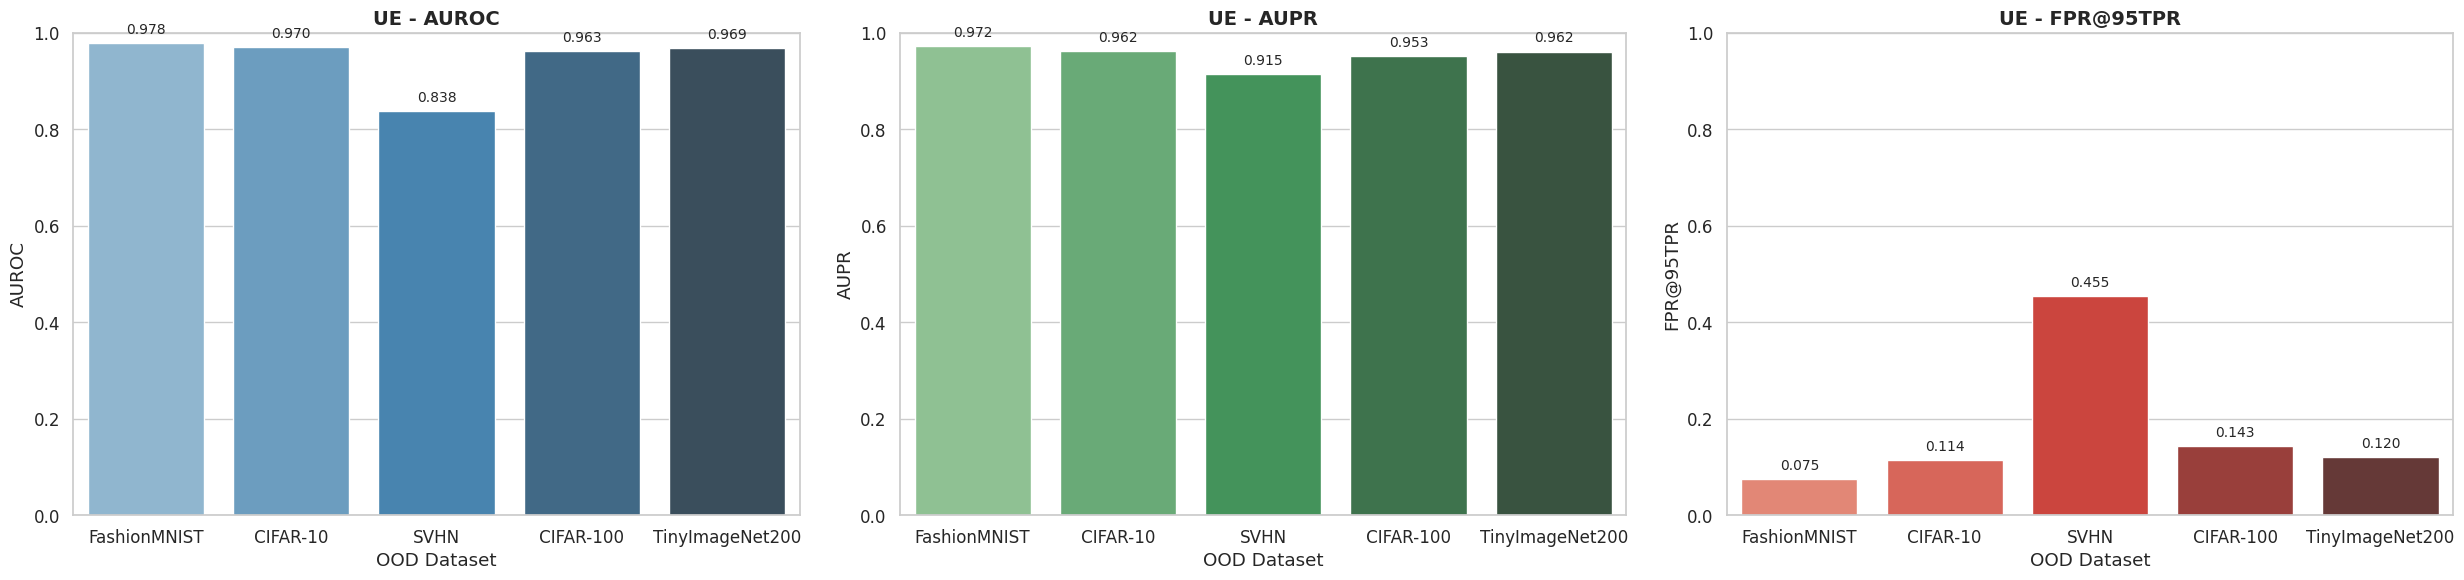

In [ ]:
plot_ood_metrics(df_ue, metric)

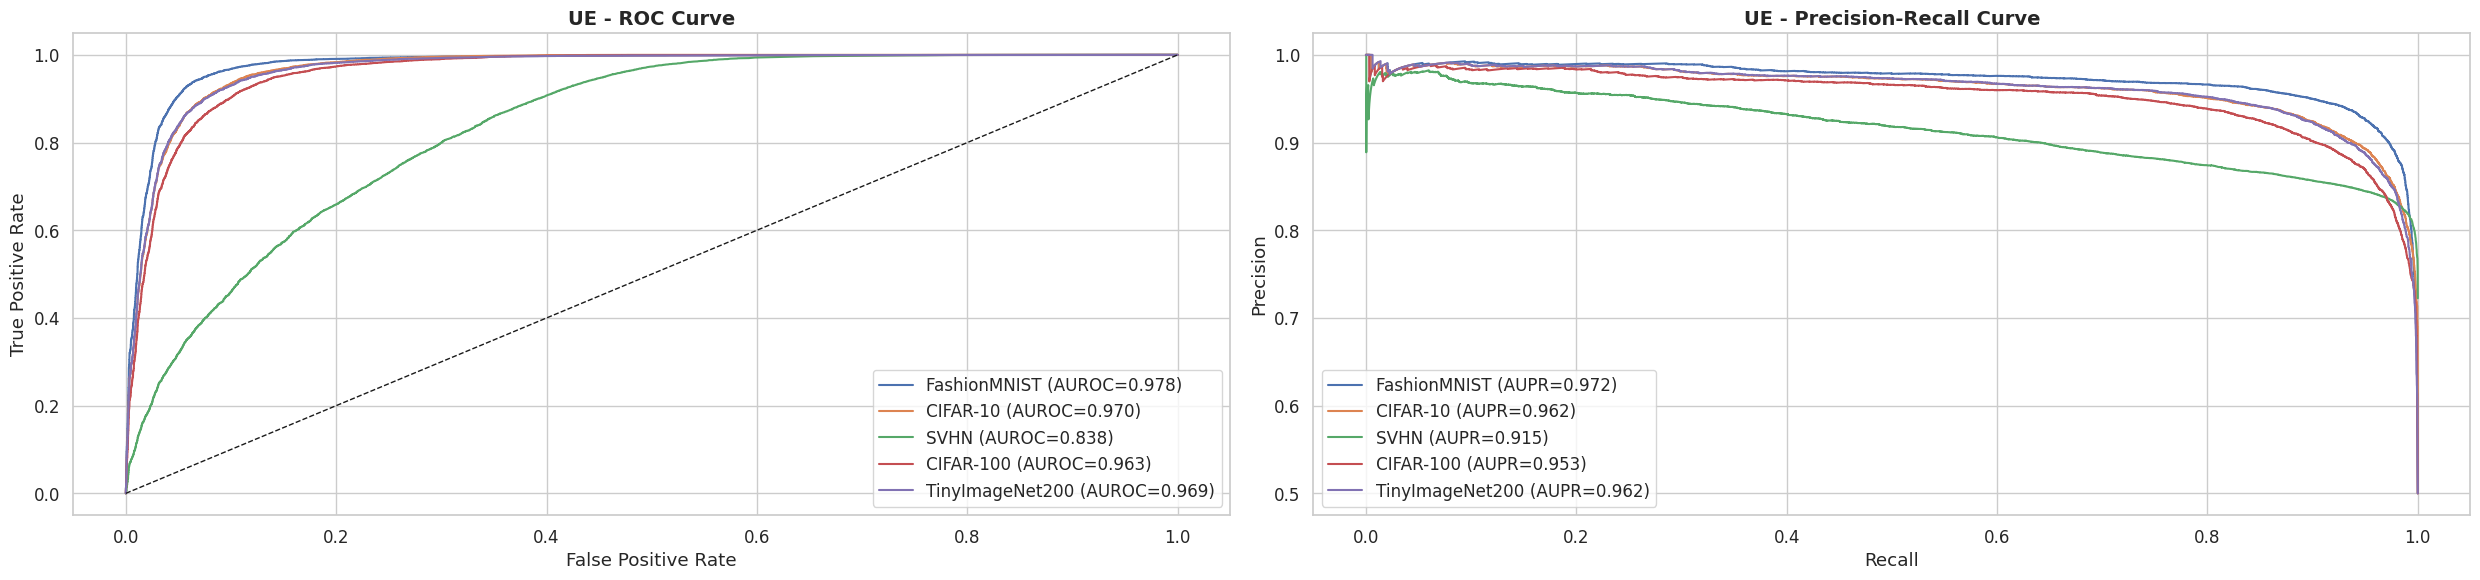

In [ ]:
plot_ood_curves(results_ue, metric)

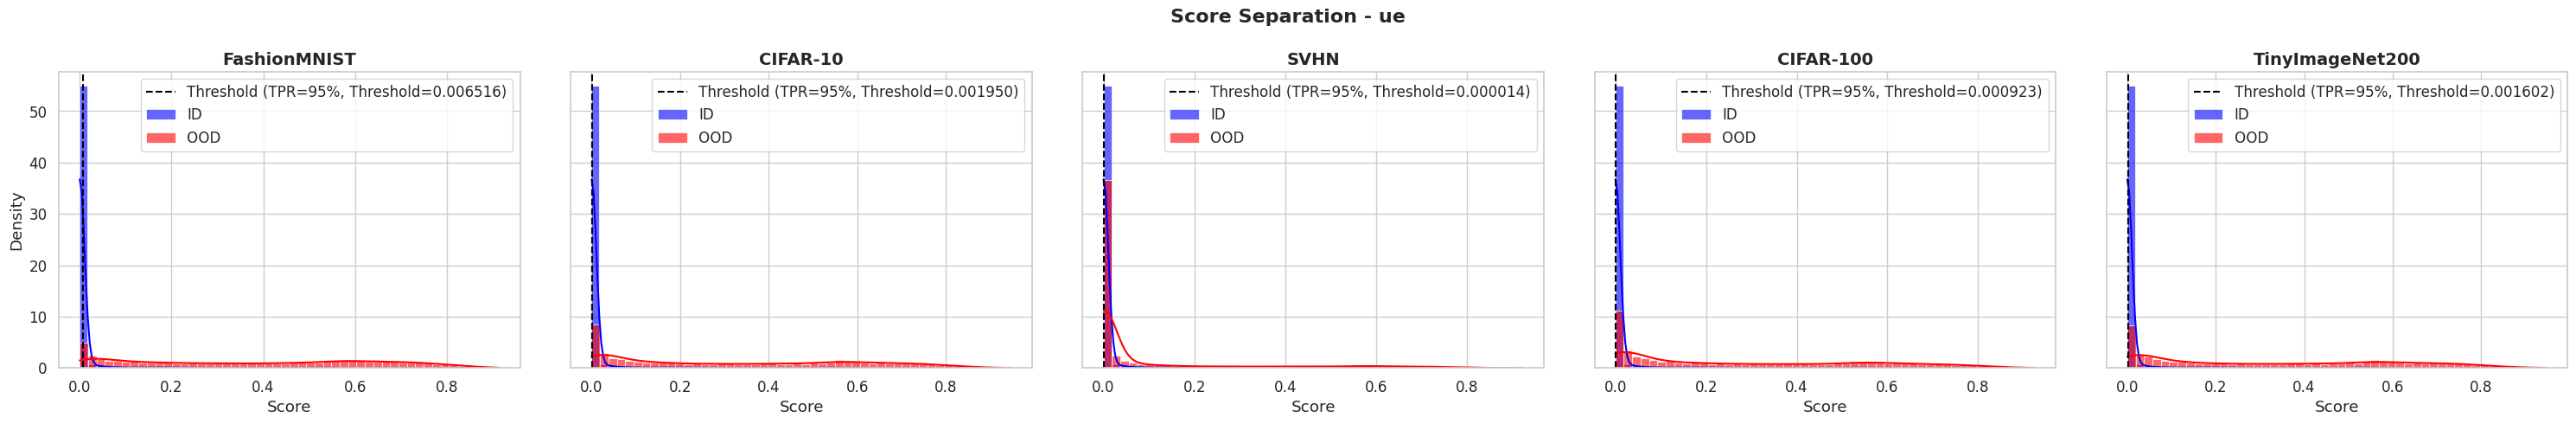

In [ ]:
plot_separation_for_method(results_ue, method_name="ue", target_tpr=0.95)

###### MSP(Max-Softmax Probability)

In [ ]:
metric = "msp"

In [ ]:
df_msp, results_msp = comprehensive_ood_analysis(
    exclude_garbage=True,
    model=model_after_inv,
    datasets=datasets,
    device=device,
    metric_name= metric,
    id_name= id_name,
    temperature=temperature if metric=="odin" else 1.0,
    class_means=class_means if metric=="mahalanobis" else None,
    cov_inv=cov_inv if metric=="mahalanobis" else None)

COMPREHENSIVE OOD ANALYSIS (Garbage class excluded) - MSP


OOD Dataset   AUROC    AUPR  FPR@95TPR  ID msp Mean  OOD msp Mean  \
0     FashionMNIST  0.9780  0.9706     0.0747       0.9936        0.7576   
1         CIFAR-10  0.9701  0.9607     0.1137       0.9936        0.7920   
2             SVHN  0.8381  0.9148     0.4550       0.9936        0.9388   
3        CIFAR-100  0.9623  0.9515     0.1430       0.9936        0.8177   
4  TinyImageNet200  0.9689  0.9601     0.1205       0.9936        0.7906   

   Separation  
0      0.2359  
1      0.2015  
2      0.0547  
3      0.1758  
4      0.2030


Avg AUROC = 0.9435 | Avg AUPR = 0.9515 | Avg FPR@95TPR = 0.1814


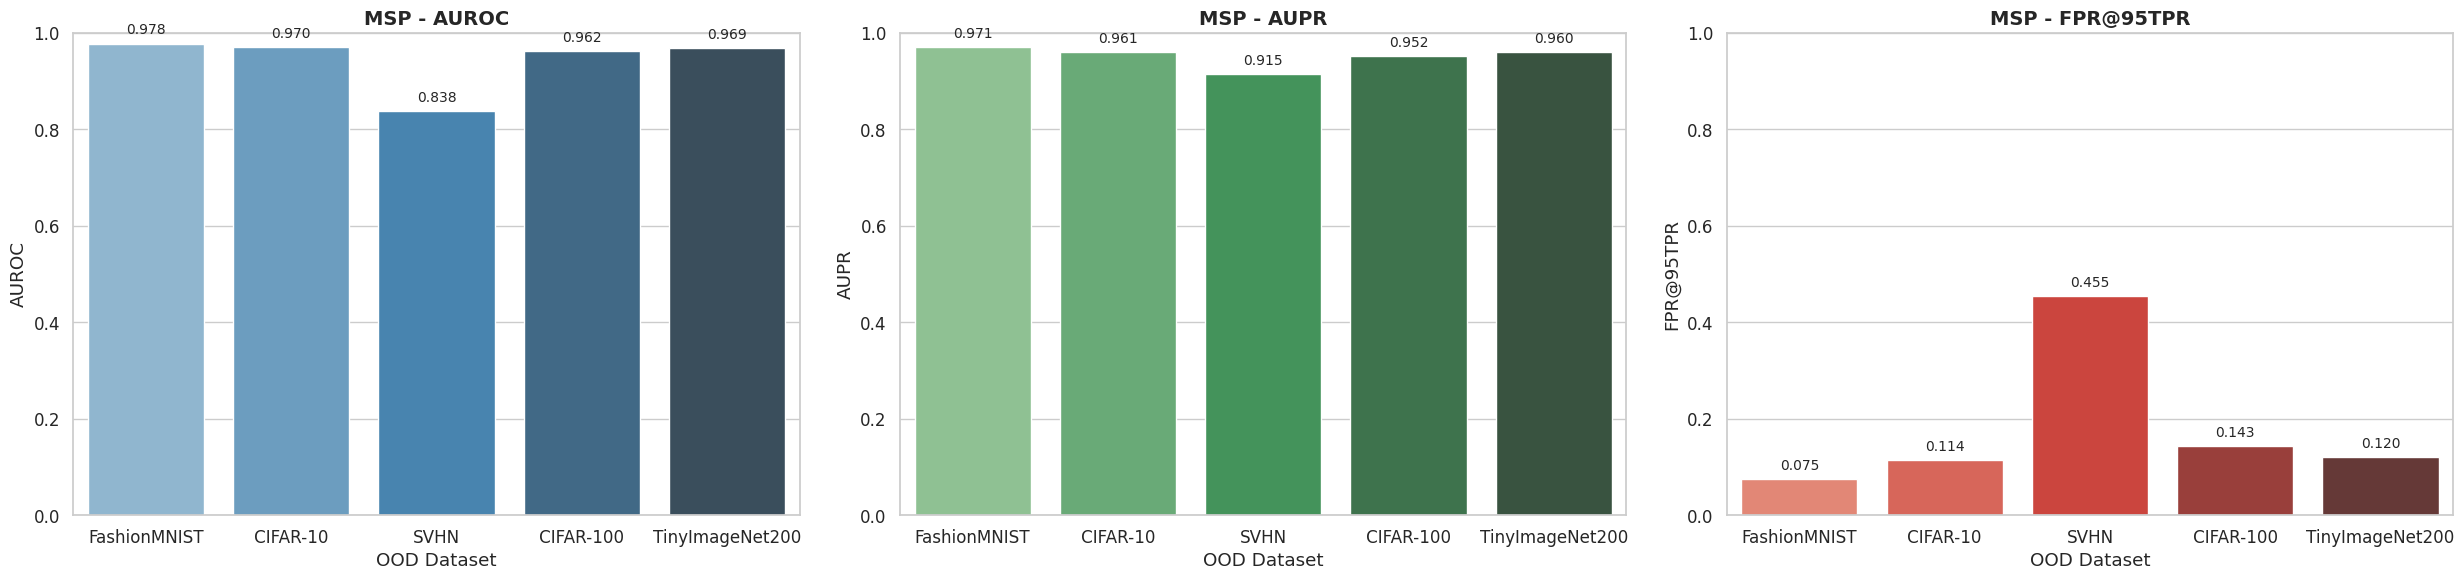

In [ ]:
plot_ood_metrics(df_msp, metric)

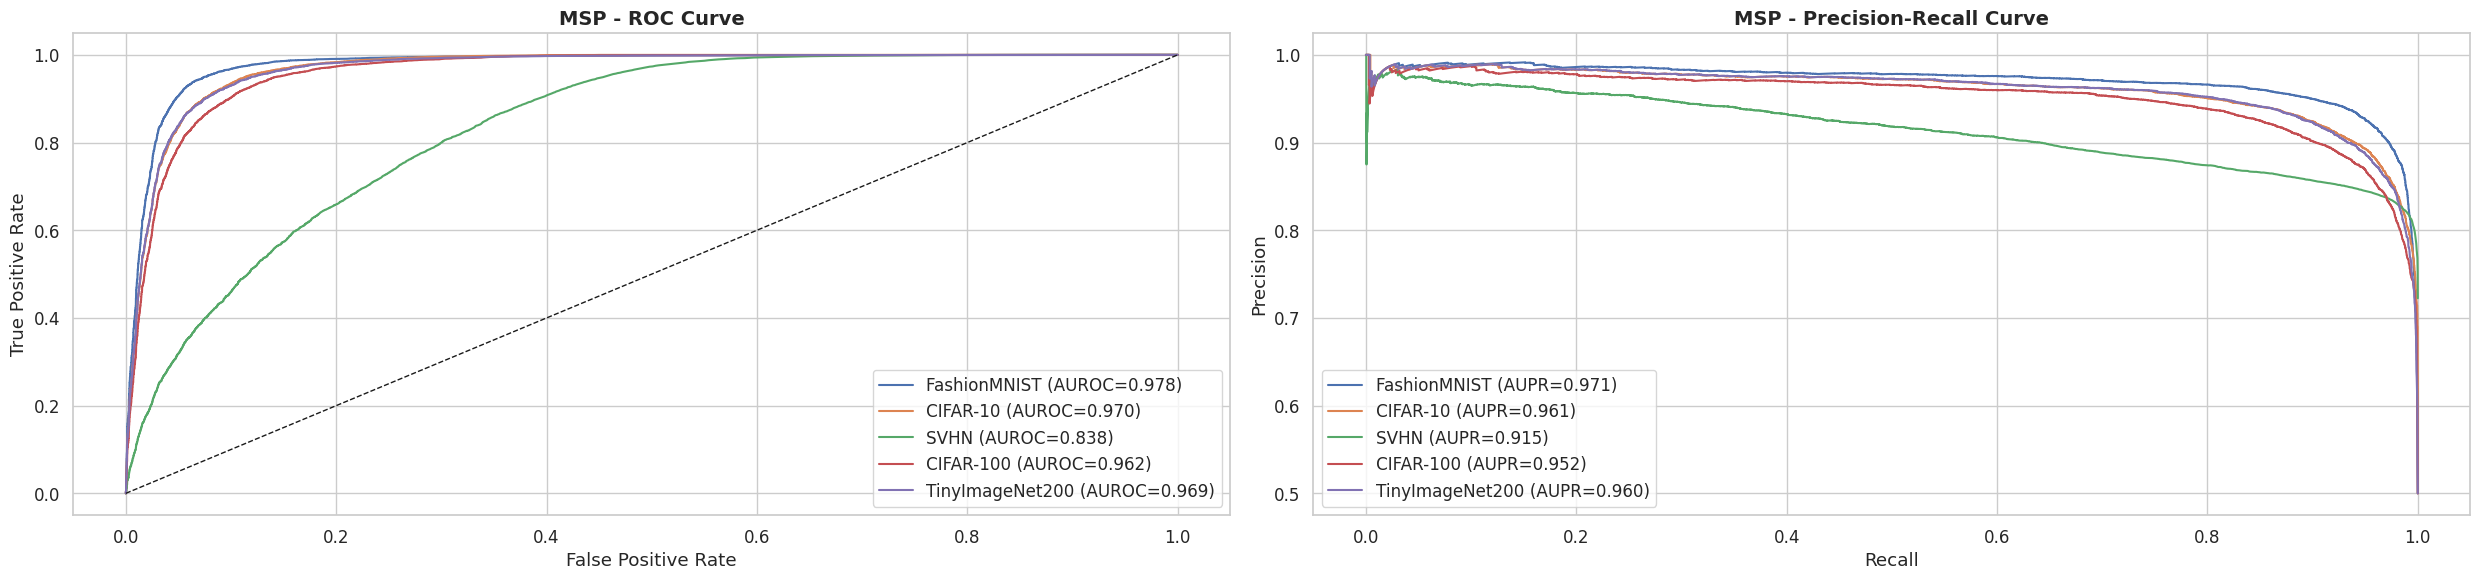

In [ ]:
plot_ood_curves(results_msp, metric)

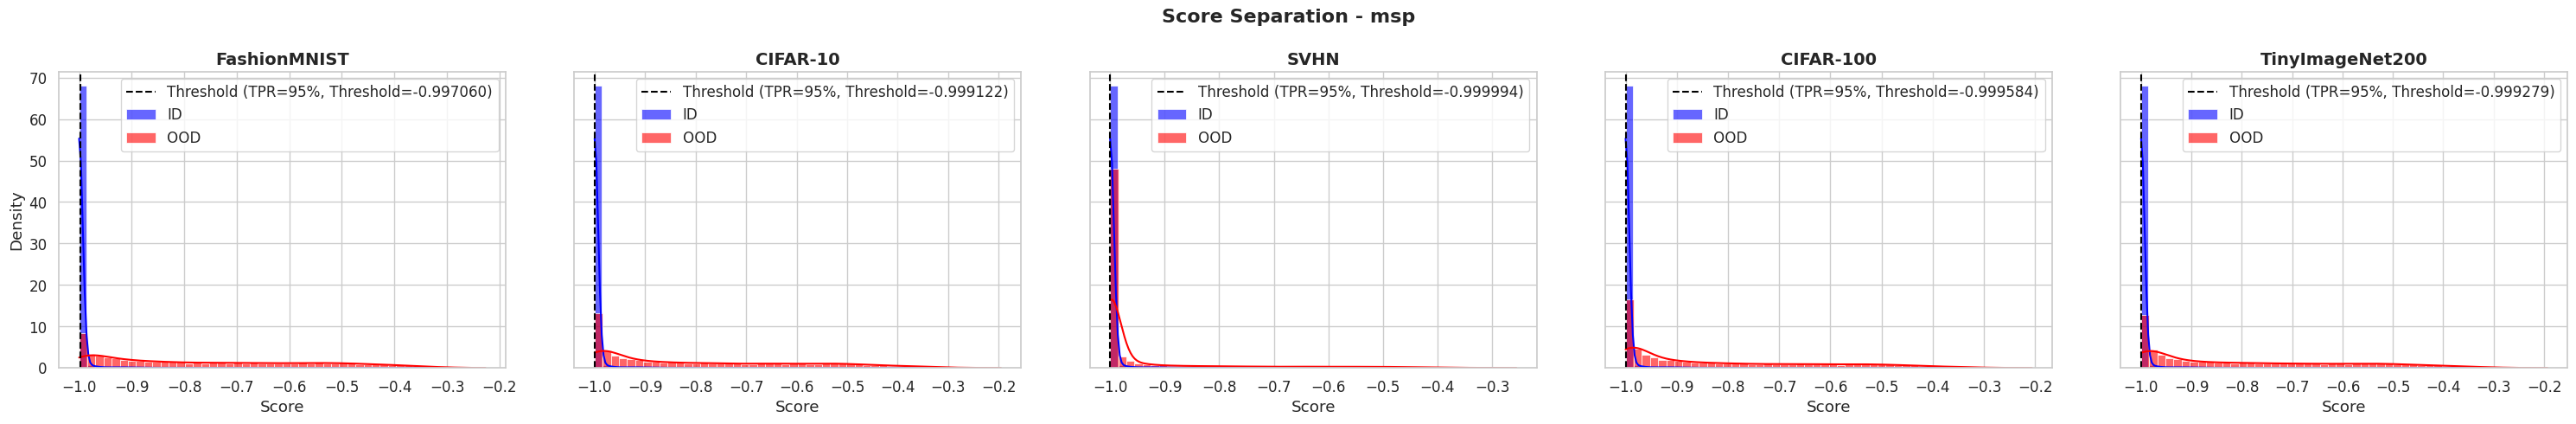

In [ ]:
plot_separation_for_method(results_msp, method_name=metric, target_tpr=0.95)

###### ODIN(Out-of-distrbution detector for Neural Networks)

In [ ]:
metric = "odin"

In [ ]:
df_odin, results_odin = comprehensive_ood_analysis(
    exclude_garbage=True,
    model=model_after_inv,
    datasets=datasets,
    device=device,
    metric_name= metric,
    id_name=id_name,
    temperature=temperature if metric=="odin" else 1.0,
    class_means=class_means if metric=="mahalanobis" else None,
    cov_inv=cov_inv if metric=="mahalanobis" else None)

COMPREHENSIVE OOD ANALYSIS (Garbage class excluded) - ODIN


OOD Dataset   AUROC    AUPR  FPR@95TPR  ID odin Mean  OOD odin Mean  \
0     FashionMNIST  0.9829  0.9790     0.0599        0.1018         0.1007   
1         CIFAR-10  0.9845  0.9798     0.0658        0.1018         0.1007   
2             SVHN  0.8890  0.9409     0.3375        0.1018         0.1011   
3        CIFAR-100  0.9770  0.9710     0.0967        0.1018         0.1008   
4  TinyImageNet200  0.9814  0.9776     0.0788        0.1018         0.1007   

   Separation  
0      0.0010  
1      0.0011  
2      0.0006  
3      0.0010  
4      0.0010


Avg AUROC = 0.9630 | Avg AUPR = 0.9697 | Avg FPR@95TPR = 0.1277


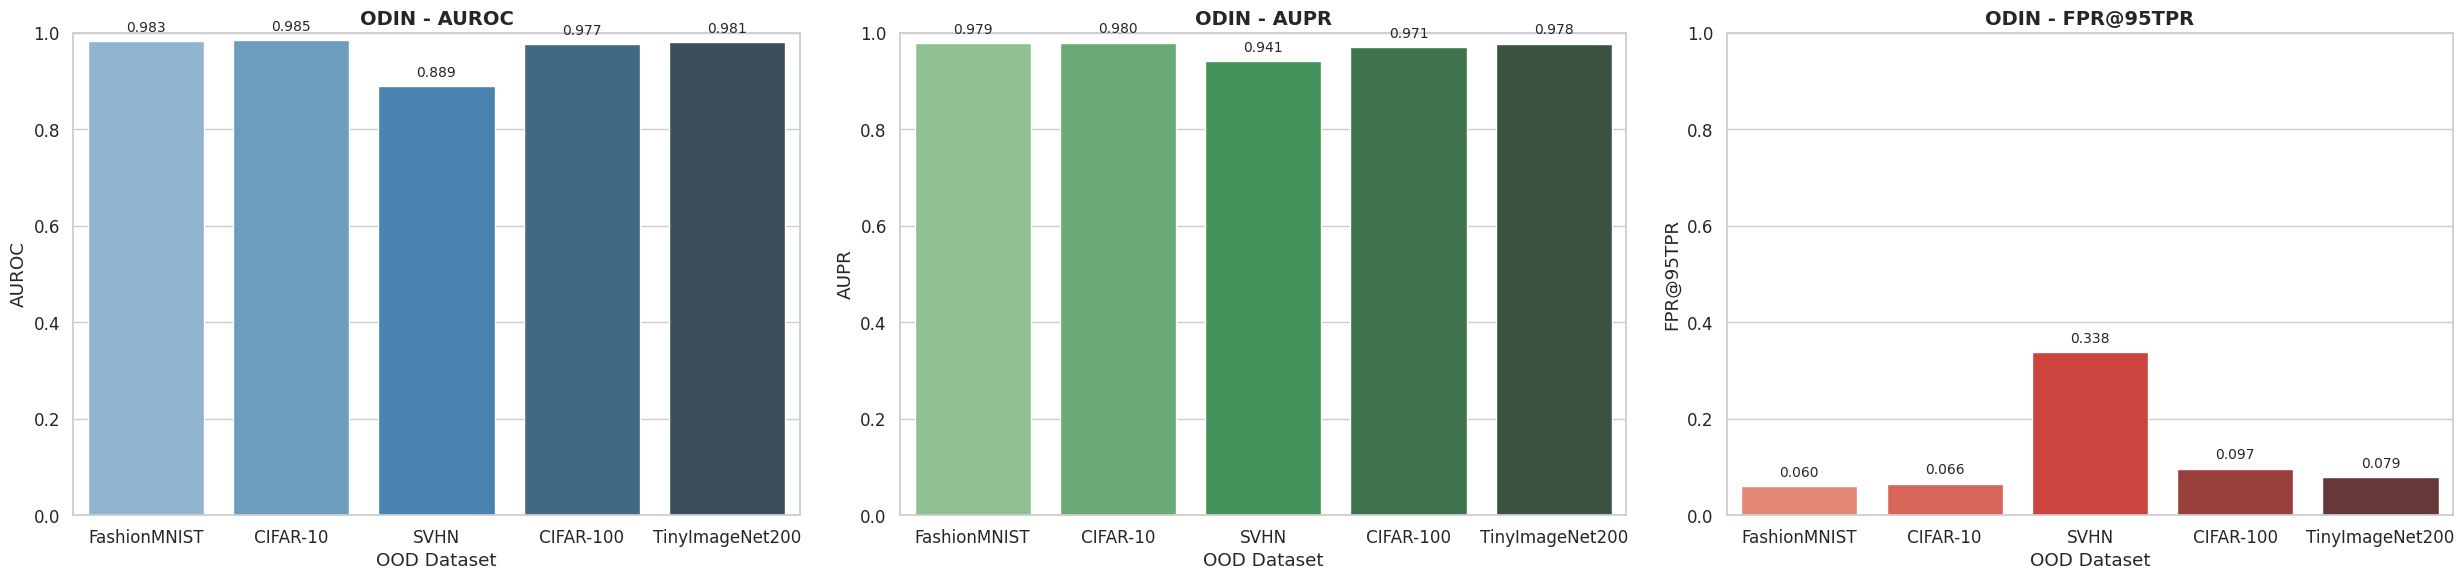

In [ ]:
plot_ood_metrics(df_odin, metric)

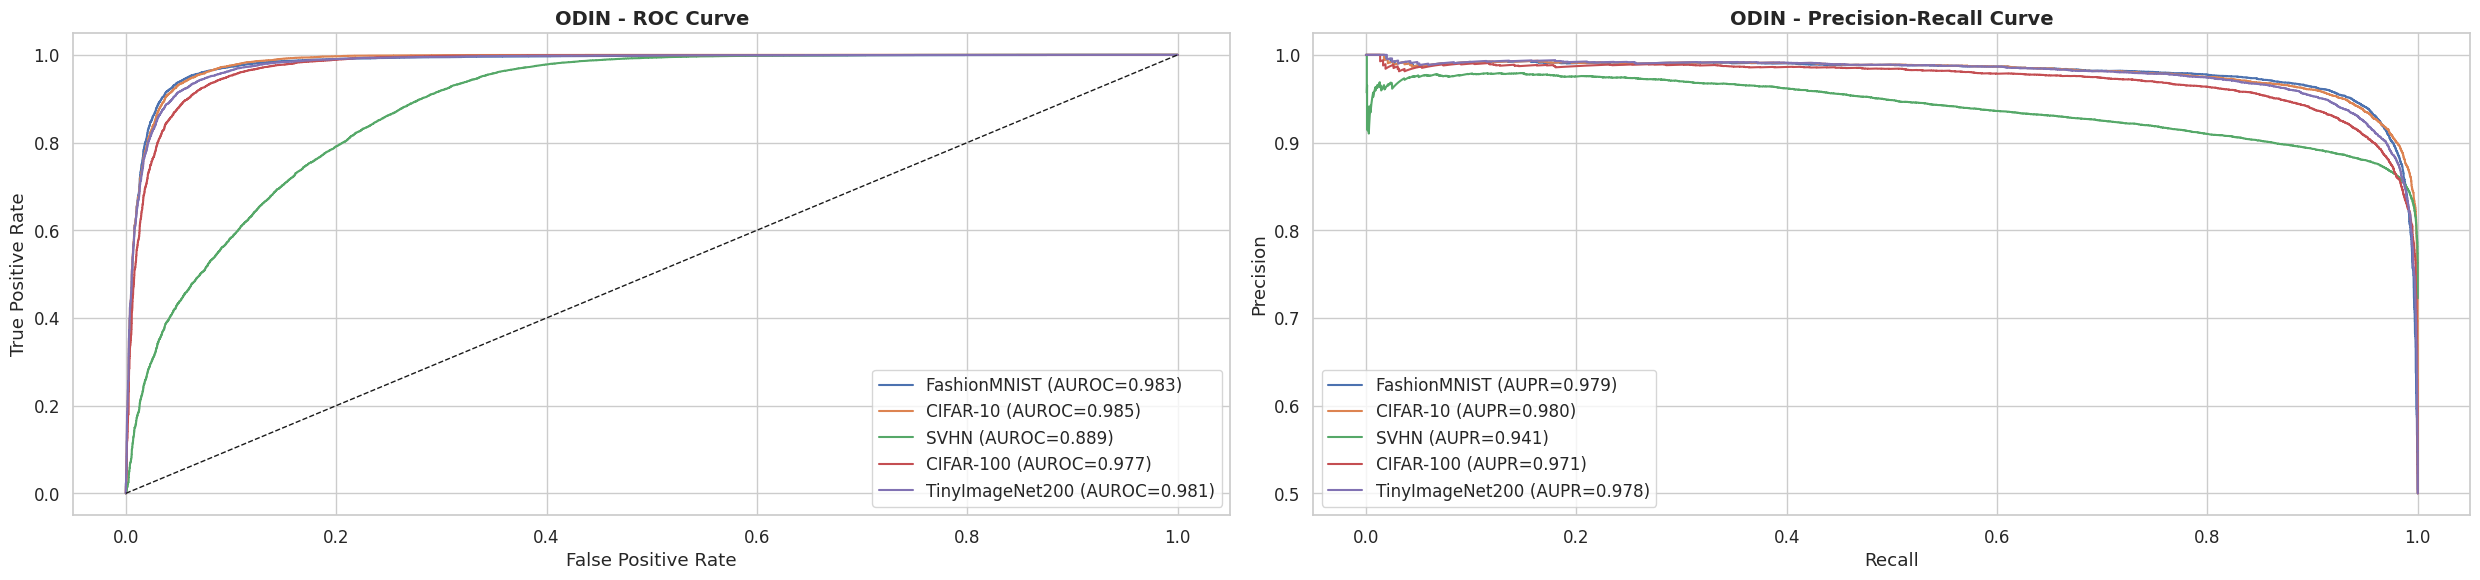

In [ ]:
plot_ood_curves(results_odin, metric)

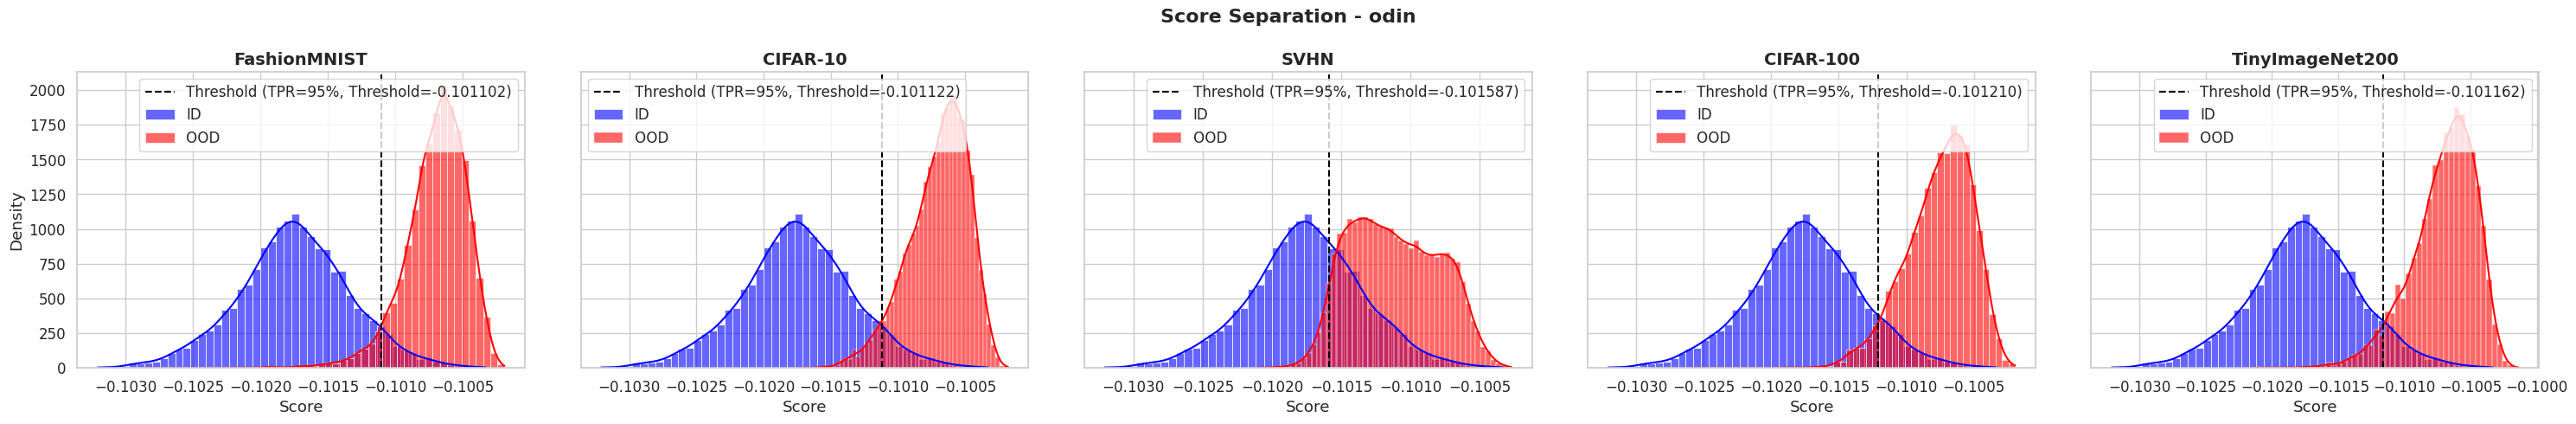

In [ ]:
plot_separation_for_method(results_odin, method_name=metric, target_tpr=0.95)

###### Energy

In [61]:
metric = "energy"

In [62]:
df_energy, results_energy = comprehensive_ood_analysis(
    exclude_garbage=True,
    model=model_after_inv,
    datasets=datasets,
    device=device,
    metric_name= metric,
    id_name=id_name,
    temperature=temperature if metric=="odin" else 1.0,
    class_means=class_means if metric=="mahalanobis" else None,
    cov_inv=cov_inv if metric=="mahalanobis" else None)

COMPREHENSIVE OOD ANALYSIS (Garbage class excluded) - ENERGY


OOD Dataset   AUROC    AUPR  FPR@95TPR  ID energy Mean  \
0     FashionMNIST  0.9929  0.9922     0.0286        -12.7806   
1         CIFAR-10  0.9961  0.9960     0.0199        -12.7806   
2             SVHN  0.9407  0.9732     0.2247        -12.7806   
3        CIFAR-100  0.9935  0.9935     0.0343        -12.7806   
4  TinyImageNet200  0.9947  0.9949     0.0254        -12.7806   

   OOD energy Mean  Separation  
0          -3.3441      9.4366  
1          -1.4881     11.2926  
2          -5.3867      7.3939  
3          -1.9922     10.7885  
4          -1.6738     11.1069


Avg AUROC = 0.9836 | Avg AUPR = 0.9900 | Avg FPR@95TPR = 0.0666


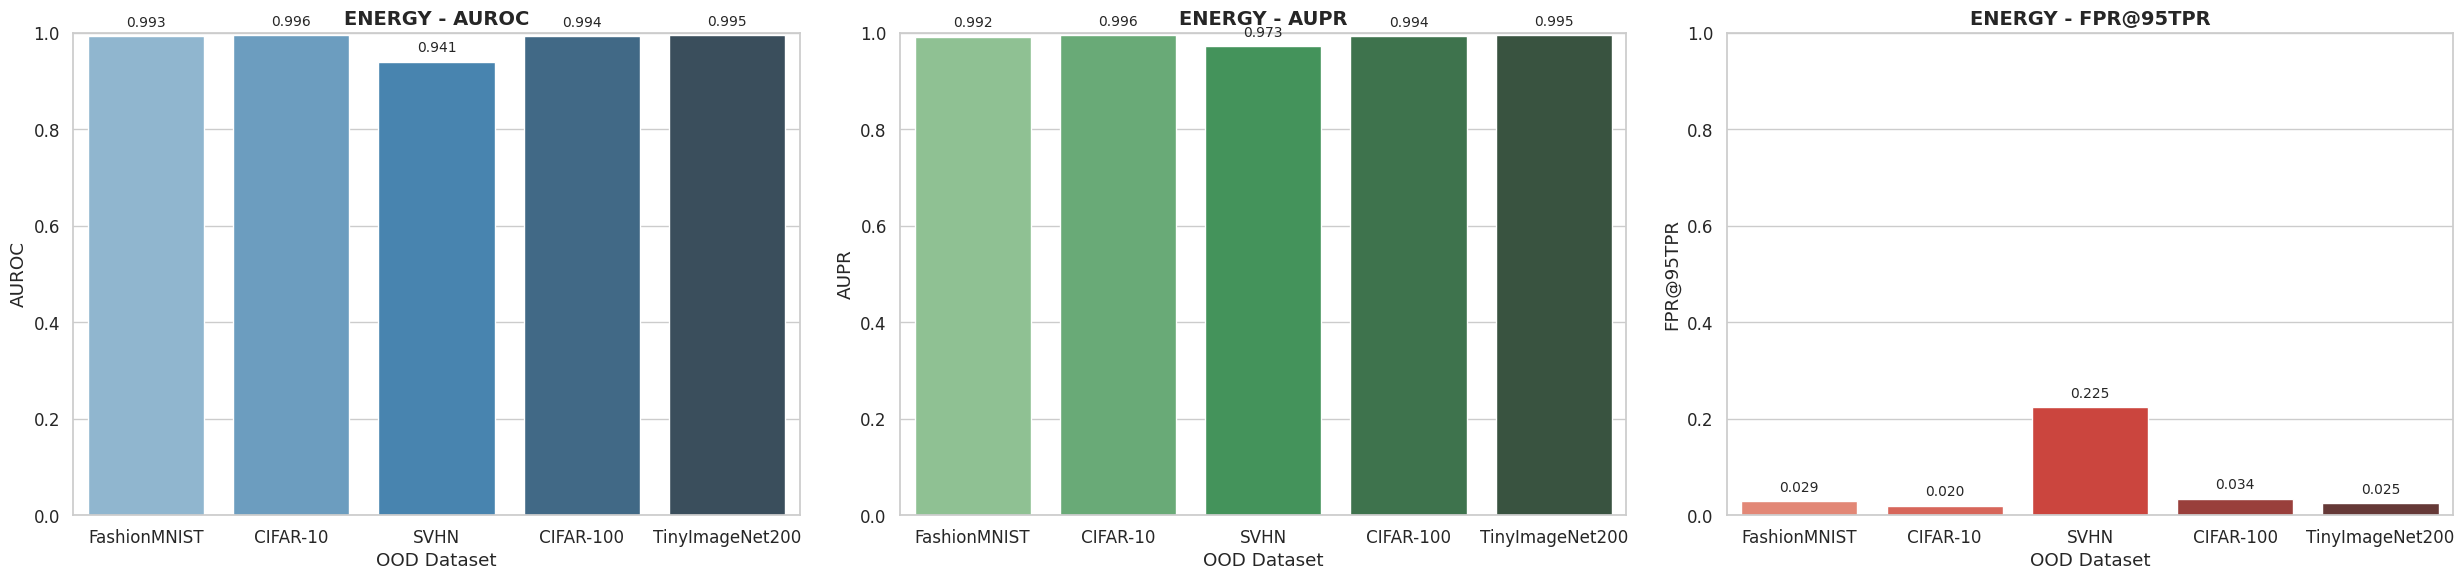

In [63]:
plot_ood_metrics(df_energy, metric)

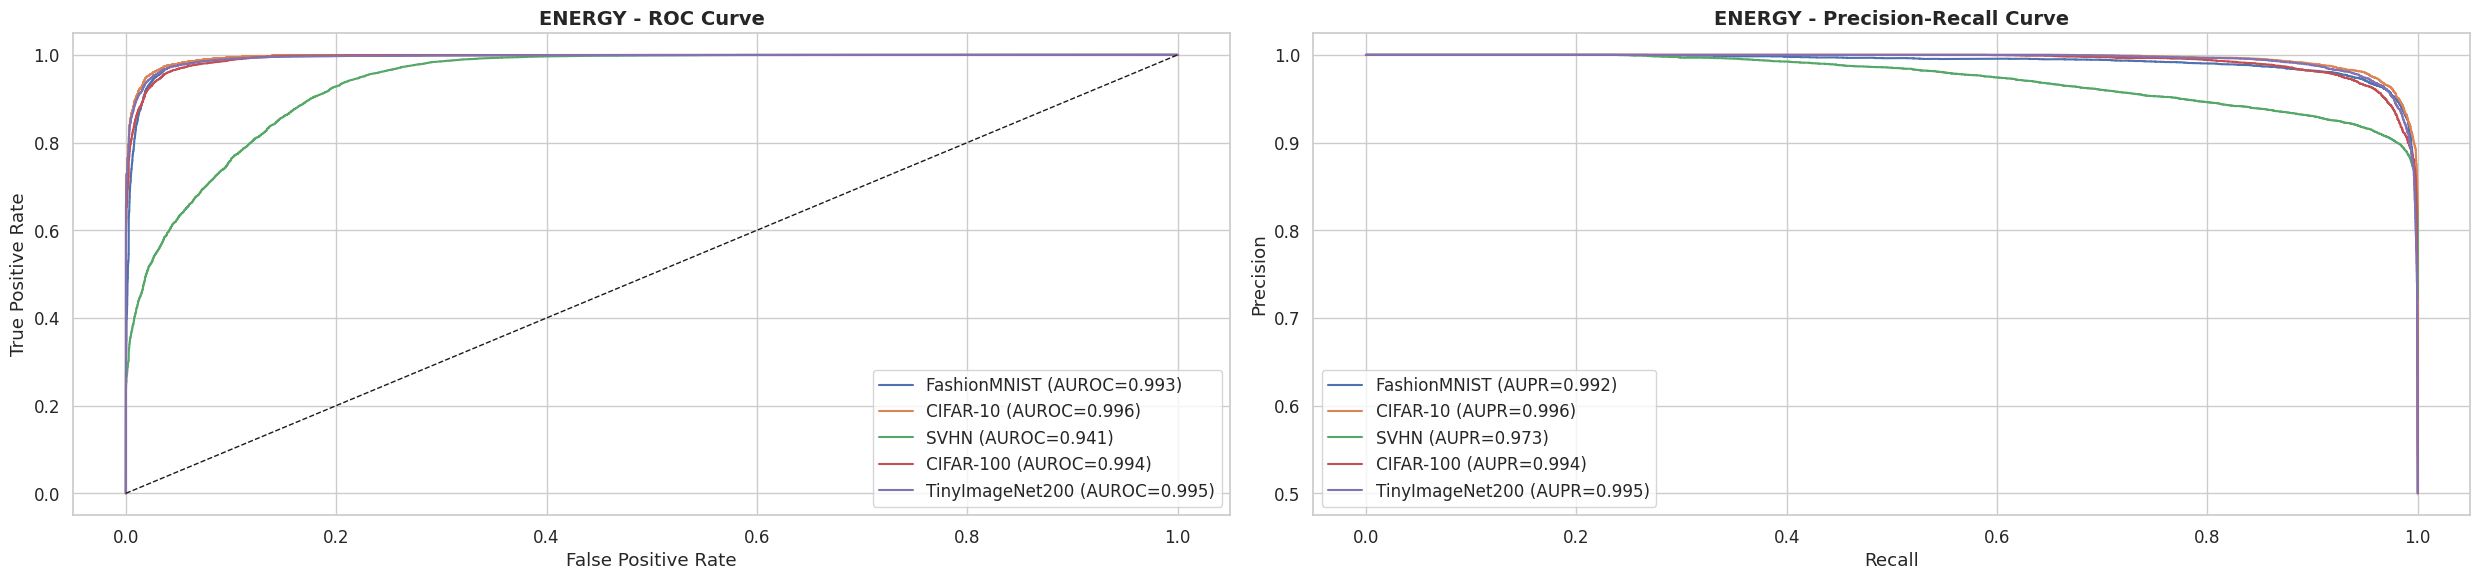

In [64]:
plot_ood_curves(results_energy, metric)

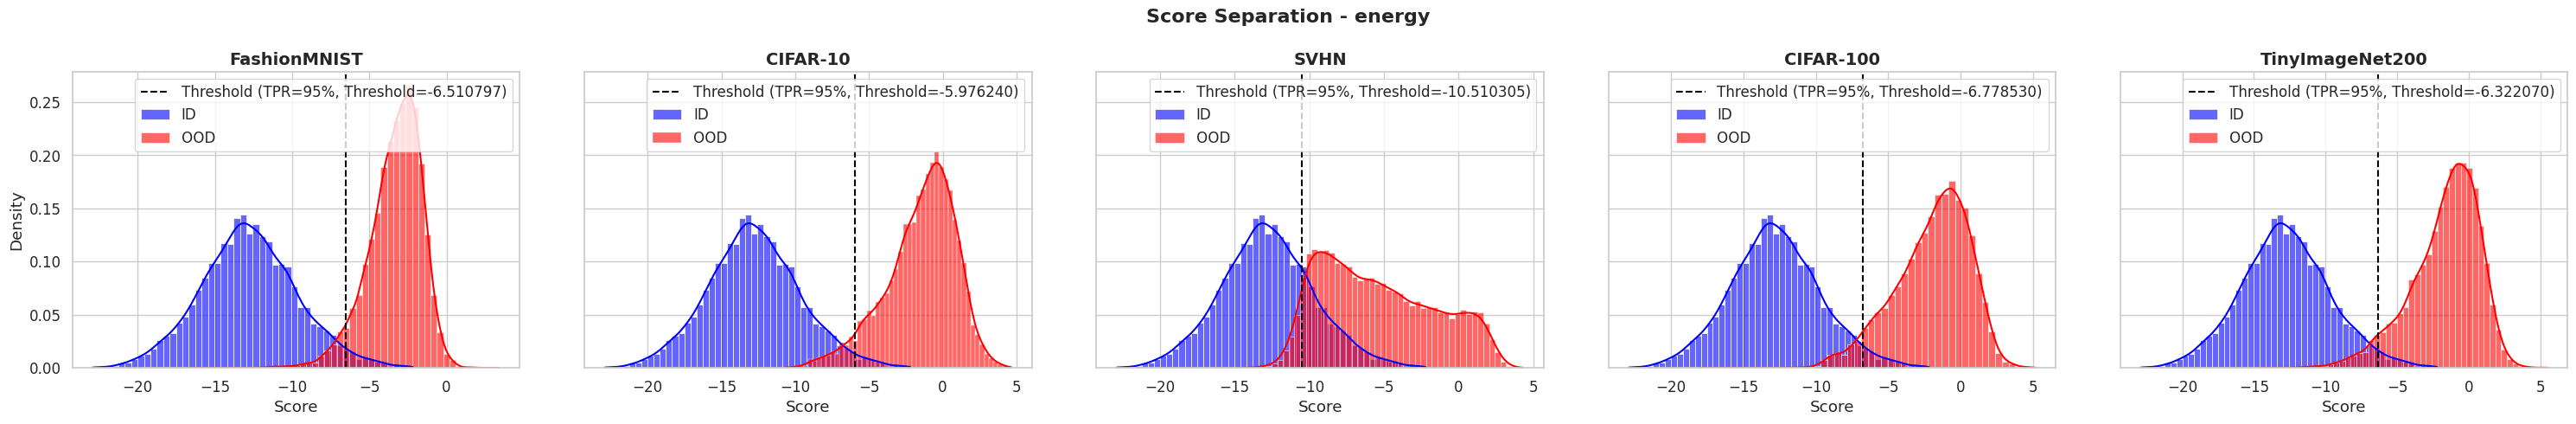

In [ ]:
plot_separation_for_method(results_energy, method_name=metric, target_tpr=0.95)

###### Mahalanobis

In [ ]:
metric = "mahalanobis"

In [ ]:
df_maha, results_maha = comprehensive_ood_analysis(
    exclude_garbage=True,
    model=model_after_inv,
    datasets=datasets,
    device=device,
    metric_name= metric,
    id_name=id_name,
    temperature=temperature if metric=="odin" else 1.0,
    class_means=class_means if metric=="mahalanobis" else None,
    cov_inv=cov_inv if metric=="mahalanobis" else None)

COMPREHENSIVE OOD ANALYSIS (Garbage class excluded) - MAHALANOBIS


OOD Dataset   AUROC    AUPR  FPR@95TPR  ID mahalanobis Mean  \
0     FashionMNIST  0.9982  0.9983     0.0083          -119.336502   
1         CIFAR-10  0.9999  0.9999     0.0000          -119.336502   
2             SVHN  0.9998  0.9999     0.0004          -119.336502   
3        CIFAR-100  0.9998  0.9998     0.0000          -119.336502   
4  TinyImageNet200  0.9998  0.9998     0.0001          -119.336502   

   OOD mahalanobis Mean   Separation  
0           -864.147705   744.811218  
1          -2154.067383  2034.730835  
2          -1856.372437  1737.035767  
3          -2194.399658  2075.063232  
4          -1985.195557  1865.859009


Avg AUROC = 0.9995 | Avg AUPR = 0.9995 | Avg FPR@95TPR = 0.0018


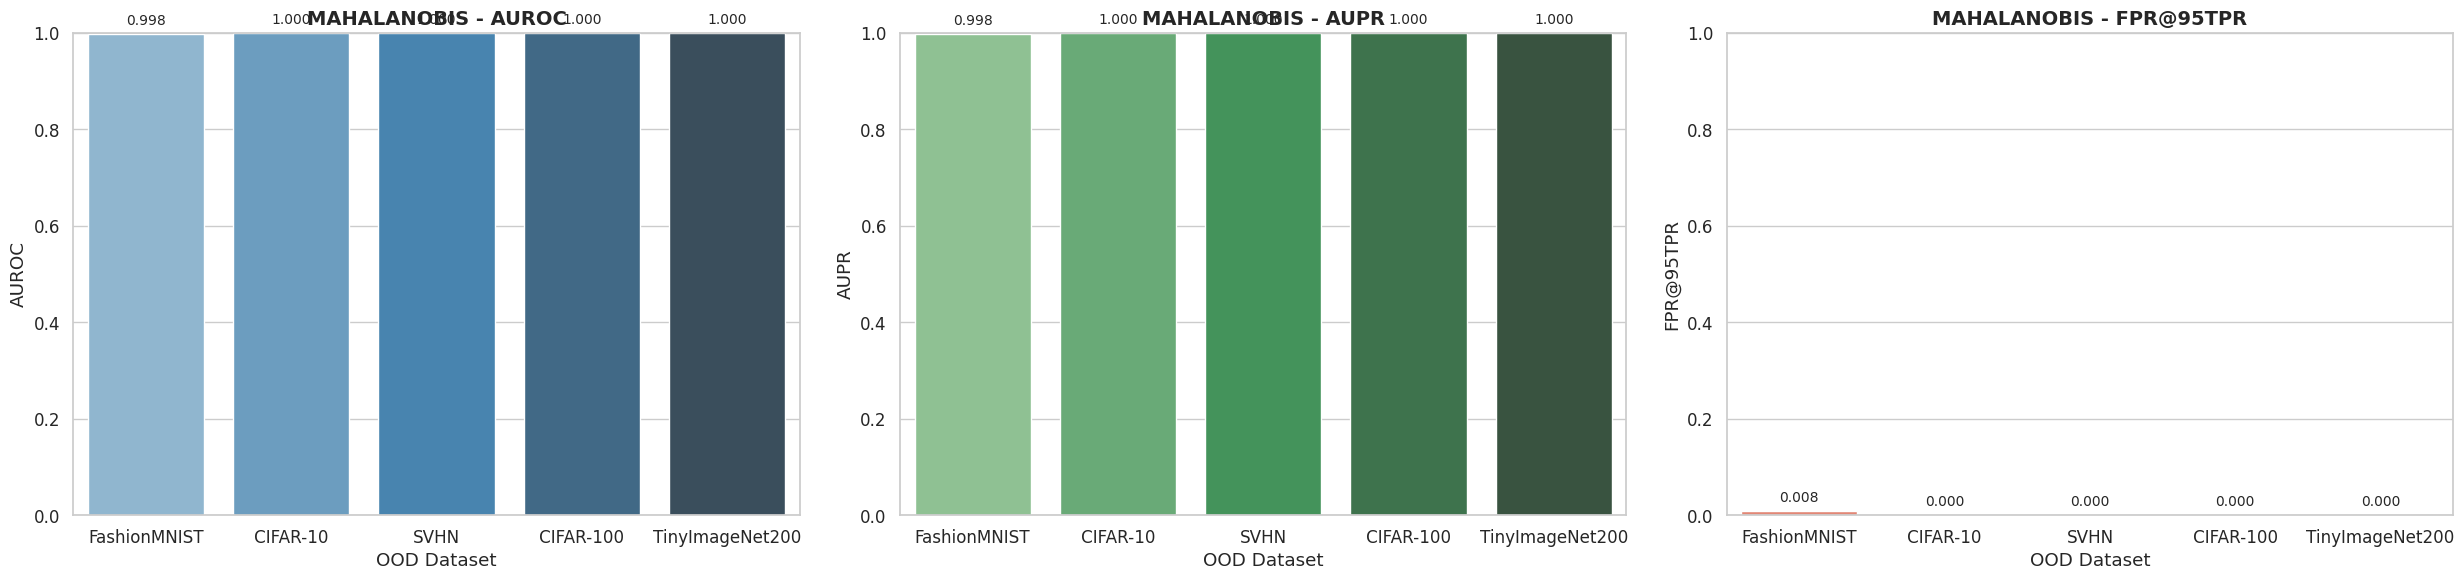

In [ ]:
plot_ood_metrics(df_maha, metric)

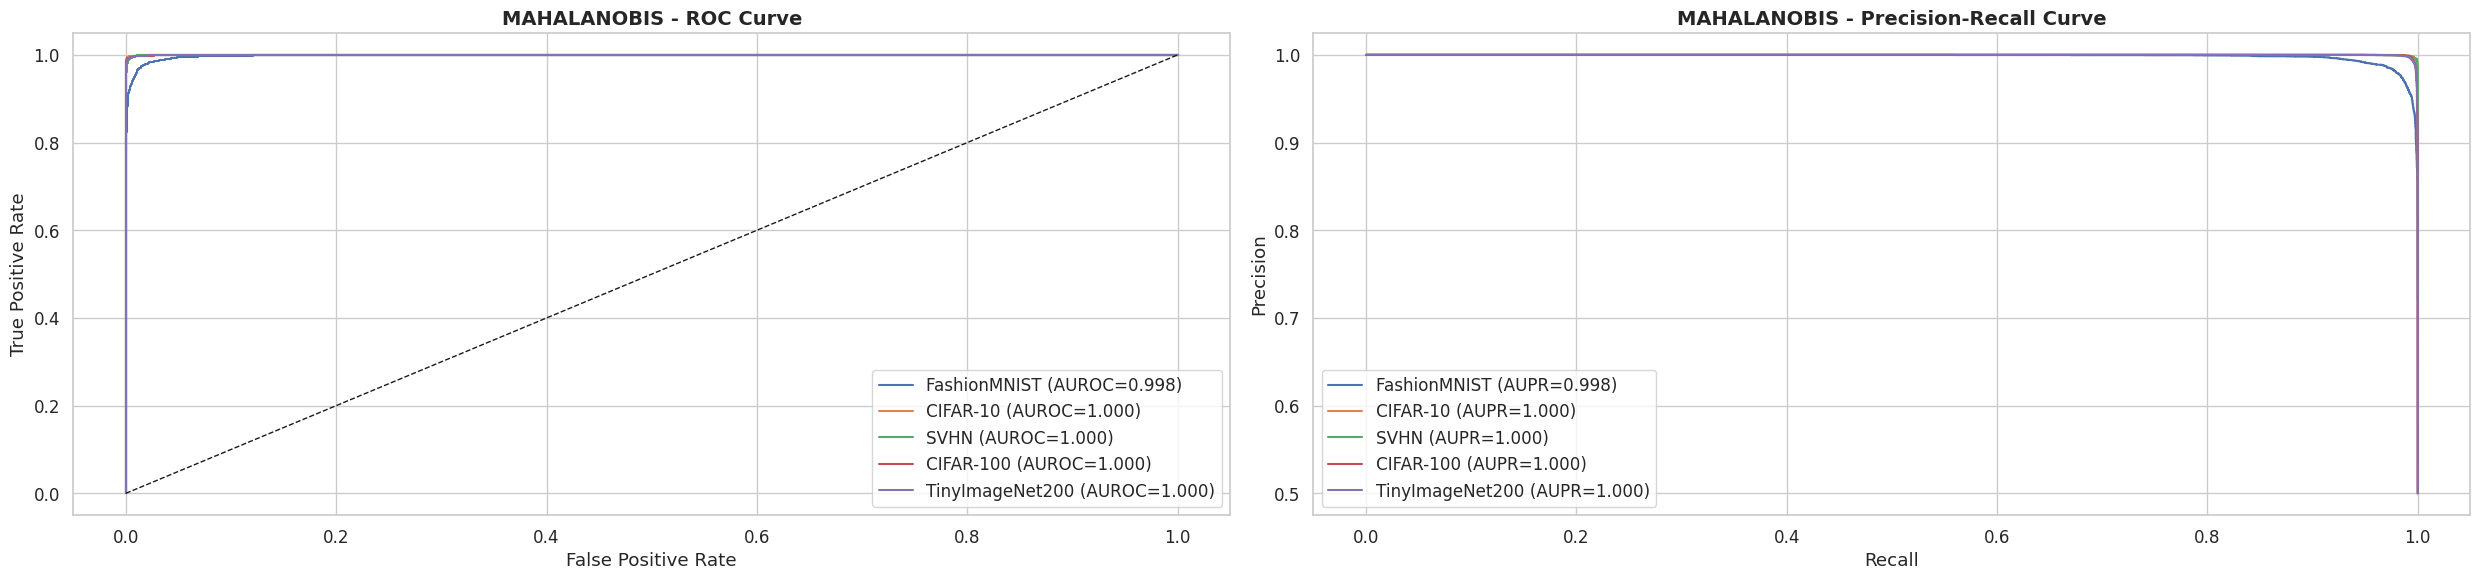

In [ ]:
plot_ood_curves(results_maha, metric)

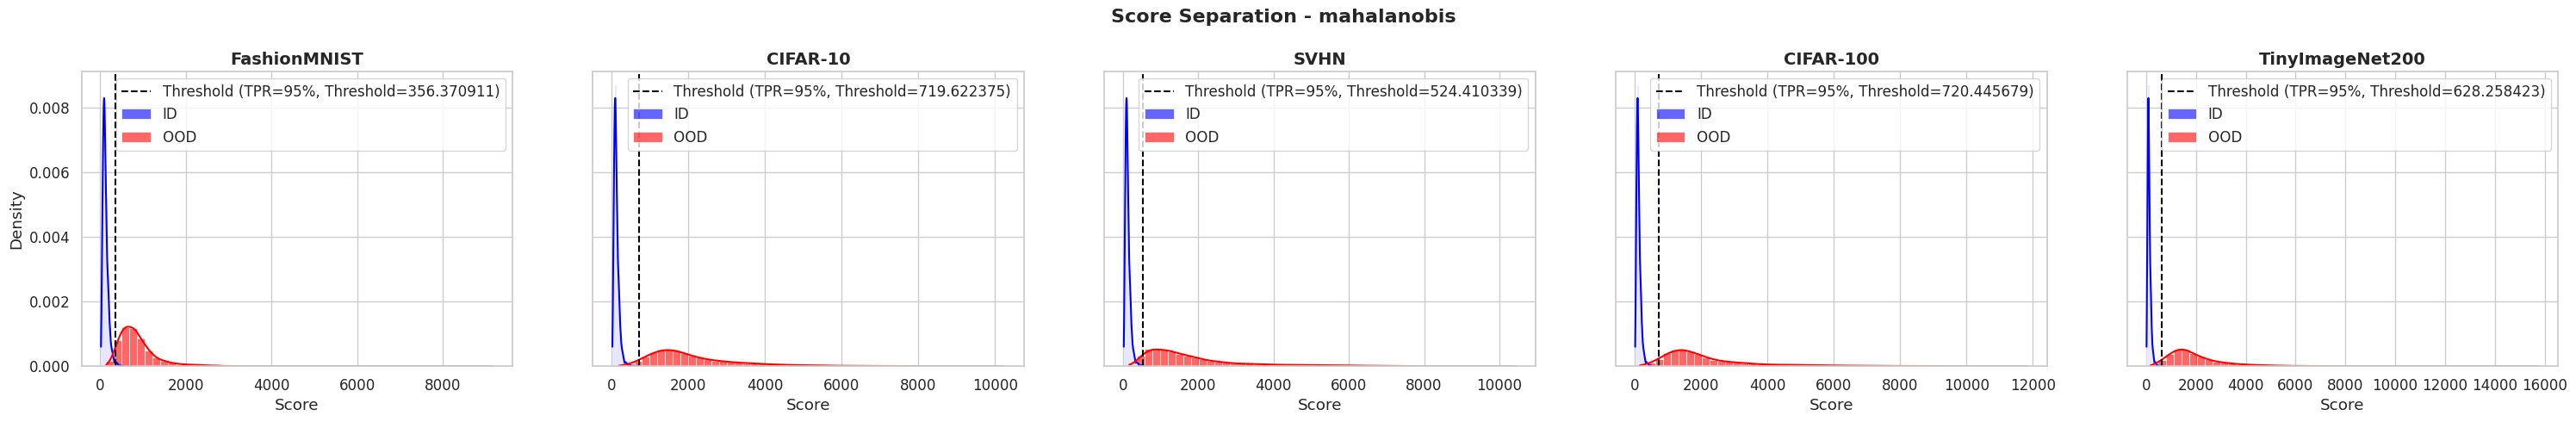

In [ ]:
plot_separation_for_method(results_maha, method_name=metric, target_tpr=0.95)

###### Comparison

In [ ]:
metric_dfs = {
    "UE": df_ue,
    "MSP": df_msp,
    "ODIN": df_odin,
    "Energy": df_energy,
    "Mahalanobis": df_maha
}

# Initialize empty dicts to store AUROC, AUPR, FPR separately
auroc_df, aupr_df, fpr95_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

for metric_name, df in metric_dfs.items():
    temp_df = df.set_index("OOD Dataset")
    auroc_df[metric_name] = temp_df["AUROC"]
    aupr_df[metric_name] = temp_df["AUPR"]
    fpr95_df[metric_name] = temp_df["FPR@95TPR"]

# Reset index so OOD Dataset is a column
auroc_df = auroc_df.reset_index()
aupr_df = aupr_df.reset_index()
fpr95_df = fpr95_df.reset_index()

In [ ]:
print("=== AUROC Comparison ===")
display(auroc_df)

=== AUROC Comparison ===


OOD Dataset      UE     MSP    ODIN  Energy  Mahalanobis
0     FashionMNIST  0.9784  0.9780  0.9829  0.9929       0.9982
1         CIFAR-10  0.9704  0.9701  0.9845  0.9961       0.9999
2             SVHN  0.8381  0.8381  0.8890  0.9407       0.9998
3        CIFAR-100  0.9626  0.9623  0.9770  0.9935       0.9998
4  TinyImageNet200  0.9692  0.9689  0.9814  0.9947       0.9998

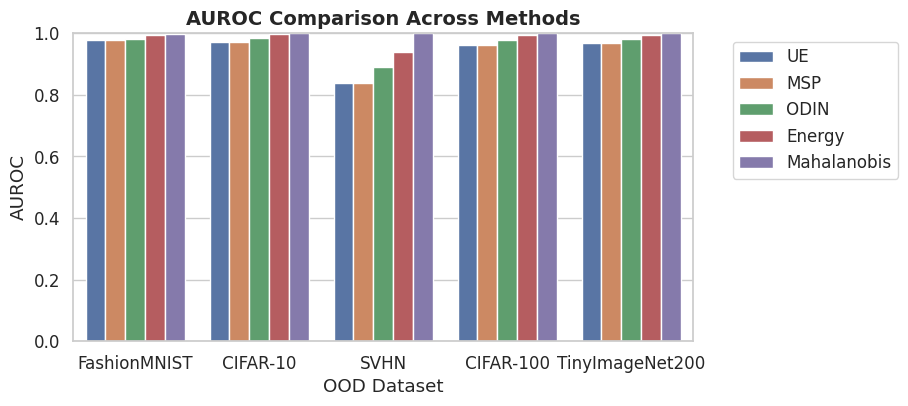

In [ ]:
plot_metric_comparison(auroc_df, "AUROC")

In [ ]:
print("=== AUPR Comparison ===")
display(aupr_df)

=== AUPR Comparison ===


OOD Dataset      UE     MSP    ODIN  Energy  Mahalanobis
0     FashionMNIST  0.9719  0.9706  0.9790  0.9922       0.9983
1         CIFAR-10  0.9620  0.9607  0.9798  0.9960       0.9999
2             SVHN  0.9152  0.9148  0.9409  0.9732       0.9999
3        CIFAR-100  0.9526  0.9515  0.9710  0.9935       0.9998
4  TinyImageNet200  0.9615  0.9601  0.9776  0.9949       0.9998

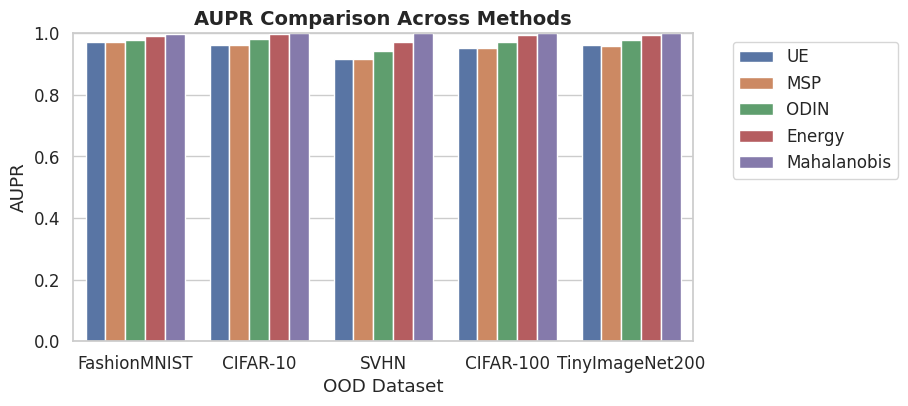

In [ ]:
plot_metric_comparison(aupr_df, "AUPR")

In [ ]:
print("=== FPR@95TPR Comparison ===")
display(fpr95_df)

=== FPR@95TPR Comparison ===


OOD Dataset      UE     MSP    ODIN  Energy  Mahalanobis
0     FashionMNIST  0.0747  0.0747  0.0599  0.0286       0.0083
1         CIFAR-10  0.1137  0.1137  0.0658  0.0199       0.0000
2             SVHN  0.4550  0.4550  0.3375  0.2247       0.0004
3        CIFAR-100  0.1430  0.1430  0.0967  0.0343       0.0000
4  TinyImageNet200  0.1204  0.1205  0.0788  0.0254       0.0001

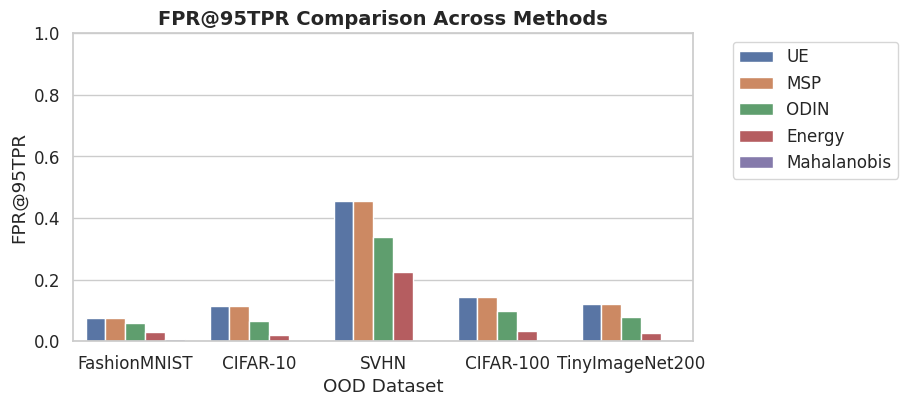

In [ ]:
plot_metric_comparison(fpr95_df, "FPR@95TPR")

##### Including Garbage class

In [ ]:
id_name = "MNIST"

In [ ]:
# Compute class statistics from ID dataset
class_means, cov_inv = compute_mahalanobis_stats(model_after_inv, datasets[id_name], device)

In [ ]:
exclude_garbage=False

###### UE

In [ ]:
metric = "ue"

In [ ]:
df_ue, results_ue = comprehensive_ood_analysis(
    exclude_garbage,
    model=model_after_inv,
    datasets=datasets,
    device=device,
    metric_name= metric,
    id_name=id_name,
    temperature=temperature if metric=="odin" else 1.0,
    class_means=class_means if metric=="mahalanobis" else None,
    cov_inv=cov_inv if metric=="mahalanobis" else None)

COMPREHENSIVE OOD ANALYSIS (Garbage class included) - UE


OOD Dataset   AUROC    AUPR  FPR@95TPR  ID ue Mean  OOD ue Mean  \
0     FashionMNIST  0.8239  0.8321     0.7699      0.0108       0.1363   
1         CIFAR-10  0.4002  0.5013     1.0000      0.0108       0.0284   
2             SVHN  0.6111  0.8258     1.0000      0.0108       0.0568   
3        CIFAR-100  0.4558  0.5542     1.0000      0.0108       0.0406   
4  TinyImageNet200  0.4312  0.5275     1.0000      0.0108       0.0338   

   Separation  
0      0.1255  
1      0.0176  
2      0.0460  
3      0.0298  
4      0.0230


Avg AUROC = 0.5444 | Avg AUPR = 0.6482 | Avg FPR@95TPR = 0.9540


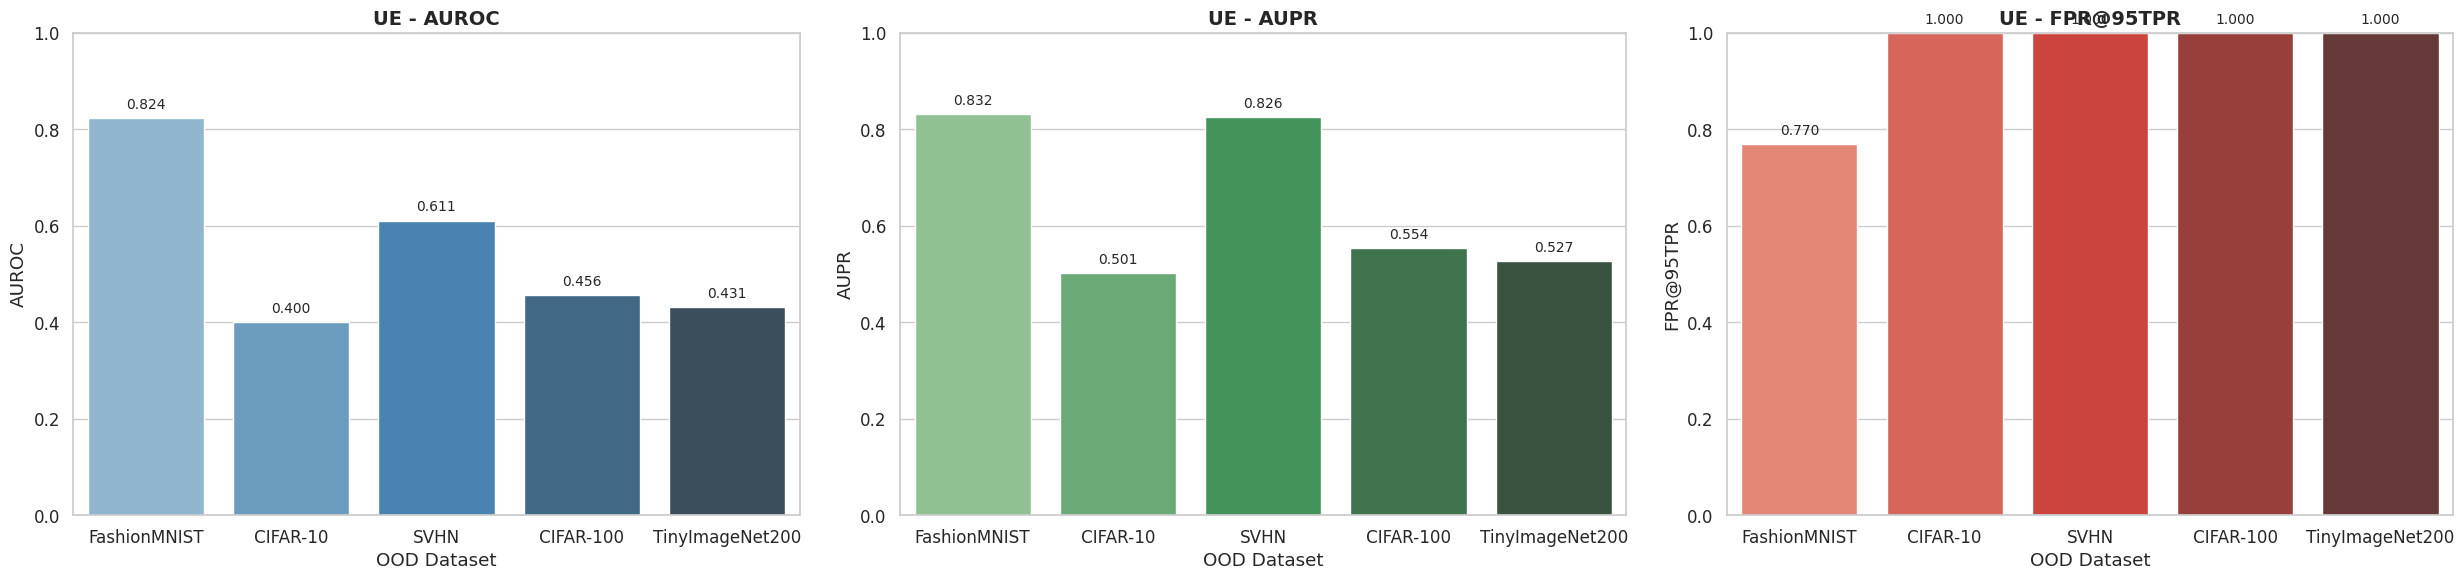

In [ ]:
plot_ood_metrics(df_ue, metric)

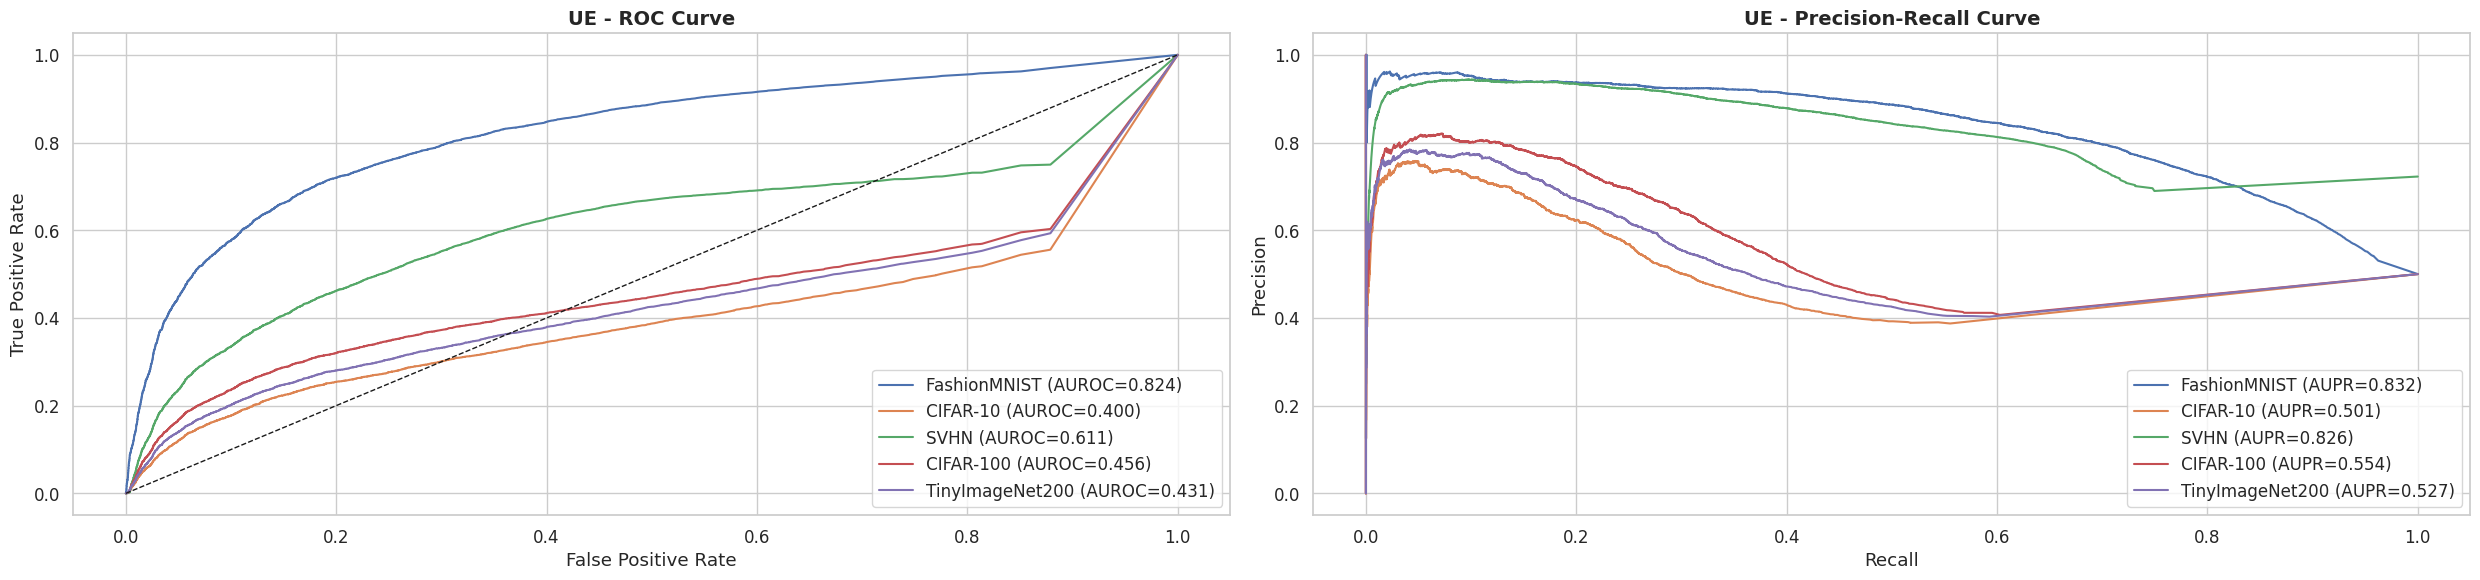

In [ ]:
plot_ood_curves(results_ue, metric)

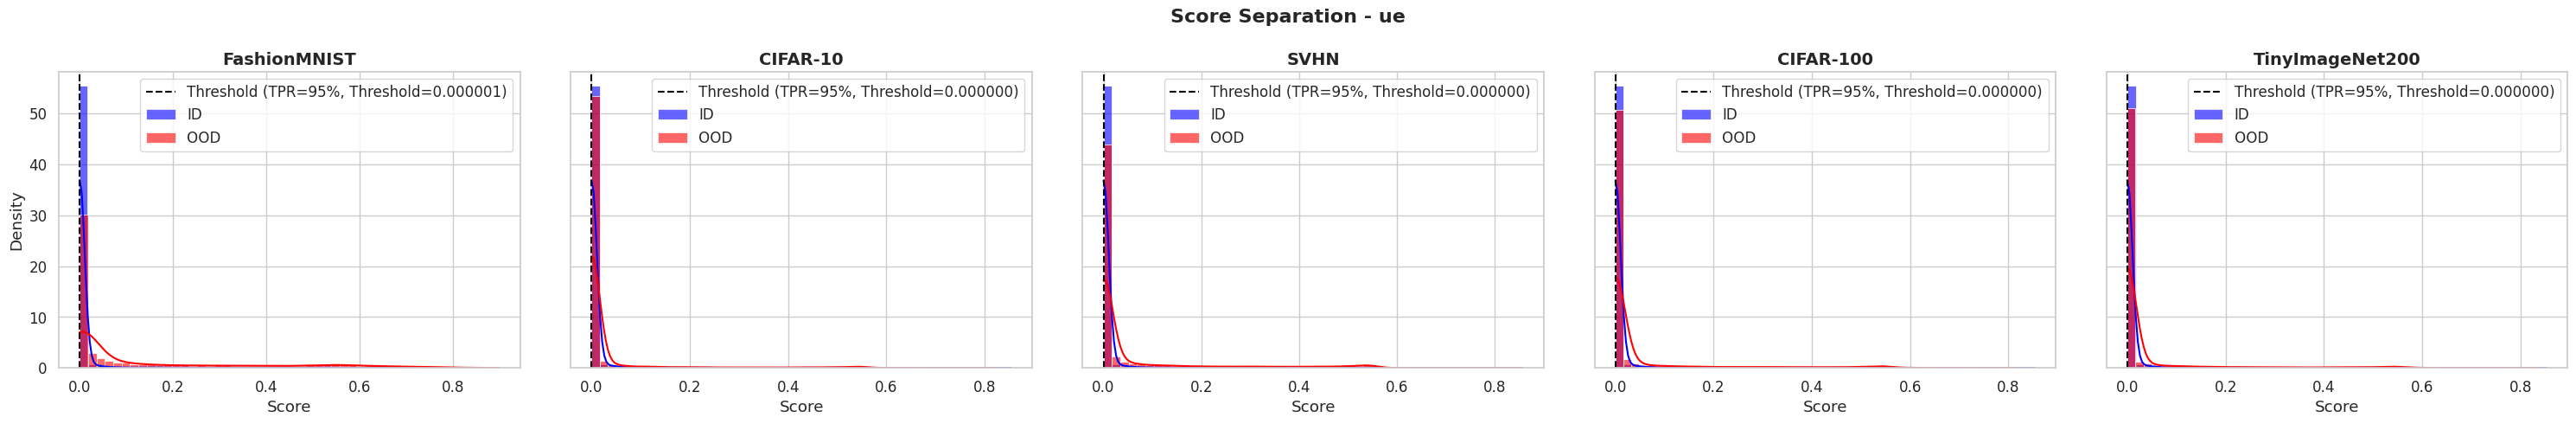

In [ ]:
plot_separation_for_method(results_ue, method_name="ue", target_tpr=0.95)

###### MSP(Max-Softmax Probability)

In [ ]:
metric = "msp"

In [ ]:
df_msp, results_msp = comprehensive_ood_analysis(
    exclude_garbage,
    model=model_after_inv,
    datasets=datasets,
    device=device,
    metric_name= metric,
    id_name= id_name,
    temperature=temperature if metric=="odin" else 1.0,
    class_means=class_means if metric=="mahalanobis" else None,
    cov_inv=cov_inv if metric=="mahalanobis" else None)

COMPREHENSIVE OOD ANALYSIS (Garbage class included) - MSP


OOD Dataset   AUROC    AUPR  FPR@95TPR  ID msp Mean  OOD msp Mean  \
0     FashionMNIST  0.8239  0.8314     0.7702       0.9935        0.9138   
1         CIFAR-10  0.4001  0.5025     1.0000       0.9935        0.9822   
2             SVHN  0.6111  0.8275     1.0000       0.9935        0.9644   
3        CIFAR-100  0.4556  0.5557     1.0000       0.9935        0.9745   
4  TinyImageNet200  0.4313  0.5286     1.0000       0.9935        0.9790   

   Separation  
0      0.0797  
1      0.0112  
2      0.0291  
3      0.0189  
4      0.0145


Avg AUROC = 0.5444 | Avg AUPR = 0.6491 | Avg FPR@95TPR = 0.9540


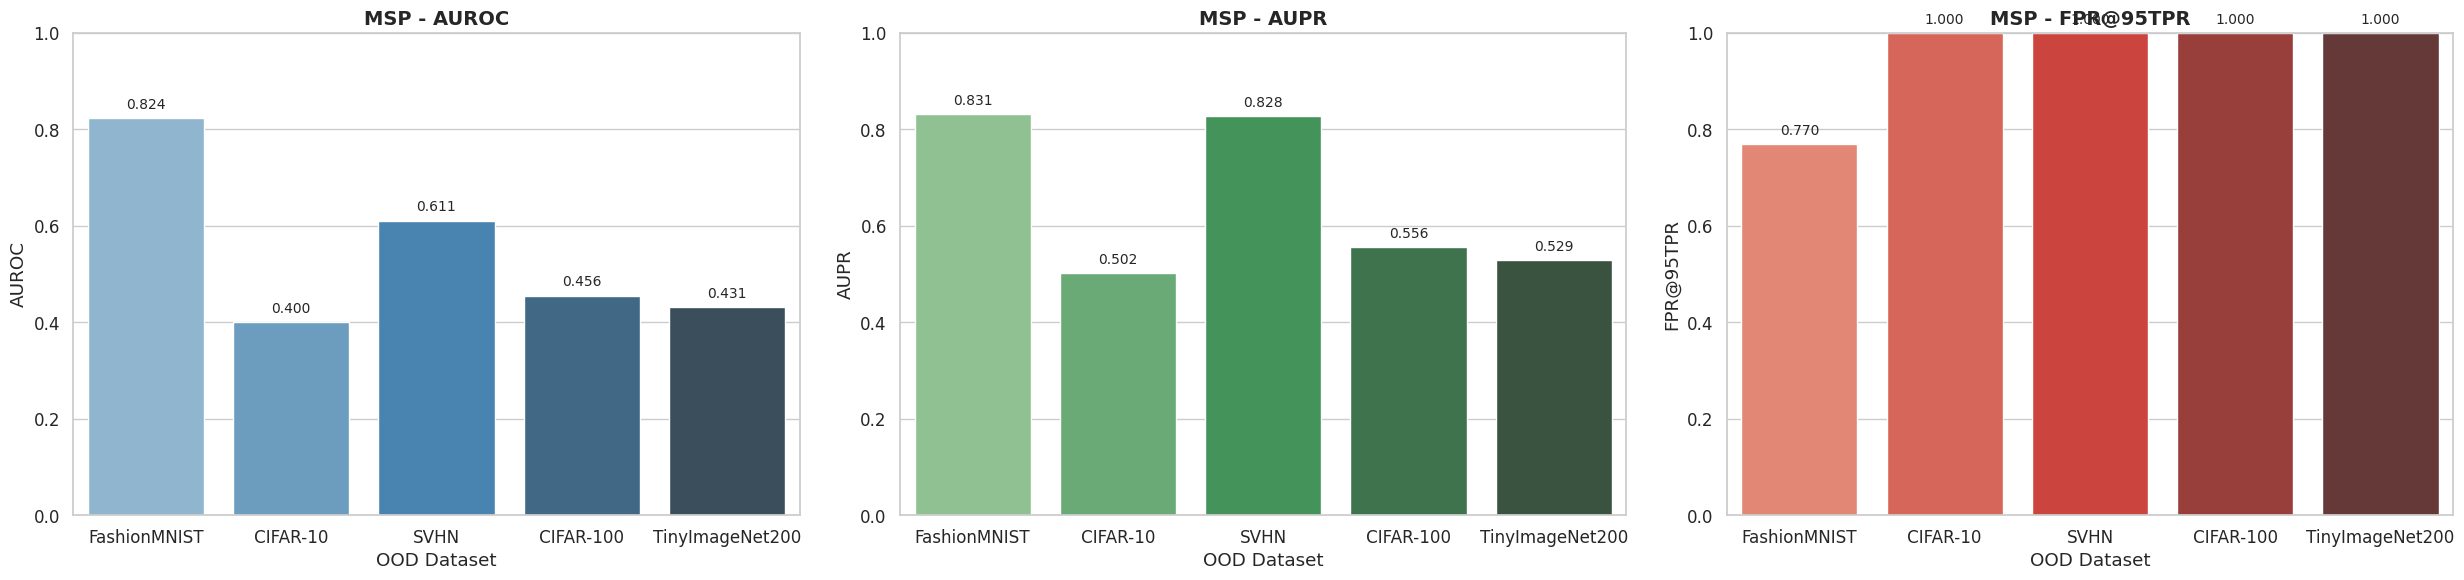

In [ ]:
plot_ood_metrics(df_msp, metric)

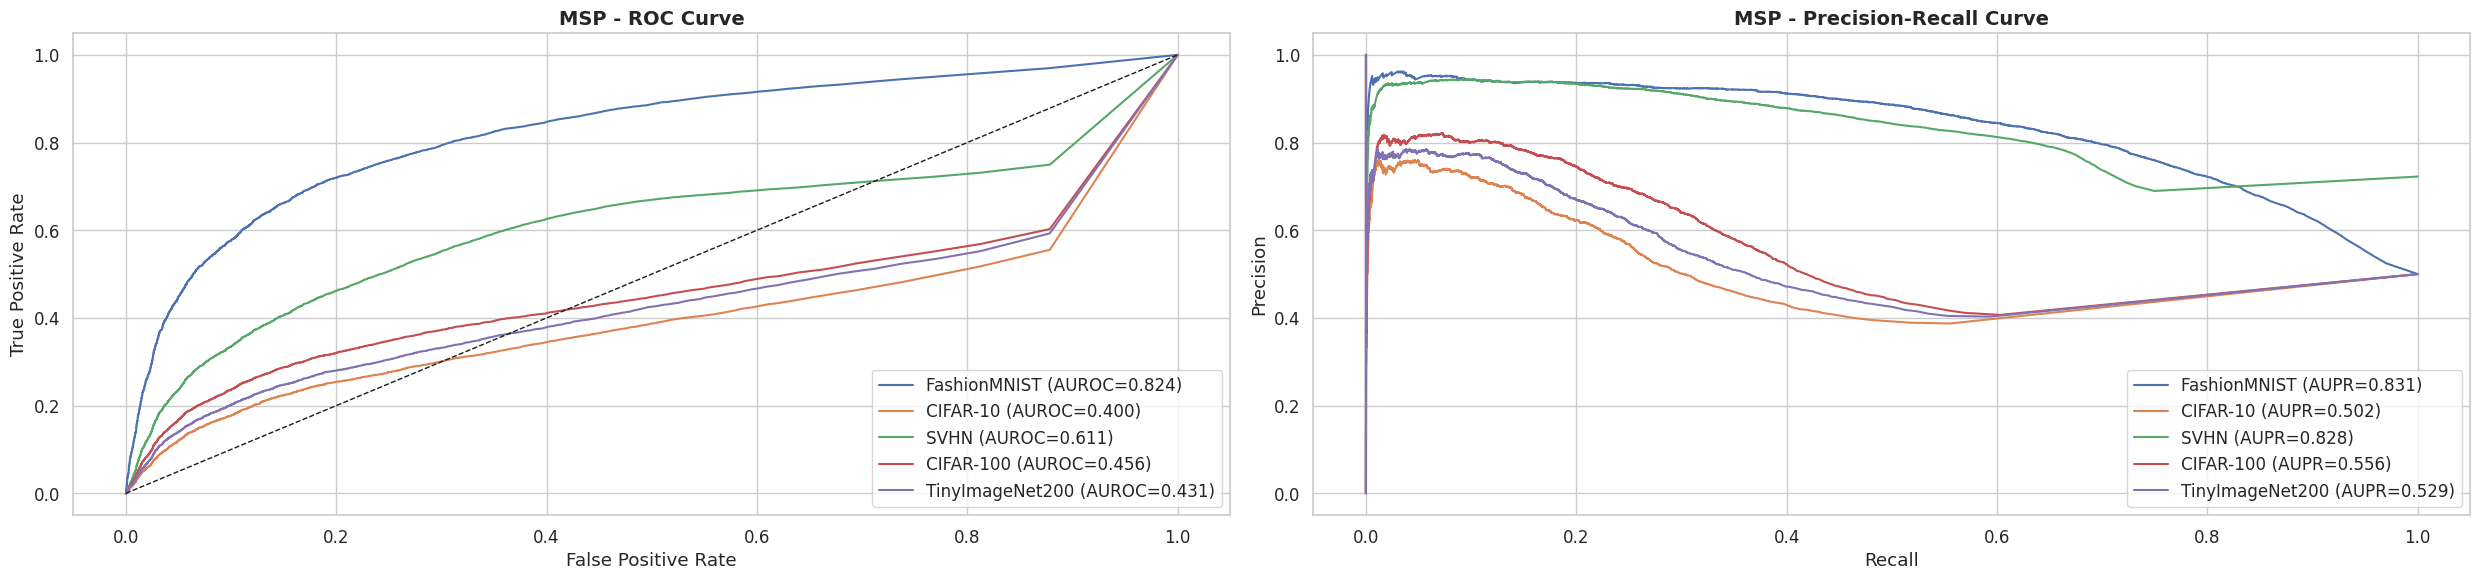

In [ ]:
plot_ood_curves(results_msp, metric)

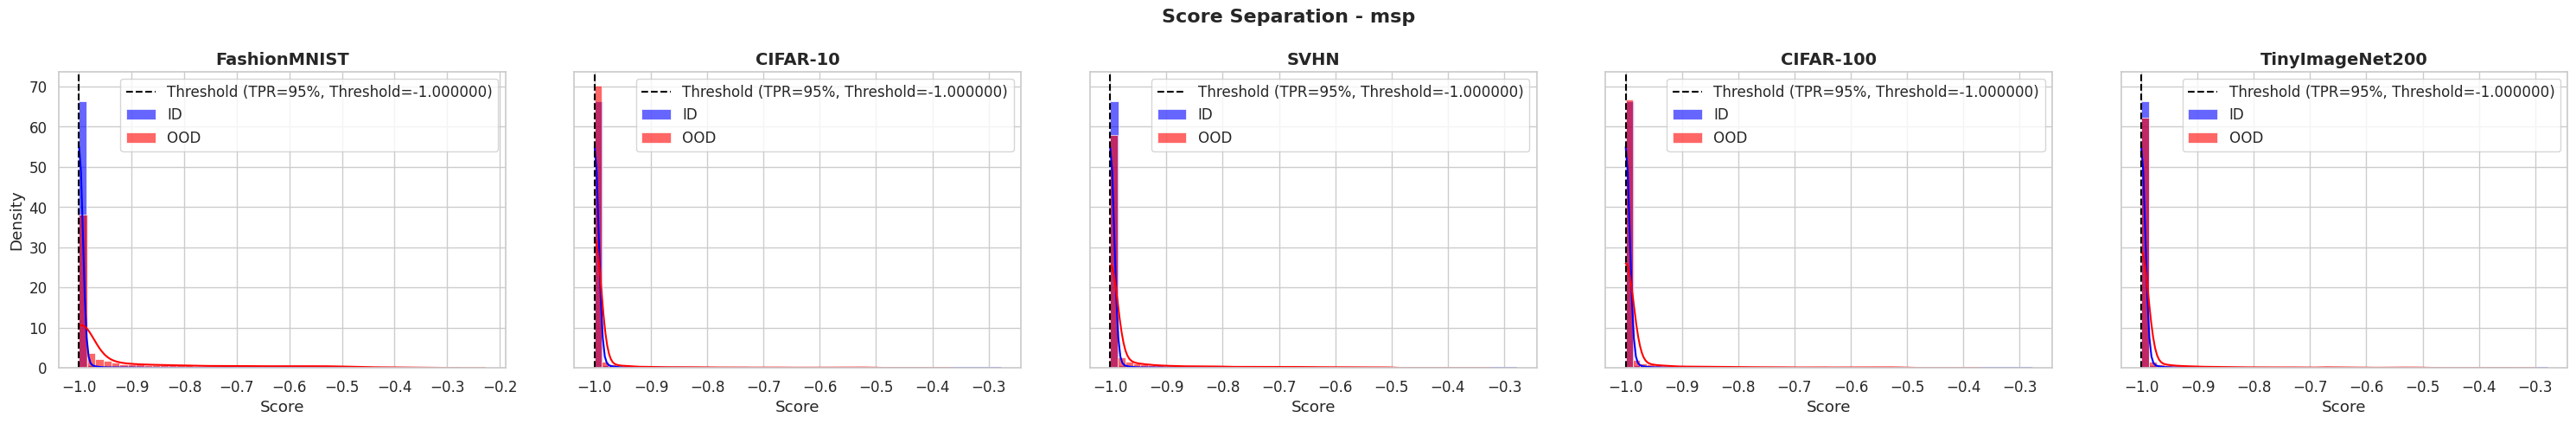

In [ ]:
plot_separation_for_method(results_msp, method_name=metric, target_tpr=0.95)

###### ODIN(Out-of-distrbution detector for Neural Networks)

In [ ]:
metric = "odin"

In [ ]:
df_odin, results_odin = comprehensive_ood_analysis(
    exclude_garbage,
    model=model_after_inv,
    datasets=datasets,
    device=device,
    metric_name= metric,
    id_name=id_name,
    temperature=temperature if metric=="odin" else 1.0,
    class_means=class_means if metric=="mahalanobis" else None,
    cov_inv=cov_inv if metric=="mahalanobis" else None)

COMPREHENSIVE OOD ANALYSIS (Garbage class included) - ODIN


OOD Dataset   AUROC    AUPR  FPR@95TPR  ID odin Mean  OOD odin Mean  \
0     FashionMNIST  0.8152  0.8324     0.8443        0.0925         0.0920   
1         CIFAR-10  0.3898  0.4856     1.0000        0.0925         0.0928   
2             SVHN  0.5303  0.7563     1.0000        0.0925         0.0927   
3        CIFAR-100  0.4313  0.5203     1.0000        0.0925         0.0928   
4  TinyImageNet200  0.4247  0.5139     1.0000        0.0925         0.0927   

   Separation  
0      0.0005  
1      0.0003  
2      0.0002  
3      0.0003  
4      0.0002


Avg AUROC = 0.5183 | Avg AUPR = 0.6217 | Avg FPR@95TPR = 0.9689


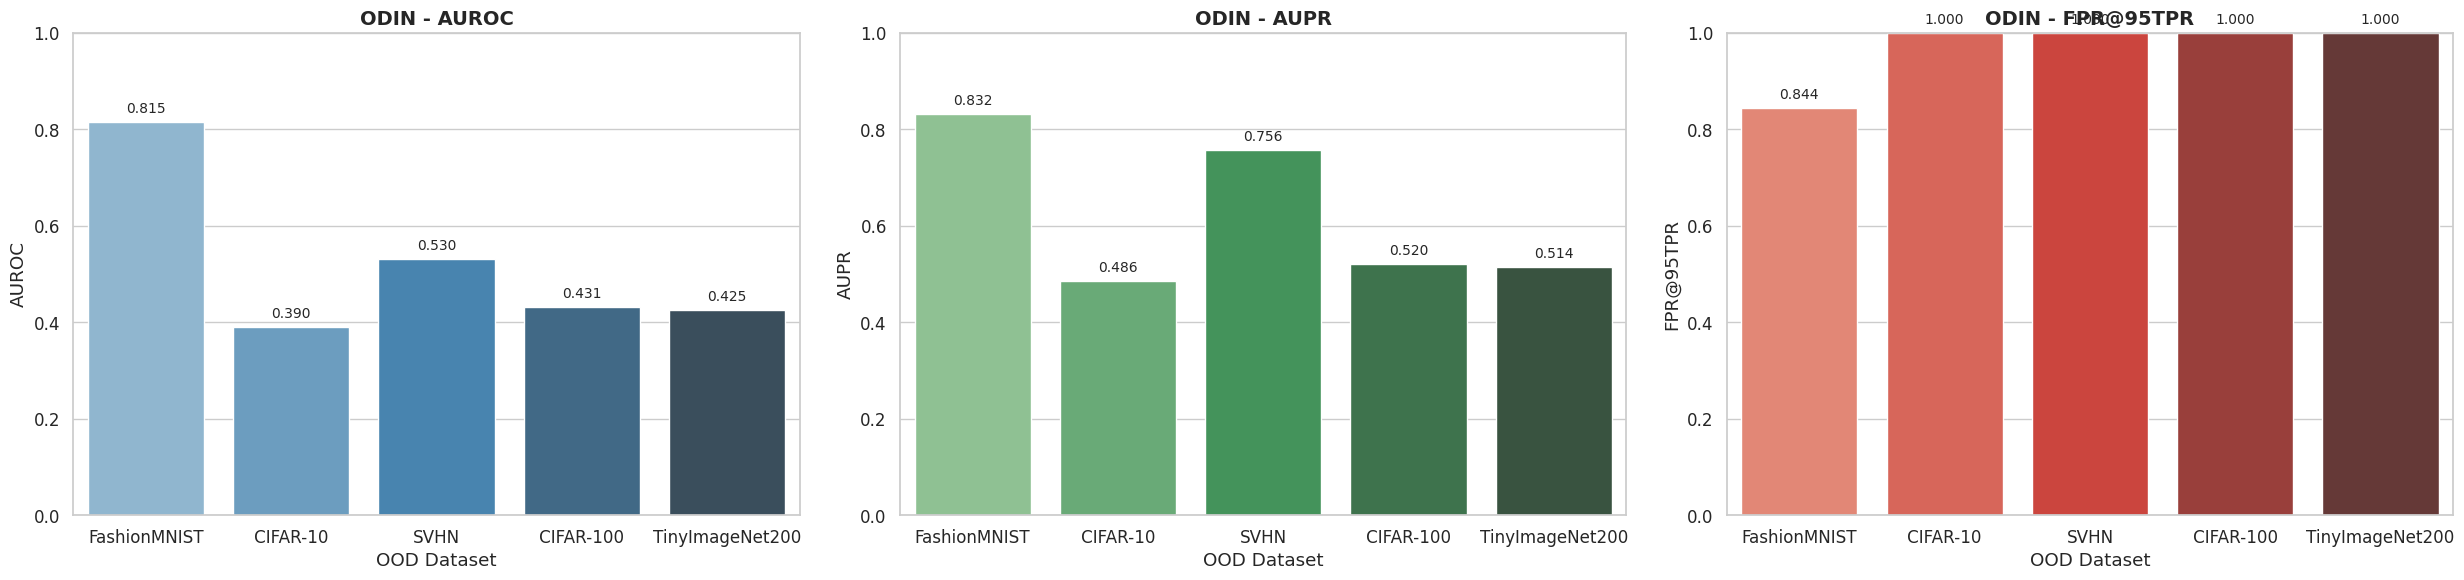

In [ ]:
plot_ood_metrics(df_odin, metric)

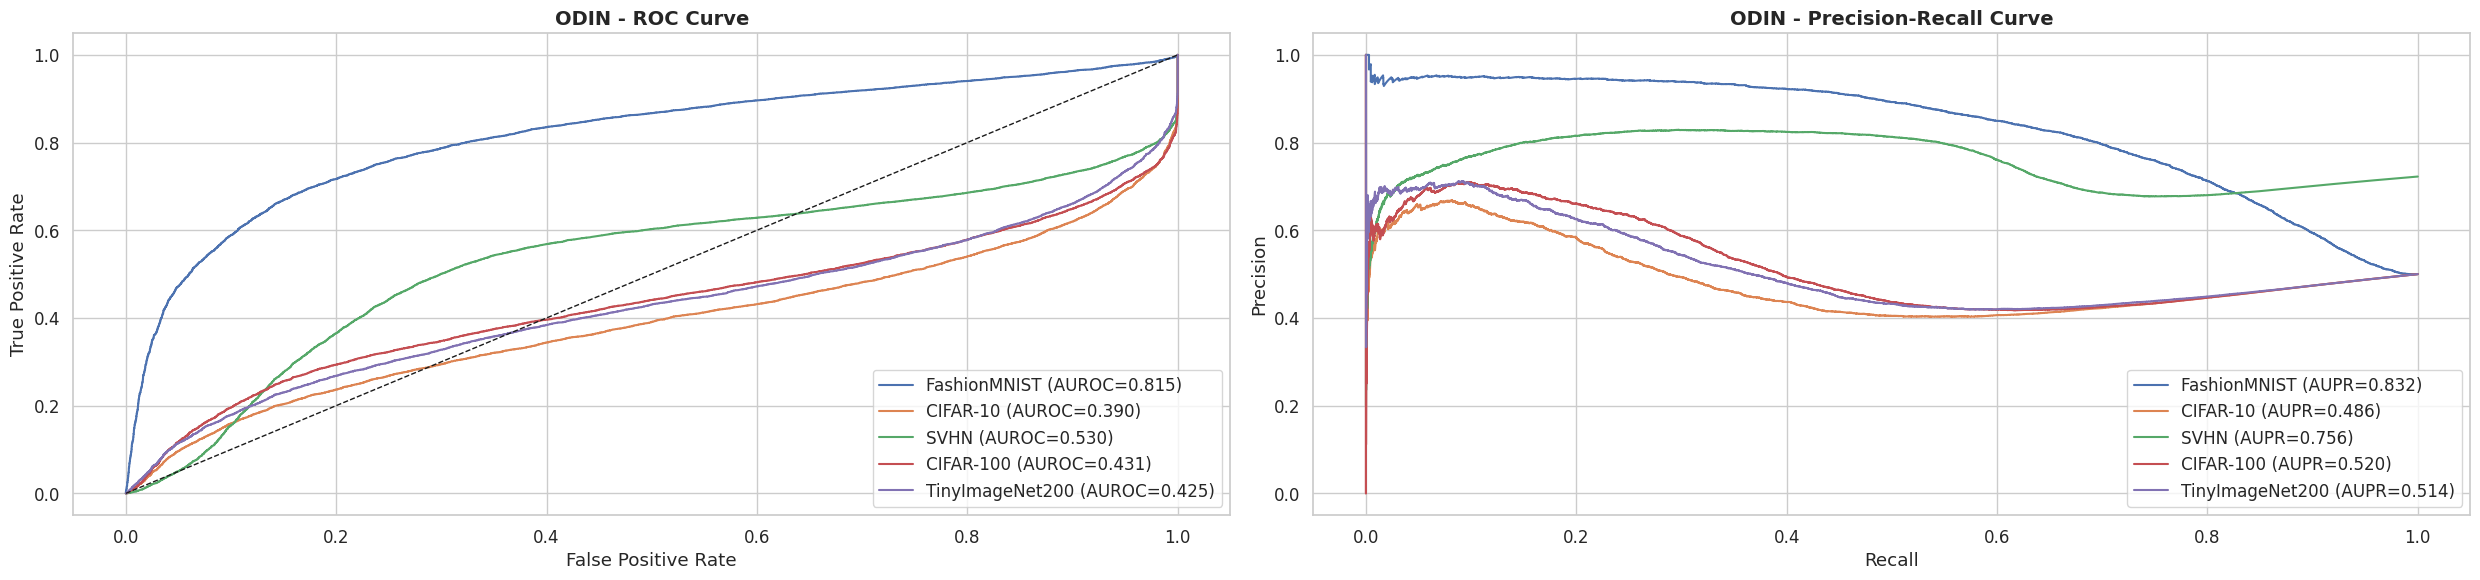

In [ ]:
plot_ood_curves(results_odin, metric)

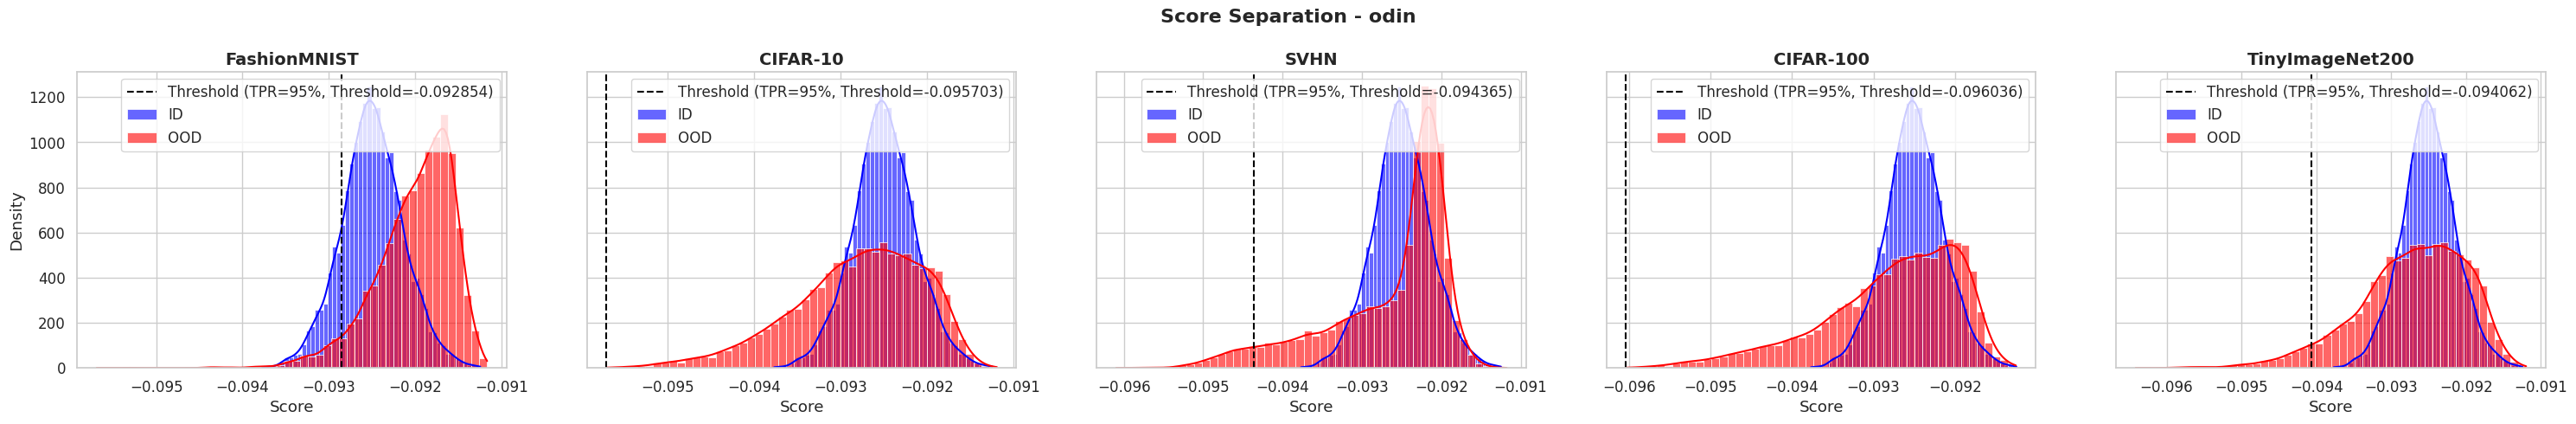

In [ ]:
plot_separation_for_method(results_odin, method_name=metric, target_tpr=0.95)

###### Energy

In [ ]:
metric = "energy"

In [ ]:
df_energy, results_energy = comprehensive_ood_analysis(
    exclude_garbage,
    model=model_after_inv,
    datasets=datasets,
    device=device,
    metric_name= metric,
    id_name=id_name,
    temperature=temperature if metric=="odin" else 1.0,
    class_means=class_means if metric=="mahalanobis" else None,
    cov_inv=cov_inv if metric=="mahalanobis" else None)

COMPREHENSIVE OOD ANALYSIS (Garbage class included) - ENERGY


OOD Dataset   AUROC    AUPR  FPR@95TPR  ID energy Mean  \
0     FashionMNIST  0.7574  0.7908     0.9469         -12.781   
1         CIFAR-10  0.3374  0.4646     1.0000         -12.781   
2             SVHN  0.5237  0.7634     1.0000         -12.781   
3        CIFAR-100  0.3862  0.5038     1.0000         -12.781   
4  TinyImageNet200  0.3714  0.4916     1.0000         -12.781   

   OOD energy Mean  Separation  
0        -9.304600      3.4764  
1       -16.913601      4.1326  
2       -14.841600      2.0606  
3       -16.633200      3.8523  
4       -16.054300      3.2733


Avg AUROC = 0.4752 | Avg AUPR = 0.6028 | Avg FPR@95TPR = 0.9894


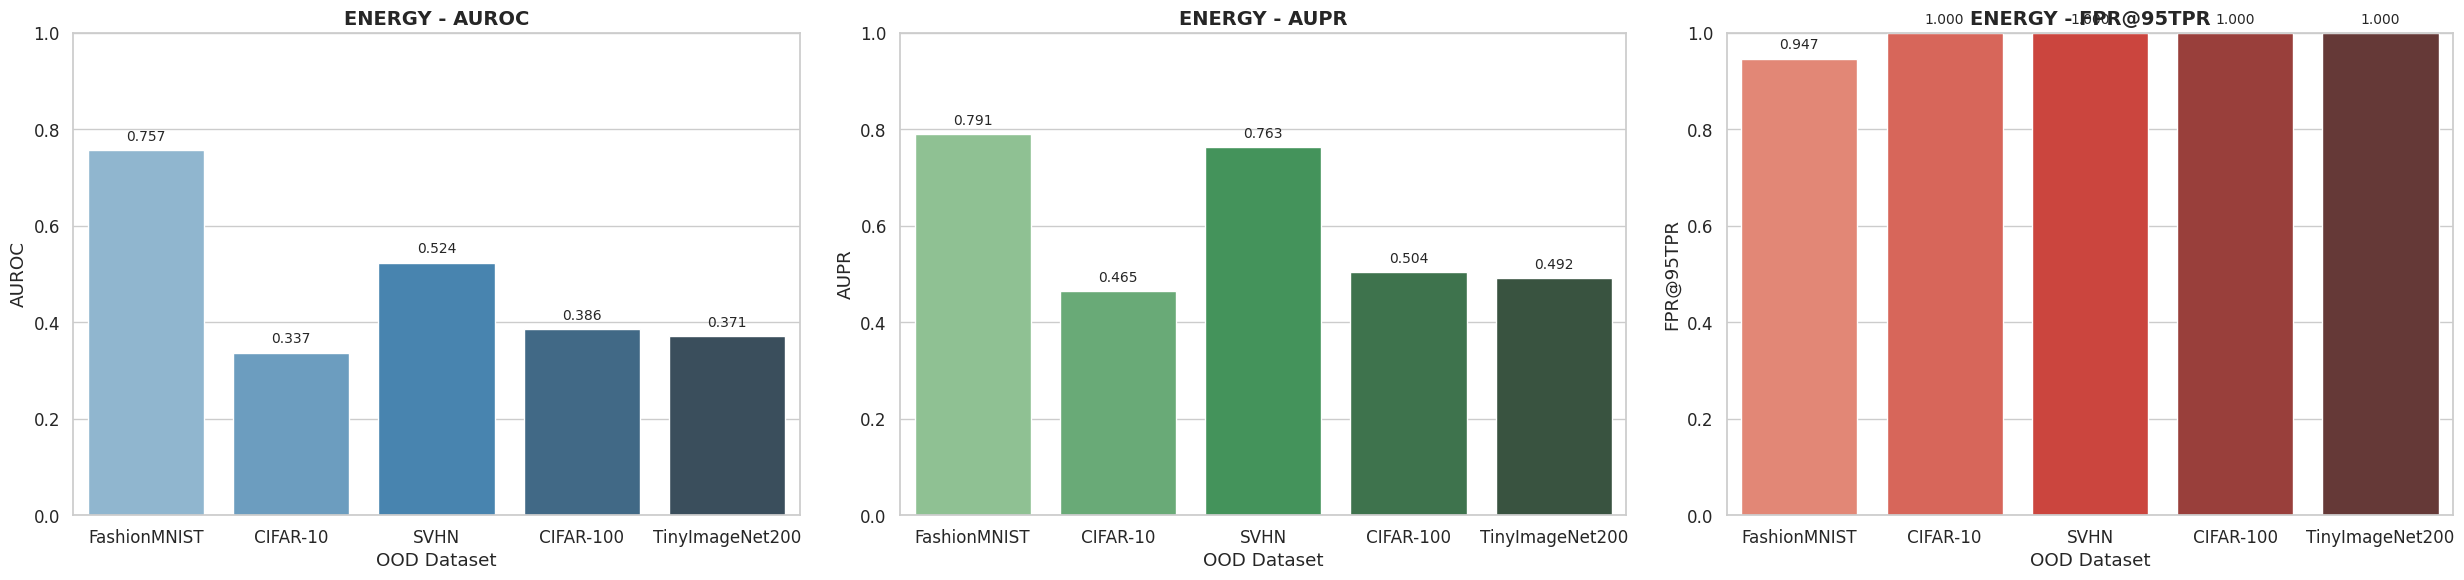

In [ ]:
plot_ood_metrics(df_energy, metric)

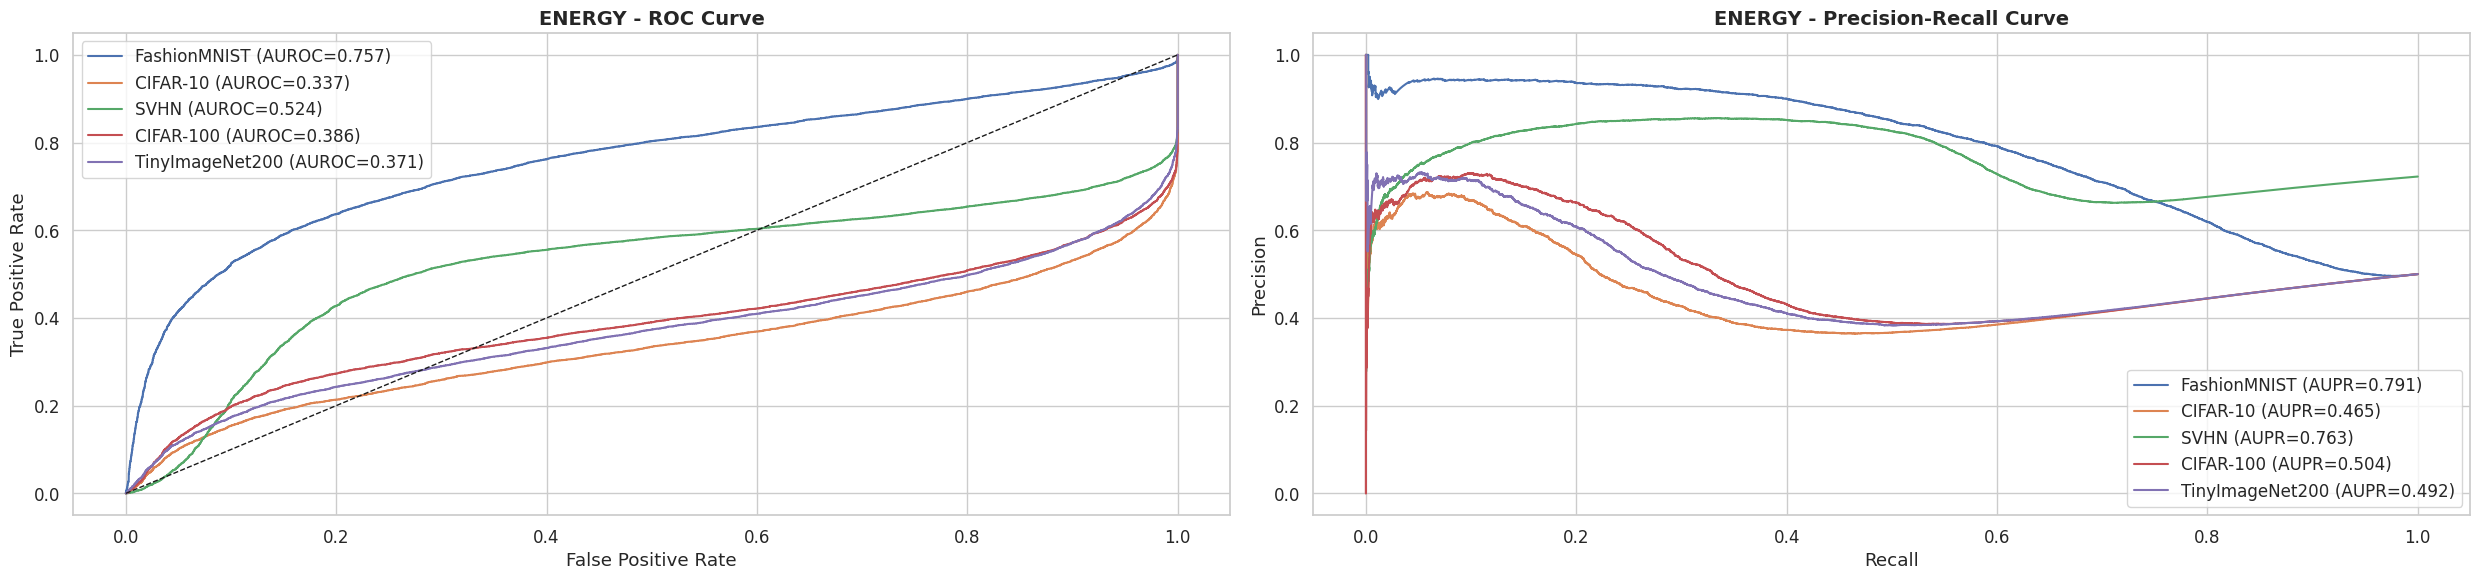

In [ ]:
plot_ood_curves(results_energy, metric)

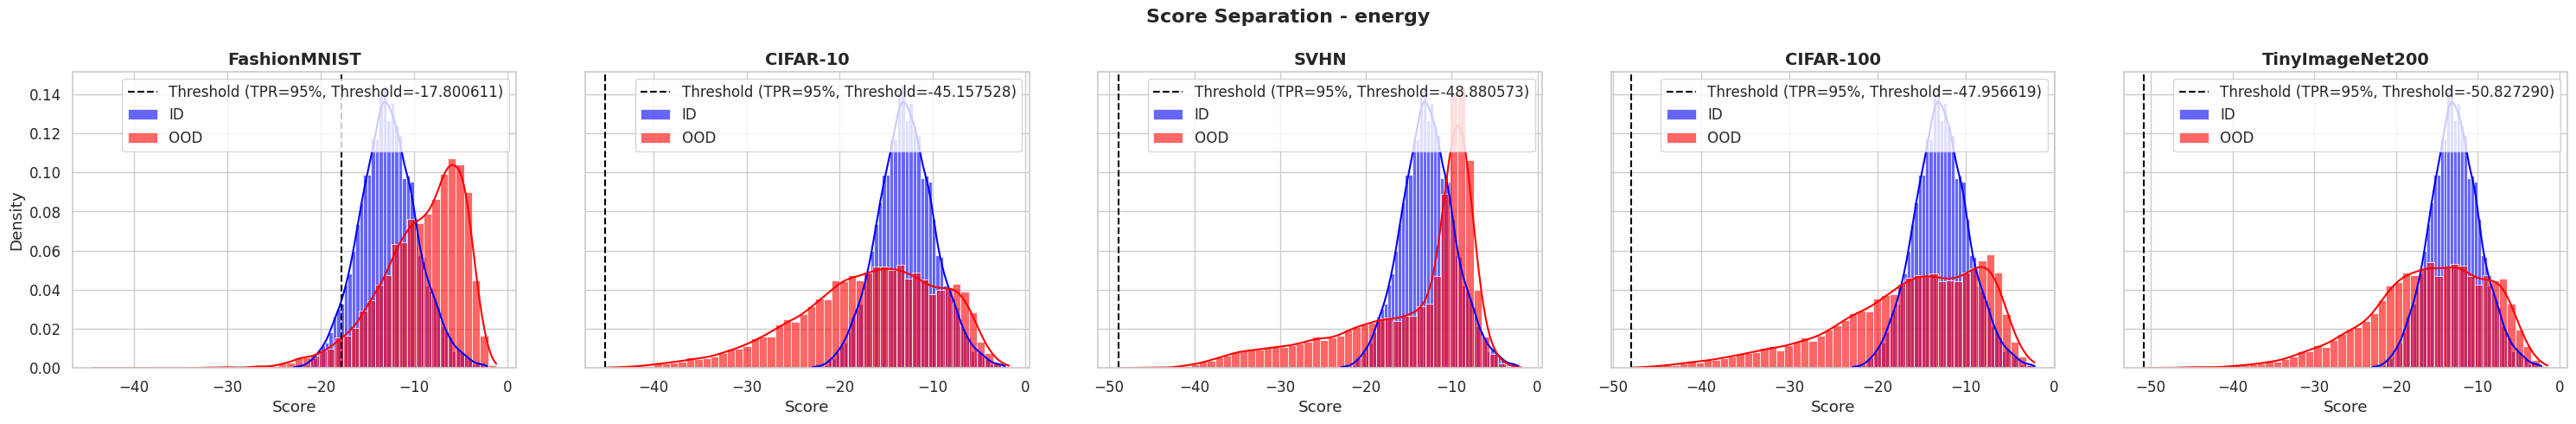

In [ ]:
plot_separation_for_method(results_energy, method_name=metric, target_tpr=0.95)

###### Mahalanobis

In [ ]:
metric = "mahalanobis"

In [ ]:
df_maha, results_maha = comprehensive_ood_analysis(
    exclude_garbage,
    model=model_after_inv,
    datasets=datasets,
    device=device,
    metric_name= metric,
    id_name=id_name,
    temperature=temperature if metric=="odin" else 1.0,
    class_means=class_means if metric=="mahalanobis" else None,
    cov_inv=cov_inv if metric=="mahalanobis" else None)

COMPREHENSIVE OOD ANALYSIS (Garbage class included) - MAHALANOBIS


OOD Dataset   AUROC    AUPR  FPR@95TPR  ID mahalanobis Mean  \
0     FashionMNIST  0.9982  0.9983     0.0083          -119.336502   
1         CIFAR-10  0.9999  0.9999     0.0000          -119.336502   
2             SVHN  0.9998  0.9999     0.0004          -119.336502   
3        CIFAR-100  0.9998  0.9998     0.0000          -119.336502   
4  TinyImageNet200  0.9998  0.9998     0.0001          -119.336502   

   OOD mahalanobis Mean   Separation  
0           -864.147705   744.811218  
1          -2154.067383  2034.730835  
2          -1856.372437  1737.035767  
3          -2194.399658  2075.063232  
4          -1985.195557  1865.859009


Avg AUROC = 0.9995 | Avg AUPR = 0.9995 | Avg FPR@95TPR = 0.0018


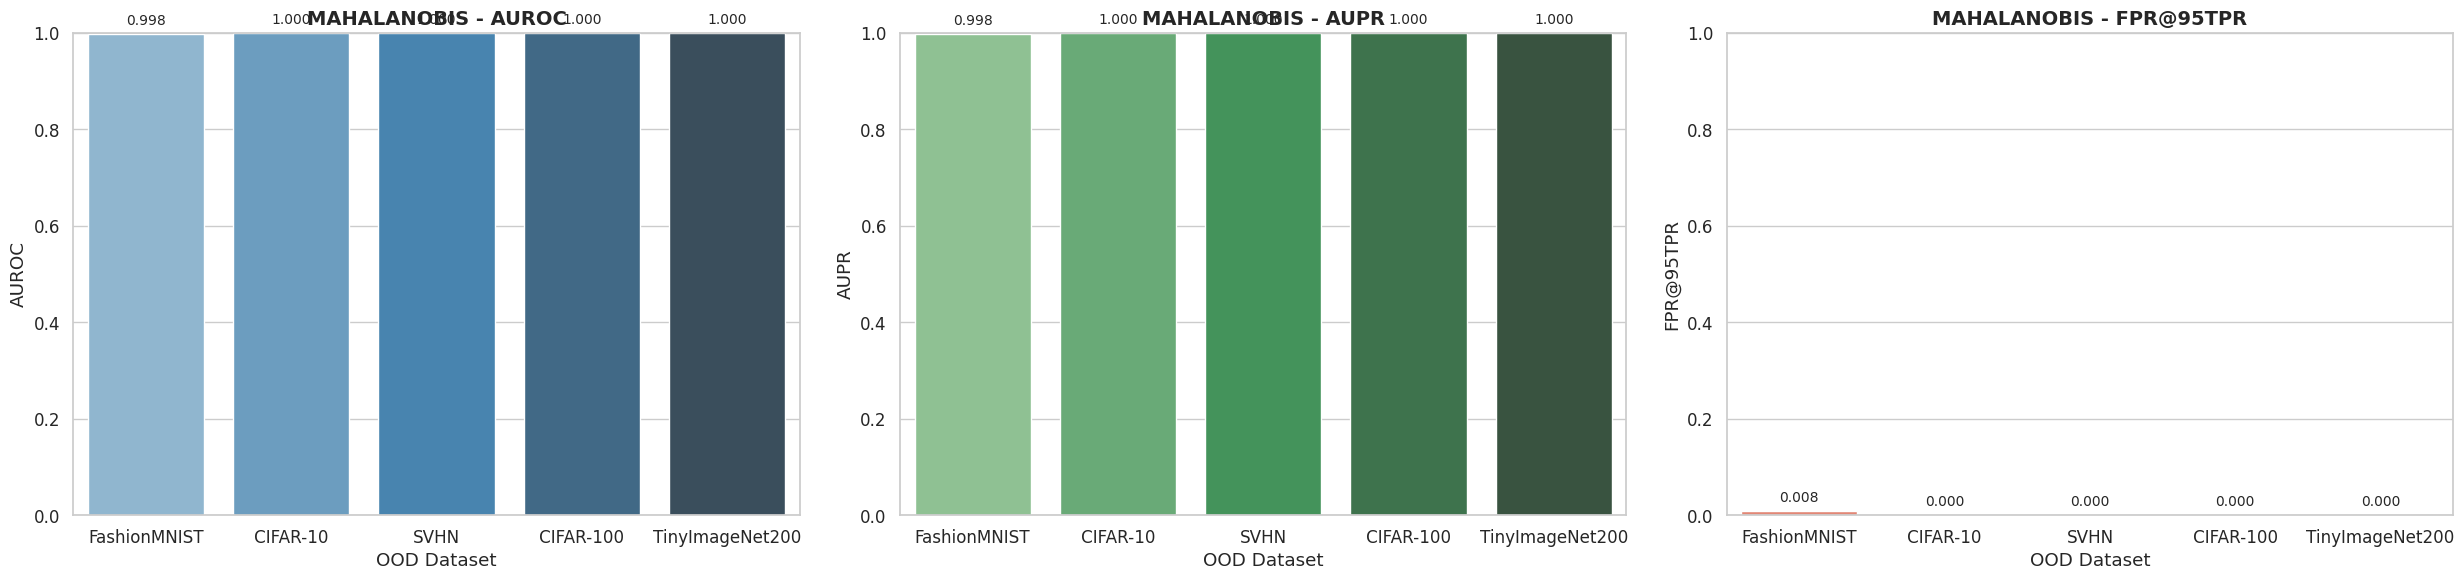

In [ ]:
plot_ood_metrics(df_maha, metric)

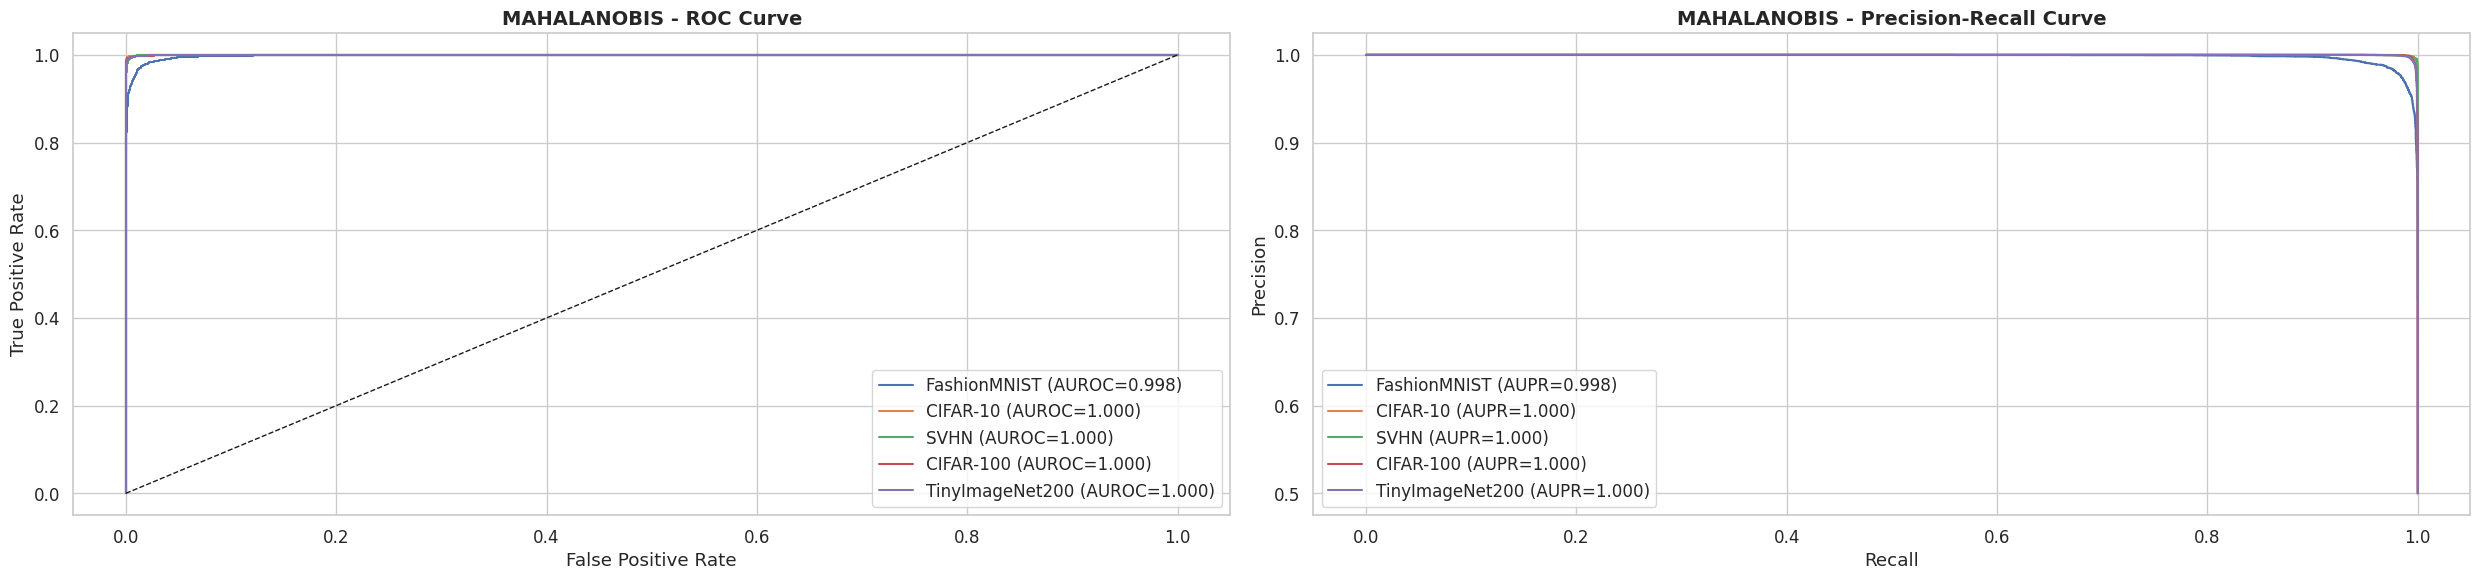

In [ ]:
plot_ood_curves(results_maha, metric)

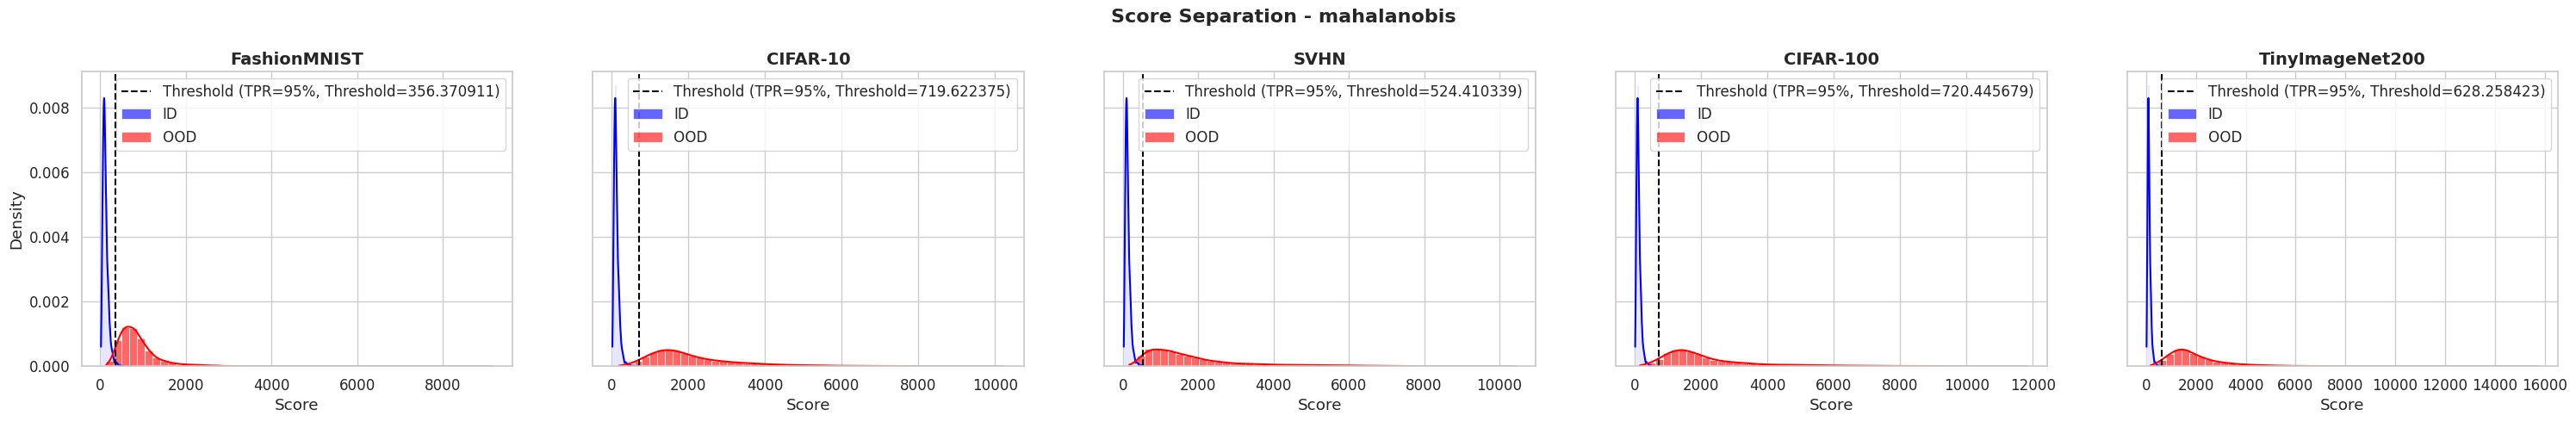

In [ ]:
plot_separation_for_method(results_maha, method_name=metric, target_tpr=0.95)